#Imports

In [ ]:
!pip install datasets transformers[sentencepiece] --quiet
#!pip install emoji==0.6.0 --quiet

     |████████████████████████████████| 451 kB 31.2 MB/s 
     |████████████████████████████████| 5.5 MB 56.2 MB/s 
     |████████████████████████████████| 115 kB 69.0 MB/s 
     |████████████████████████████████| 182 kB 64.6 MB/s 
     |████████████████████████████████| 212 kB 71.9 MB/s 
     |████████████████████████████████| 127 kB 57.3 MB/s 
     |████████████████████████████████| 7.6 MB 64.5 MB/s 
     |████████████████████████████████| 1.3 MB 46.5 MB/s 


In [ ]:
def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)
  return data


import matplotlib.pyplot as plt

from keras import layers
from tensorflow.keras import optimizers
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.layers import *

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn import metrics

import pandas as pd
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout


In [ ]:
def clean_text(df, text_column):
  import re
  new_texts = []
  for text in df[text_column]:
    text_list = str(text).split(" ")
    new_string_list = []
    for word in text_list:
      if 'http' in word:
        word = "url"
      elif ('@' in word) and (len(word) > 1):
        word = "user"
      if not word.isnumeric():
        new_string_list.append(word)
    new_string = " ".join(new_string_list)
    new_string = new_string.strip()
    new_texts.append(new_string)
  df['Text'] = new_texts
  return df

In [ ]:
#!python -m spacy download en_core_web_lg --quiet

#!python -m spacy download en_core_web_sm --quiet
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:

def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct)]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data


def transform_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    dep_column.append([token.dep_ for token in doc])
    pos_column.append([token.pos_ for token in doc])
    ent_column.append([token.label_ for token in doc.ents if (token.label_ == 'PERSON' or token.label_ == 'ORG') ])
  
  data["Text_dep"] = dep_column
  data["Text_pos"] = pos_column
  data["Text_ent"] = ent_column
  return data

def count_categories(dataframe, categories_column, prefix_txt = 'pos'):
  dataframe["merge_indx"] = range(0, len(dataframe))
  from collections import Counter

  dataframe = pd.merge(dataframe, pd.DataFrame([Counter(x) for x in dataframe[categories_column]]).fillna(0).astype(int).add_prefix(str(prefix_txt)), how='left', left_on="merge_indx", right_index=True)
  dataframe.drop(["merge_indx"], axis=1, inplace=True)
  
  return dataframe  

#New Data

In [ ]:
import io
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
uploaded = files.upload()

Saving HillaryClinton_tweets.csv to HillaryClinton_tweets.csv


In [ ]:
hilary = pd.read_csv(io.BytesIO(uploaded['HillaryClinton_tweets.csv']), index_col=0)
hilary.shape

(3199, 16)

In [ ]:
hilary.head()

,Tweet ID,Date Created,Tweet,Clean_tweet,Polarity,Subjectivity,Retweets,Favorites,Language,User ID,User Name,User Twitter Handle,Follower Count,Friend Count,Location,Verified
index,,,,,,,,,,,,,,,,
0,1137024303361339392,2019-06-07,Congratulations to everyone graduating this sp...,Congratulations everyone graduating this sprin...,-0.077778,0.144444,4944,27162,en,1339835893,Hillary Clinton,HillaryClinton,24626280,797,"New York, NY",True
1,1136377947722567680,2019-06-05,The administration is canceling “English class...,administration canceling English classes recre...,0.100000,0.100000,15333,40076,en,1339835893,Hillary Clinton,HillaryClinton,24626280,797,"New York, NY",True
2,1136371602554331136,2019-06-05,"On #WorldEnvironmentDay, I’m feeling inspired ...",#WorldEnvironmentDay feeling inspired work bui...,0.300000,0.300000,1070,4493,en,1339835893,Hillary Clinton,HillaryClinton,24626280,797,"New York, NY",True
3,1135964489042530306,2019-06-04,"RT @harrisonjaime: I may not be a superhero, b...",superhero proud South Carolinian ready fight b...,0.375000,0.531250,13886,0,en,1339835893,Hillary Clinton,HillaryClinton,24626280,797,"New York, NY",True
4,1135962597755379712,2019-06-04,Everyone should encourage their elected offici...,Everyone should encourage their elected offici...,0.233333,0.352381,2610,8332,en,1339835893,Hillary Clinton,HillaryClinton,24626280,797,"New York, NY",True


In [ ]:
hilary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3199 entries, 0 to 3237
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tweet ID             3199 non-null   int64  
 1   Date Created         3199 non-null   object 
 2   Tweet                3199 non-null   object 
 3   Clean_tweet          3199 non-null   object 
 4   Polarity             3199 non-null   float64
 5   Subjectivity         3199 non-null   float64
 6   Retweets             3199 non-null   int64  
 7   Favorites            3199 non-null   int64  
 8   Language             3199 non-null   object 
 9   User ID              3199 non-null   int64  
 10  User Name            3199 non-null   object 
 11  User Twitter Handle  3199 non-null   object 
 12  Follower Count       3199 non-null   int64  
 13  Friend Count         3199 non-null   int64  
 14  Location             3199 non-null   object 
 15  Verified             3199 non-null   b

In [ ]:
hilary = hilary.reset_index(drop=True)

In [ ]:
ids = []
tw_id = []
text_sent = []

In [ ]:
for i in hilary.index:
  doc = nlp(str(hilary.loc[i, 'Tweet']))
  for s in doc.sents:
    if len(str(s)) > 2:
      text_sent.append(str(s))
      ids.append(i)
      tw_id.append(str(hilary.loc[i, 'Tweet ID']))

len(ids)

7681

In [ ]:
hil2 = pd.DataFrame({'idx': ids, 'Tweet ID':tw_id, 'tweet':text_sent })
hil2.shape

(7681, 3)

In [ ]:
hil2['Tweet ID'] = hil2['Tweet ID'].astype('int64')

In [ ]:
hil2['tweet'] = hil2['tweet'].str.replace('\n', ' ')
hil2.head()

,idx,Tweet ID,tweet
0,0,1137024303361339392,Congratulations to everyone graduating this sp...
1,0,1137024303361339392,"Remember, it's not whether you get knocked dow..."
2,0,1137024303361339392,https://t.co/BWQePeEDqt
3,1,1136377947722567680,The administration is canceling “English class...
4,1,1136377947722567680,Don't let them get away with it.


In [ ]:
hilary.columns

Index(['Tweet ID', 'Date Created', 'Tweet', 'Clean_tweet', 'Polarity',
       'Subjectivity', 'Retweets', 'Favorites', 'Language', 'User ID',
       'User Name', 'User Twitter Handle', 'Follower Count', 'Friend Count',
       'Location', 'Verified'],
      dtype='object')

In [ ]:
hil2 = hil2.merge(hilary[['Tweet ID', 'Date Created', 'Tweet', 'Polarity',
       'Subjectivity', 'Retweets', 'Favorites',  'User ID', 'User Name']], on = 'Tweet ID', how='left')

In [ ]:
#hil2['sentence'] = hil2['sentence'].str.lower()
hil2 = clean_text(hil2, 'sentence')
hil2.tail(3)

,idx,Tweet ID,Tweet,Date Created,Retweets,Favorites,User ID,User Name,sentence,Text,Ethos_Label,ethos_last3,ethos_pooler3,ethos_10,ethos_9_aggr,Pathos_Label,pathos_10,Rep Speech
7678.0,3197.0,7.730019e+17,RT @timkaine: Stronger together. https://t.co/...,2016-09-06,2953.0,0.0,1.339836e+09,Hillary Clinton,https://t.co/6qmoj39k56,url,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN
7679.0,3198.0,7.729635e+17,"""The essence of his campaign is bigotry."" —@Be...",2016-09-06,2584.0,6060.0,1.339836e+09,Hillary Clinton,"""the essence of his campaign is bigotry.""","""the essence of his campaign is bigotry.""",NaN,2.0,1.0,2.0,2.0,NaN,1.0,NaN
7680.0,3198.0,7.729635e+17,"""The essence of his campaign is bigotry."" —@Be...",2016-09-06,2584.0,6060.0,1.339836e+09,Hillary Clinton,—@berniesanders on donald trump in new hampshi...,user on donald trump in new hampshire url,NaN,0.0,0.0,0.0,0.0,NaN,1.0,NaN


In [ ]:
hil2 = load_data('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hilary_Tweets_Ethos.xlsx')
#hil2.iloc[:140]['Ethos_Label'] = hil2.iloc[:140]['Ethos_Label'].fillna(0)
hil2.head(2)

,idx,Tweet ID,Tweet,Date Created,Retweets,Favorites,User ID,User Name,sentence,Text,Ethos_Label,ethos_last3,ethos_pooler3,ethos_10,ethos_9_aggr,Pathos_Label,pathos_10,Rep Speech
0.0,0.0,1.137024e+18,Congratulations to everyone graduating this sp...,2019-06-07,4944.0,27162.0,1.339836e+09,Hillary Clinton,congratulations to everyone graduating this sp...,congratulations to everyone graduating this sp...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,NaN
1.0,0.0,1.137024e+18,Congratulations to everyone graduating this sp...,2019-06-07,4944.0,27162.0,1.339836e+09,Hillary Clinton,"remember, it's not whether you get knocked dow...","remember, it's not whether you get knocked dow...",0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN


In [ ]:
hil2.iloc[:140].to_excel('/content/hilary_s140.xlsx')

In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Pathos_Label'].values, hil2.iloc[:140]['pathos_10'].values), 
      metrics.cohen_kappa_score( hil2.iloc[:140]['Pathos_Label'].values, hil2.iloc[:140]['pathos_10'].values ))

0.95 0.7134502923976608


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_last3'].values), 
      metrics.cohen_kappa_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_last3'].values ))

0.75 0.4512877939529675


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_pooler3'].values), 
      metrics.cohen_kappa_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_pooler3'].values))

0.7571428571428571 0.47807017543859653


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_10'].values), 
      metrics.cohen_kappa_score( hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_10'].values ))

0.8285714285714286 0.5068251871422281


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_9_aggr'].values), 
      metrics.cohen_kappa_score( hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_9_aggr'].values ))

0.8428571428571429 0.5252774352651048


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_m3-2-sent'].values), 
      metrics.cohen_kappa_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_m3-2-sent'].values))

0.8357142857142857 0.5229629629629629


In [ ]:
print(metrics.accuracy_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_m3-3-emo'].values), 
      metrics.cohen_kappa_score(hil2.iloc[:140]['Ethos_Label'].values, hil2.iloc[:140]['ethos_m3-3-emo'].values))

0.8642857142857143 0.5749440715883669


#DAta Hansard

In [ ]:
han_tr = load_data('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hansardTRAIN.csv')
han_ts = load_data('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hansardTEST.csv')

hans = pd.concat( [han_tr, han_ts], axis=0, ignore_index=True )
print(hans.shape)
hans.head(3)

(637, 4)


,who,text,Ethos_Label,text2
0,Mr. Meyer has ethos,I am sure that Mr. Meyer is right in stressing...,1,RL : I am sure that he is right in stressing t...
1,Mr. Luce has ethos,the action that Mr. Luce has already taken is ...,1,TJ : Is my right hon. Friend aware that the ac...
2,Mr. Jessel has ethos,What Mr. Jessel says is absolutely right,1,RL : What he says is absolutely right


In [ ]:
hans.text2.str.split().map(len).mean()

25.114599686028257

In [ ]:
et.Text.str.split().map(len).mean()

9.318593582066637

In [ ]:
han_ts.shape, han_tr.shape

((242, 4), (395, 4))

In [ ]:
#hans['text2'] = hans['text2'].str[4:]

han_tr['text2'] = han_tr['text2'].str[4:]
han_ts['text2'] = han_ts['text2'].str[4:]

In [ ]:
#hans = clean_text(hans, text_column = 'text2')

han_tr = clean_text(han_tr, text_column = 'text2')
han_ts = clean_text(han_ts, text_column = 'text2')

In [ ]:
han_ts.Ethos_Label.value_counts()

2    179
1     63
Name: Ethos_Label, dtype: int64

In [ ]:
han_tr.Ethos_Label.value_counts(normalize=True)

2    0.731646
1    0.268354
Name: Ethos_Label, dtype: float64

#Data

In [ ]:
et_cols = ['Text', 'Ethos_Label', 'Source', 'Target']

In [ ]:
et1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_US2016.xlsx', 
                     index_col=0)# usecols = et_cols,
et1.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,expressed_emotion_PaREMO,T5_emotion,expressed_sentiment,pathos_label,pathos_name,ethos_name,logos_name,clean_Text,clean_Text_lemmatized,EmotAn_label
0,10055,Please someone tell me I'm wrong,Emerica,NaN,1,0.0,0.0,0.0,0,0,...,surprise,anger,Negative,-1,negative,neutral,neutral,Please someone tell me I'm wrong,please someone tell I I be wrong,anger
1,10055,"Take the people who are Bernie supporters, som...",Emerica,NaN,1,0.0,0.0,0.0,0,1,...,surprise,anger,Neutral,0,neutral,neutral,support,"Take the people who are Bernie supporters, som...","take the people who be bernie supporter , some...",neutral


In [ ]:
#et1['EmotAn_label'].value_counts()

In [ ]:
et2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/APP/LEP_test-main/app_conspiracy.xlsx', 
                    index_col=0)# usecols = et_cols,
et2.head(1)

,map_ID,Text,Source,corpus,topic_1,topic_2,confidence_topic_1,confidence_topic_2,text_length,RA_logos,...,Attack,Ethos_Label,Target,pathos_label,ethos_name,logos_name,pathos_name,clean_Text,clean_Text_lemmatized,EmotAn_label
0,22684,"Now, double vaccinated dying from COVID are bl...",Effective_Ad4588,1,death sickness ill,media news,0.77,0.74,10,NaN,...,1.0,2,the vaccinated,-1,attack,neutral,negative,"Now, double vaccinated dying from COVID are bl...","now , double vaccinate die from covid be blame...",anger


In [ ]:
#et2['EmotAn_label'].value_counts()

In [ ]:
et = pd.concat([et1, et2], axis = 0)
et = et.reset_index(drop=True)
et.shape

(6513, 42)

In [ ]:
et.Ethos_Label.value_counts(normalize=False)

0    4650
2    1289
1     574
Name: Ethos_Label, dtype: int64

#Abusive lexicon

In [ ]:
# https://github.com/uds-lsv/lexicon-of-abusive-words/tree/master/Lexicons

!wget https://raw.githubusercontent.com/uds-lsv/lexicon-of-abusive-words/master/Lexicons/expandedLexicon.txt

--2022-10-15 14:19:53--  https://raw.githubusercontent.com/uds-lsv/lexicon-of-abusive-words/master/Lexicons/expandedLexicon.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209386 (204K) [text/plain]
Saving to: ‘expandedLexicon.txt’

expandedLexicon.txt 100%[===================>] 204.48K  --.-KB/s    in 0.03s   

2022-10-15 14:19:53 (6.42 MB/s) - ‘expandedLexicon.txt’ saved [209386/209386]



In [ ]:
abuse = pd.read_csv('/content/expandedLexicon.txt', sep = '\t', header = None)
abuse.columns = ['word', 'score']
abuse.head(1)

,word,score
0,horrible_noun,3.679601


In [ ]:
abuse.shape, abuse[abuse.score > 0].shape

((8478, 2), (2989, 2))

In [ ]:
abuse = abuse[abuse.score > 0]

In [ ]:
abuse.describe()

,score
count,2989.000000
mean,0.668565
std,0.537234
min,0.000206
25%,0.305021
50%,0.558085
75%,0.830878
max,3.679601


In [ ]:
abuse = abuse[abuse.score > 0.67]
abuse[abuse.score > 0.67].shape

(1023, 2)

In [ ]:
import re

abuse['sp'] = abuse.word.apply(lambda x: int(re.search(r"_", str(x)).span()[-1]) - 1)
abuse['sp'] 

0        8
1       10
2        5
3        7
4        6
        ..
1018     4
1019     8
1020    11
1021     4
1022     8
Name: sp, Length: 1023, dtype: int64

In [ ]:
for i in abuse.index:
  s = (abuse.sp.loc[i])
  abuse.loc[i, 'word2'] = abuse.loc[i, 'word'][:s]
  abuse.loc[i, 'pos'] = abuse.loc[i, 'word'][s+1:]
abuse['word2']

0          horrible
1        disgusting
2             moron
3           bastard
4            stupid
           ...     
1018           clod
1019       dickfuck
1020    masochistic
1021           hobo
1022       shagging
Name: word2, Length: 1023, dtype: object

In [ ]:
abuse.columns = ['ww', 'score', 'sp', 'word', 'pos']
abuse = abuse[['word', 'score', 'pos']]
abuse

,word,score,pos
0,horrible,3.679601,noun
1,disgusting,3.493682,adj
2,moron,3.469677,noun
3,bastard,3.399238,noun
4,stupid,3.323882,noun
...,...,...,...
1018,clod,0.671309,verb
1019,dickfuck,0.671229,noun
1020,masochistic,0.671008,adj
1021,hobo,0.671004,verb


In [ ]:
abuse = abuse[ ~(abuse.word.isin(['were', 'div', 'brat'])) ]

In [ ]:
out = abuse[ (abuse.score < 1) & ~(abuse.pos.isin(['noun', 'adj'])) ].word.values
abuse = abuse[ ~(abuse.word.isin(out)) ]
abuse.shape

(936, 4)

In [ ]:
abuse['len'] = abuse.word.map(len)

##EP lexicon

In [ ]:
def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].str.lower()):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct)]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data

In [ ]:
df_ethos = lemma_text(et, 'Text')

In [ ]:
from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS


def make_word_cloud(comment_words, width = 1100, height = 650, colour = "black", colormap = "brg"):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(collocations=False, max_words=250, colormap=colormap, width = width, height = height,
                background_color ='black',
                min_font_size = 14, stopwords = stopwords).generate(comment_words) # , stopwords = stopwords

    fig, ax = plt.subplots(figsize = (width/ 100, height/100), facecolor = colour)
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    words = wordcloud.words_
    return words



def prepare_cloud_lexeme_data(data_neutral, data_support, data_attack):

  # neutral df
  neu_text = " ".join(data_neutral['Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_neu_text = Counter(neu_text.split(" "))
  df_neu_text = pd.DataFrame( {"word": list(count_dict_df_neu_text.keys()),
                              'neutral #': list(count_dict_df_neu_text.values())} )
  df_neu_text.sort_values(by = 'neutral #', inplace=True, ascending=False)
  df_neu_text.reset_index(inplace=True, drop=True)
  #df_neu_text = df_neu_text[~(df_neu_text.word.isin(stops))]

  # support df
  supp_text = " ".join(data_support['Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_supp_text = Counter(supp_text.split(" "))
  df_supp_text = pd.DataFrame( {"word": list(count_dict_df_supp_text.keys()),
                              'support #': list(count_dict_df_supp_text.values())} )

  df_supp_text.sort_values(by = 'support #', inplace=True, ascending=False)
  df_supp_text.reset_index(inplace=True, drop=True)
  #df_supp_text = df_supp_text[~(df_supp_text.word.isin(stops))]

  merg = pd.merge(df_supp_text, df_neu_text, on = 'word', how = 'outer')

  #attack df
  att_text = " ".join(data_attack['Text_lemmatized'].apply(lambda x: " ".join(t for t in set(x.split()))).to_numpy())
  count_dict_df_att_text = Counter(att_text.split(" "))
  df_att_text = pd.DataFrame( {"word": list(count_dict_df_att_text.keys()),
                              'attack #': list(count_dict_df_att_text.values())} )

  df_att_text.sort_values(by = 'attack #', inplace=True, ascending=False)
  df_att_text.reset_index(inplace=True, drop=True)
  #df_att_text = df_att_text[~(df_att_text.word.isin(stops))]

  df2 = pd.merge(merg, df_att_text, on = 'word', how = 'outer')
  df2.fillna(0, inplace=True)
  df2['general #'] = df2['support #'] + df2['attack #'] + df2['neutral #']
  df2['word'] = df2['word'].str.replace("'", "_").replace("”", "_").replace("’", "_")
  return df2



def wordcloud_lexeme(dataframe, lexeme_threshold = 90, count_threshold = 2, analysis_for = 'support', cmap_wordcloud = 'crest'):
  '''
  analysis_for:
  'support',
  'attack',
  'both' (both support and attack)

  cmap_wordcloud: best to choose from:
  gist_heat, flare_r, crest, viridis

  '''
  if analysis_for == 'attack':
    #print(f'Analysis for: {analysis_for} ')
    cmap_wordcloud = 'Reds' #gist_heat
    dataframe['% lexeme'] = (round(dataframe['attack #'] / dataframe['general #'], 3) * 100).apply(float) # att
  elif analysis_for == 'both':
    #print(f'Analysis for: {analysis_for} ')
    cmap_wordcloud = 'autumn' #viridis
    dataframe['% lexeme'] = (round((dataframe['support #'] + dataframe['attack #']) / dataframe['general #'], 3) * 100).apply(float) # both supp & att
  else:
    #print(f'Analysis for: {analysis_for} ')
    dataframe['% lexeme'] = (round(dataframe['support #'] / dataframe['general #'], 3) * 100).apply(float) # supp

  dfcloud = dataframe[(dataframe['% lexeme'] >= int(lexeme_threshold)) & (dataframe['general #'] > int(count_threshold)) & (dataframe.word.map(len)>3)]
  #print(f'There are {len(dfcloud)} words for the analysis of language {analysis_for} with % lexeme threshold equal to {lexeme_threshold}.')
  n_words = dfcloud['word'].nunique()
  text = []
  for i in dfcloud.index:
    w = dfcloud.loc[i, 'word']
    w = str(w).strip()
    if analysis_for == 'both':
      n = int(dfcloud.loc[i, 'support #'] + dfcloud.loc[i, 'attack #'])
    else:
      n = int(dfcloud.loc[i, str(analysis_for)+' #']) #  + dfcloud.loc[i, 'attack #']   dfcloud.loc[i, 'support #']+  general
    l = np.repeat(w, n)
    text.extend(l)

  import random
  random.shuffle(text)
  print(f"There are {n_words} words.")
  words = make_word_cloud(" ".join(text), 1000, 620, '#1E1E1E', str(cmap_wordcloud)) #gist_heat / flare_r crest viridis
  
  return words

In [ ]:
data = prepare_cloud_lexeme_data(df_ethos[df_ethos.Ethos_Label == 0], 
                                 df_ethos[df_ethos.Ethos_Label == 1], 
                                 df_ethos[df_ethos.Ethos_Label == 2])
data.tail()

,word,support #,neutral #,attack #,general #
5696,vacuum,0.0,0.0,1.0,1.0
5697,pushback,0.0,0.0,1.0,1.0
5698,cooperative,0.0,0.0,1.0,1.0
5699,slot,0.0,0.0,1.0,1.0
5700,walker,0.0,0.0,1.0,1.0


There are 34 words.


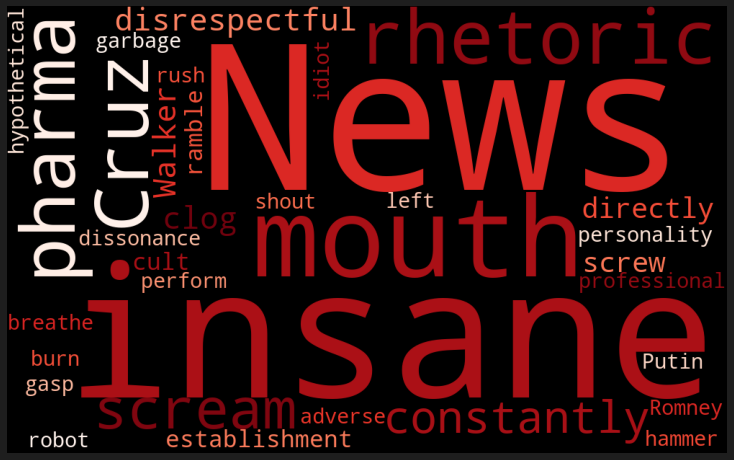

{'News': 1.0,
 'insane': 0.7777777777777778,
 'mouth': 0.7777777777777778,
 'rhetoric': 0.6666666666666666,
 'pharma': 0.6666666666666666,
 'Cruz': 0.6666666666666666,
 'scream': 0.6666666666666666,
 'constantly': 0.5555555555555556,
 'disrespectful': 0.5555555555555556,
 'clog': 0.5555555555555556,
 'Walker': 0.5555555555555556,
 'screw': 0.4444444444444444,
 'directly': 0.4444444444444444,
 'establishment': 0.4444444444444444,
 'cult': 0.4444444444444444,
 'ramble': 0.4444444444444444,
 'shout': 0.3333333333333333,
 'dissonance': 0.3333333333333333,
 'professional': 0.3333333333333333,
 'breathe': 0.3333333333333333,
 'personality': 0.3333333333333333,
 'burn': 0.3333333333333333,
 'garbage': 0.3333333333333333,
 'adverse': 0.3333333333333333,
 'hammer': 0.3333333333333333,
 'robot': 0.3333333333333333,
 'perform': 0.3333333333333333,
 'idiot': 0.3333333333333333,
 'Putin': 0.3333333333333333,
 'rush': 0.3333333333333333,
 'gasp': 0.3333333333333333,
 'Romney': 0.3333333333333333,
 '

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 75, analysis_for = 'attack', cmap_wordcloud = 'Reds', count_threshold=3)
words

There are 19 words.


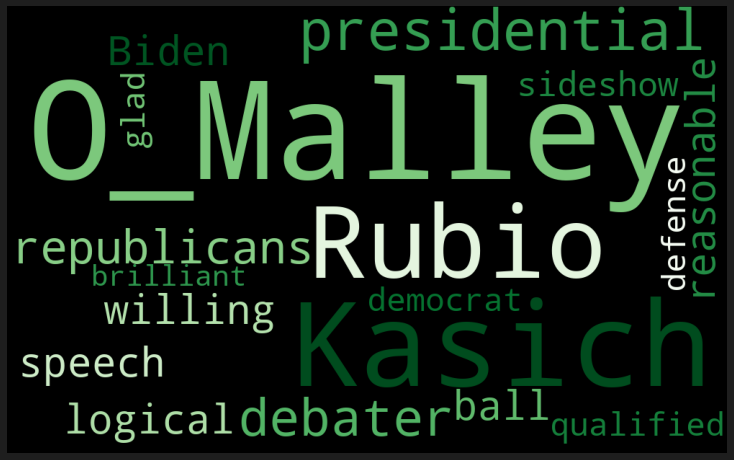

{'O_Malley': 1.0,
 'Kasich': 0.7142857142857143,
 'Rubio': 0.5,
 'presidential': 0.35714285714285715,
 'debater': 0.2857142857142857,
 'republicans': 0.2857142857142857,
 'Biden': 0.21428571428571427,
 'reasonable': 0.21428571428571427,
 'speech': 0.21428571428571427,
 'logical': 0.21428571428571427,
 'ball': 0.21428571428571427,
 'willing': 0.21428571428571427,
 'sideshow': 0.14285714285714285,
 'qualified': 0.14285714285714285,
 'glad': 0.14285714285714285,
 'democrat': 0.14285714285714285,
 'defense': 0.14285714285714285,
 'brilliant': 0.14285714285714285}

In [ ]:
words = wordcloud_lexeme(dataframe = data, lexeme_threshold = 50, analysis_for = 'support', cmap_wordcloud = 'Greens', count_threshold=3)
words

In [ ]:
attack_words_ethos = {'News': 1.0,
 'insane': 0.7777777777777778,
 'mouth': 0.7777777777777778,
 'rhetoric': 0.6666666666666666,
 'pharma': 0.6666666666666666,
 'scream': 0.6666666666666666,
 'constantly': 0.5555555555555556,
 'disrespectful': 0.5555555555555556,
 'clog': 0.5555555555555556,
 'screw': 0.4444444444444444,
 'directly': 0.4444444444444444,
 'establishment': 0.4444444444444444,
 'cult': 0.4444444444444444,
 'ramble': 0.4444444444444444,
 'shout': 0.3333333333333333,
 'dissonance': 0.3333333333333333,
 'professional': 0.3333333333333333,
 'breathe': 0.3333333333333333,
 'personality': 0.3333333333333333,
 'burn': 0.3333333333333333,
 'garbage': 0.3333333333333333,
 'adverse': 0.3333333333333333,
 'hammer': 0.3333333333333333,
 'robot': 0.3333333333333333,
 'perform': 0.3333333333333333,
 'idiot': 0.3333333333333333,
 'Putin': 0.3333333333333333,
 'rush': 0.3333333333333333,
 'gasp': 0.3333333333333333,
 'Romney': 0.3333333333333333,
 'left': 0.3333333333333333,
 'hypothetical': 0.3333333333333333}

In [ ]:
df_attack_words_ethos = pd.DataFrame({'word': attack_words_ethos.keys(), 'freq': attack_words_ethos.values()})
df_attack_words_ethos.head()

In [ ]:
support_words_ethos = {
 'presidential': 0.35714285714285715,
 'debater': 0.2857142857142857,
 'republicans': 0.2857142857142857,
 'reasonable': 0.21428571428571427,
 'speech': 0.21428571428571427,
 'logical': 0.21428571428571427,
 'ball': 0.21428571428571427,
 'willing': 0.21428571428571427,
 'sideshow': 0.14285714285714285,
 'qualified': 0.14285714285714285,
 'glad': 0.14285714285714285,
 'democrat': 0.14285714285714285,
 'defense': 0.14285714285714285,
 'brilliant': 0.14285714285714285}

In [ ]:
df_support_words_ethos = pd.DataFrame({'word': support_words_ethos.keys(), 'freq': support_words_ethos.values()})


In [ ]:
lep_lex = pd.concat([df_attack_words_ethos, df_attack_words_ethos], axis = 0, ignore_index=True)
#lep_lex = lep_lex.reset_index(drop=True)
lep_lex.shape

(64, 2)

In [ ]:
#lep_lex.to_excel("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/lepAnLexicon.xlsx")
lep_lex.tail()

,word,freq
59,rush,0.333333
60,gasp,0.333333
61,Romney,0.333333
62,left,0.333333
63,hypothetical,0.333333


#Resample 3-cat

In [ ]:
et.Ethos_Label.value_counts()

0    4650
2    1289
1     574
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos = et[et.Ethos_Label != 0]

neu_eth = et[ (et.Ethos_Label == 0) & (et.corpus.isna())].sample(n = 1500, random_state=3)

df_ethos = pd.concat([df_ethos, neu_eth], axis = 0)
df_ethos = df_ethos.reset_index(drop=True)
df_ethos.shape

(3363, 42)

In [ ]:
df_ethos.Ethos_Label.value_counts(normalize=True)

0    0.446030
2    0.383289
1    0.170681
Name: Ethos_Label, dtype: float64

#Train-Tet split

In [ ]:
#df_ethos['Text'] = df_ethos['Text'].str.lower()
df_ethos = clean_text(df_ethos, 'Text')
df_ethos.head()

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,expressed_sentiment,pathos_label,pathos_name,ethos_name,logos_name,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,Negative,1,positive,support,support,he's killing it,he be kill it,anger,NaN,NaN
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Positive,0,neutral,support,neutral,Sanders has some good points,sander have some good point,joy,NaN,NaN
2,10055,his delivery is not solid,berlinbrown,Sanders,0.0,1.0,0.0,1.0,2,1.0,...,Negative,0,neutral,attack,support,his delivery is not solid,his delivery be not solid,joy,NaN,NaN
3,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Positive,0,neutral,support,neutral,Sanders has some good points,sander have some good point,joy,NaN,NaN
4,10055,Clinton has pretty good delivery,berlinbrown,Clinton,0.0,1.0,1.0,0.0,1,1.0,...,Positive,0,neutral,support,support,Clinton has pretty good delivery,clinton have pretty good delivery,joy,NaN,NaN


In [ ]:
from sklearn.dummy import DummyClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, accuracy_score


In [ ]:
df_ethos.index

RangeIndex(start=0, stop=3363, step=1)

In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(2690, 673)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:
max(df_ethos.Text.str.split().map(len))

123

#Models

##m1

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel

checkpoint = "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFBertModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state
x = GlobalMaxPool1D()(embeddings)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

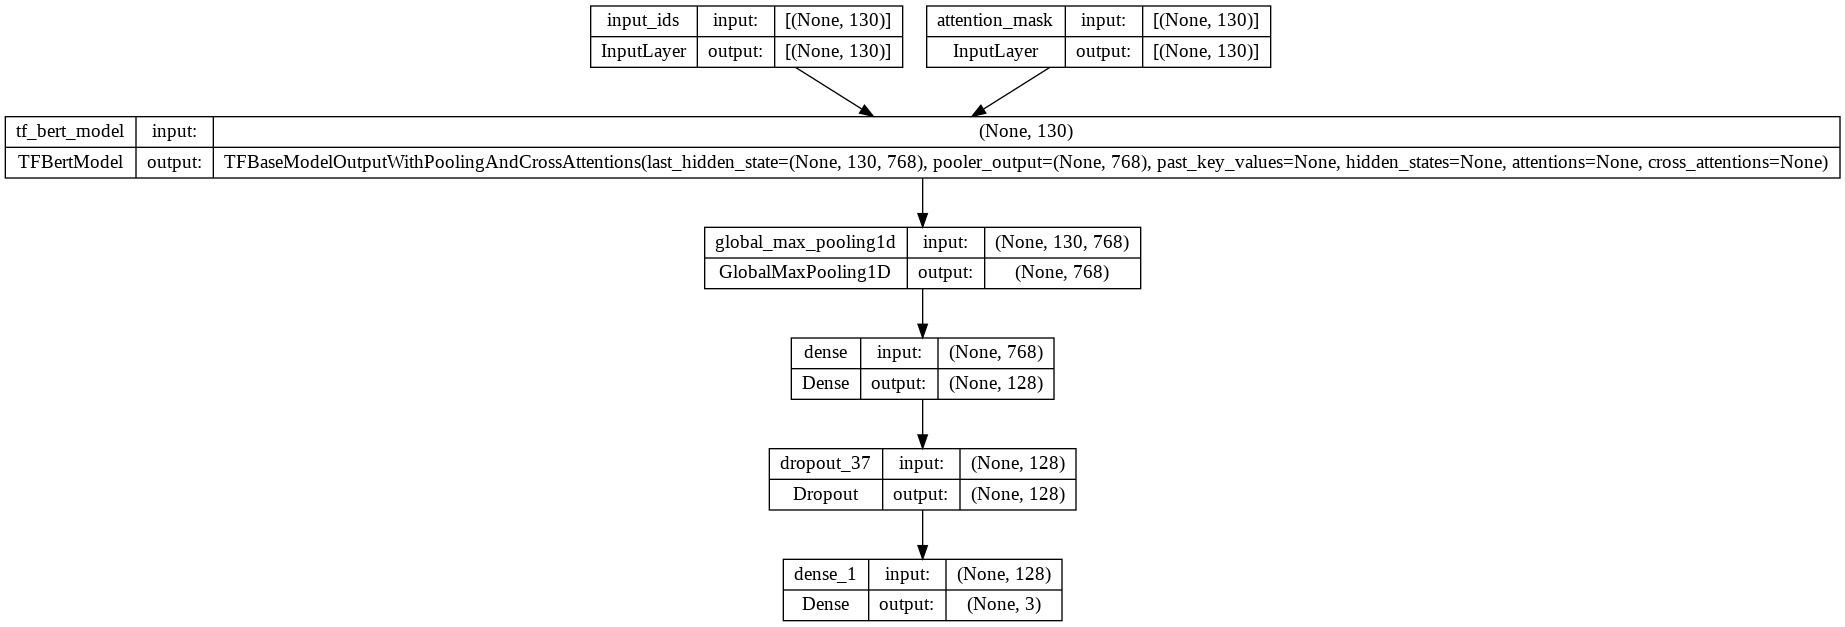

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                           

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 2e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 4

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

337/337 [==============================] - 93s 275ms/step - loss: 0.6000 - balanced_accuracy: 0.7602 - val_loss: 0.7433 - val_balanced_accuracy: 0.6716


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 6s 268ms/step


array([2, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.712     0.797     0.752       291
           1      0.573     0.504     0.536       117
           2      0.660     0.608     0.633       265

    accuracy                          0.672       673
   macro avg      0.648     0.636     0.640       673
weighted avg      0.667     0.672     0.668       673



##m2

###Add context from wikipedia

In [ ]:
!pip install wikipedia --quiet
import wikipedia

In [ ]:
# targets 3rd party entity

third_party_targets = ['BBC','CNN','Fauci','Pro-vaccinators','Reuters','Russians',
                       'Talkradio','The experts','Trump','USA','Vaccine industry','antivaxxers',
                       'big pharma','government','insurance companies','leftists','media','medics',
                       'obese people','politicians','pro-restriction','right wingers','scientists',
                       'sheeple','sick people','smokers','social media','the elderly','the elites',
                       'the rich','the unvaccinated','the vaccinated', 'Webb', 'Sanders', 'Clinton', 'Trump', 'Paul', 
                       'Romney', 'Obama', 'Cooper', 'Democrats', 'Russia', 'NATO', 'Republicans',
                       'O Malley', 'BLM', 'CNN', 'Chafee', 'Bush', 'Snowden', 'the Times', 'Huckabee', 
                       'Christie', 'Joe Rogan', 'John Oliver', 'Sarah Palin', 'Fox News', 'Kasich', 
                       'Perry', 'Rubio', 'Cruz', 'Kelly','Carson', 'Facebook', 'Walker', 'Left', 
                       'Conservatives', 'Trudeau', 'Bill Clinton', 'Holt', 'McCain',  'Biden', 'GOP']

In [ ]:
data3rd = et[et.Target.isin(third_party_targets)]
data3rd.shape

(1480, 4)

In [ ]:
third_party_targets[-5:]

['Bill Clinton', 'Holt', 'McCain', 'Biden', 'GOP']

In [ ]:
data3rd_dict_seq2 = {}

for t in third_party_targets:
  lits_results = wikipedia.search(str(t), 3)
  print(f'{t}: {lits_results} \n')
  try:
    summ = wikipedia.summary(lits_results[0], sentences = 5)
    data3rd_dict_seq2[t] = summ
  except:
    data3rd_dict_seq2[t] = " "

  
data3rd_dict_seq2

In [ ]:
# man ajust some

data3rd_dict_seq2['BBC'] = wikipedia.summary('BBC News', sentences = 5)
data3rd_dict_seq2['CNN'] = wikipedia.summary('CNN International', sentences = 5)
data3rd_dict_seq2['Fauci'] = wikipedia.summary('Anthony Stephen Fauci', sentences = 5)
data3rd_dict_seq2['Vaccine'] = wikipedia.summary('Vaccine', sentences = 5)
data3rd_dict_seq2['big pharma'] = wikipedia.summary('Big Pharma conspiracy theories', sentences = 5)
data3rd_dict_seq2['media'] = wikipedia.summary('Media (communication)', sentences = 5)
data3rd_dict_seq2['medics'] = wikipedia.summary('the Medics', sentences = 5)
data3rd_dict_seq2['obese people'] = wikipedia.summary('Obesity in the United States', sentences = 5)
data3rd_dict_seq2['pro-restriction'] = wikipedia.summary('COVID-19 pandemic', sentences = 5)
data3rd_dict_seq2['smokers'] = wikipedia.summary('Tobacco smoking', sentences = 5)
data3rd_dict_seq2['the elderly'] = wikipedia.summary('Elderly care', sentences = 5)
data3rd_dict_seq2['the elites'] = wikipedia.summary('Elite theory', sentences = 5)

data3rd_dict_seq2['Webb'] = wikipedia.summary('James Henry Webb', sentences = 5)
data3rd_dict_seq2['Sanders'] = wikipedia.summary('Bernie Sanders', sentences = 5)
data3rd_dict_seq2['Clinton'] = wikipedia.summary('Hilary Clinton', sentences = 5)
data3rd_dict_seq2['Paul'] = wikipedia.summary('Randal Howard Paul', sentences = 5)
data3rd_dict_seq2['Cooper'] = wikipedia.summary('Anderson Hays Cooper', sentences = 5)
data3rd_dict_seq2['Democrats'] = wikipedia.summary('Democratic Party (United States)', sentences = 5)
data3rd_dict_seq2['BLM'] = wikipedia.summary('Black Lives Matter movement', sentences = 5)
data3rd_dict_seq2['O Malley'] = wikipedia.summary("Martin O'Malley", sentences = 5)
data3rd_dict_seq2['Bush'] = wikipedia.summary('John Ellis "Jeb" Bush', sentences = 5)
data3rd_dict_seq2['Snowden'] = wikipedia.summary('Edward Snowden', sentences = 5)
data3rd_dict_seq2['the Times'] = wikipedia.summary('The Times newspaper', sentences = 5)

data3rd_dict_seq2['Fox News'] = wikipedia.summary('Fox News Channel', sentences = 5)
data3rd_dict_seq2['Rubio'] = wikipedia.summary('Marco Rubio senator', sentences = 5)

data3rd_dict_seq2['Biden'] = wikipedia.summary('Joe Biden president', sentences = 5)
data3rd_dict_seq2['McCain'] = wikipedia.summary('John McCain politician', sentences = 5)


In [ ]:
for t in et[ ~(et.Target.isin(third_party_targets)) ].Target.unique():
  data3rd_dict_seq2[t] = " "

et['seq2'] = np.nan

In [ ]:
et.loc[et.Target == 'Biden']

,Text,Source,Target,Ethos_Label,seq2
4045,For most entertaining I would go with Joe Biden,bigbendalibra,Biden,1.0,NaN
4046,"even better, Biden",Johner1261,Biden,1.0,NaN


In [ ]:
for t in et.Target.unique():
  ids = et.loc[et.Target == t].index
  et.loc[ids, 'seq2'] = data3rd_dict_seq2[t]

et.loc[et.Target == 'Biden']

,Text,Source,Target,Ethos_Label,seq2
4045,For most entertaining I would go with Joe Biden,bigbendalibra,Biden,1.0,"Joseph Robinette Biden Jr. ( (listen) BY-dən; born November 20, 1942) is an American politician who is the 46th and current president of the United States. ..."
4046,"even better, Biden",Johner1261,Biden,1.0,"Joseph Robinette Biden Jr. ( (listen) BY-dən; born November 20, 1942) is an American politician who is the 46th and current president of the United States. ..."


In [ ]:
wikipedia.summary('John McCain politician', sentences = 5)

'John Sidney McCain III (August 29, 1936 – August 25, 2018) was an American politician and United States Navy officer who served as a United States senator from Arizona from 1987 until his death in 2018. He previously served two terms in the United States House of Representatives and was the Republican nominee for president of the United States in the 2008 election, which he lost to Barack Obama.\nMcCain graduated from the United States Naval Academy in 1958 and received a commission in the United States Navy. He became a naval aviator and flew ground-attack aircraft from aircraft carriers. During the Vietnam War, McCain almost died in the 1967 USS Forrestal fire.'

In [ ]:
wikipedia.search("Fox News", 9)

['Fox News',
 'Fox News controversies',
 'Fox News Sunday',
 'Fox News @ Night',
 'Fox News (disambiguation)',
 'List of programs broadcast by Fox News Channel',
 'History of Fox News',
 'Fox Broadcasting Company',
 'Fox News Radio']

In [ ]:
et.shapee

(6513, 5)

In [ ]:
et.head()

,Text,Source,Target,Ethos_Label,seq2
0,Please someone tell me I'm wrong,Emerica,NaN,0.0,
1,"Take the people who are Bernie supporters, some jump to Webb",Emerica,NaN,0.0,
2,he's killing it,Emerica,Webb,1.0,"James Henry Webb Jr. (born February 9, 1946) is an American politician and author. He has served as a United States senator from Virginia, Secretary of the ..."
3,Hillary supporters stay,Emerica,NaN,0.0,
4,she ends up ahead,Emerica,NaN,0.0,


###Load wiki data

In [ ]:
#et.to_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining_seq2DATA.csv")

et = load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining_seq2DATA.csv")
et.shape

(6513, 5)

In [ ]:
et['seq2'] = et['seq2'].fillna(" ")

In [ ]:
max(et.seq2.str.split().map(len)), max(et.Text.str.split().map(len)), max(et.seq2.str.split().map(len)) + max(et.Text.str.split().map(len))

(235, 124, 359)

In [ ]:
et.tail(2)

,Text,Source,Target,Ethos_Label,seq2
6511,unless I sit on you,twitchspank,NaN,0.0,
6512,you being unvaccinated can increase my chances...,twitchspank,the unvaccinated,2.0,The COVID-19 pandemic in the United States is ...


In [ ]:
et.Ethos_Label.value_counts()

0.0    4650
2.0    1289
1.0     574
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos = et[et.Ethos_Label != 0]

neu_eth = et[et.Ethos_Label == 0].sample(n = 1500, random_state=3)

df_ethos = pd.concat([df_ethos, neu_eth], axis = 0)
df_ethos = df_ethos.reset_index(drop=True)
df_ethos.shape

In [ ]:
df_ethos.Ethos_Label.value_counts()

0.0    1500
2.0    1289
1.0     574
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos = clean_text(df_ethos, 'Text')

In [ ]:
df_ethos.index

RangeIndex(start=0, stop=3363, step=1)

In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(2690, 673)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:
max_len = 375


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel

checkpoint = "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFBertModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [ ]:
# 2 seq

x_train = tokenizer(text_pair = df_ethos_tr.Text.tolist(),
                    text = df_ethos_tr.seq2.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text_pair = df_ethos_ts.Text.tolist(), 
                   text = df_ethos_ts.seq2.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state
x = GlobalMaxPool1D()(embeddings)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state v2
x = GlobalMaxPool1D()(embeddings)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

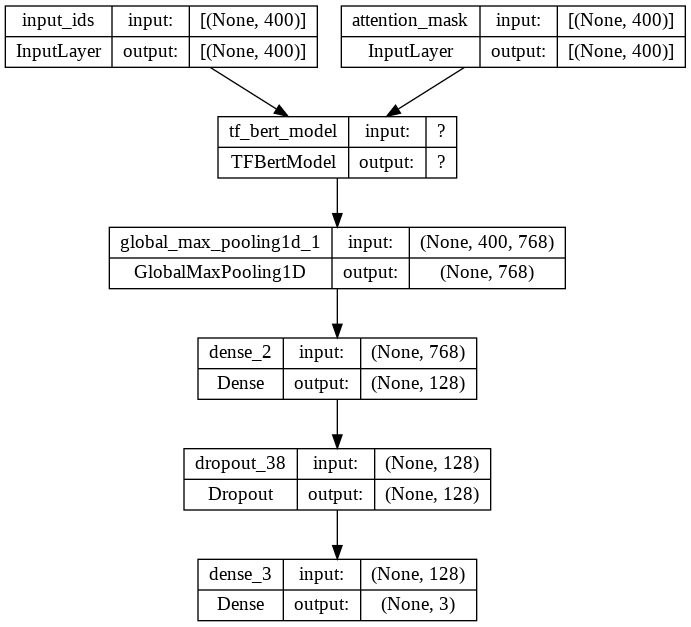

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 400)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             108310272   ['input_ids[0][0]',              
                                                                  'attention_mask[0][0]']         
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 768)         0           ['tf_bert_model[1][0]']    

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 4e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/3


337/337 [==============================] - 292s 804ms/step - loss: 0.6073 - balanced_accuracy: 0.7312 - val_loss: 0.5380 - val_balanced_accuracy: 0.7682
Epoch 2/3
337/337 [==============================] - 268s 796ms/step - loss: 0.3793 - balanced_accuracy: 0.8424 - val_loss: 0.5522 - val_balanced_accuracy: 0.7801
Epoch 3/3
337/337 [==============================] - 268s 796ms/step - loss: 0.2435 - balanced_accuracy: 0.9067 - val_loss: 0.6086 - val_balanced_accuracy: 0.7415


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 22s 853ms/step


array([2, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

         0.0      0.843     0.869     0.856       291
         1.0      0.519     0.684     0.590       117
         2.0      0.758     0.626     0.686       265

    accuracy                          0.741       673
   macro avg      0.707     0.727     0.711       673
weighted avg      0.753     0.741     0.743       673



##m3

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "finiteautomata/bertweet-base-sentiment-analysis" 

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some layers from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaModel were not initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-st

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

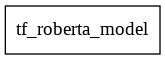

In [ ]:
tf.keras.utils.plot_model(bert, show_shapes = True)

In [ ]:
''' for sentiment model
"finiteautomata/bertweet-base-sentiment-analysis"

"id2label": {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
    
    '''

df_ethos_tr['label'] = df_ethos_tr['Ethos_Label'].map({0:1, 1: 2, 2:0})
df_ethos_ts['label'] = df_ethos_ts['Ethos_Label'].map({0:1, 1: 2, 2:0})    

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(hil2.Text.str.split().map(len))

47

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
 # pooler

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1]
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
# last hidden state

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] 
x = GlobalMaxPool1D()(embeddings)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

In [ ]:
model.layers

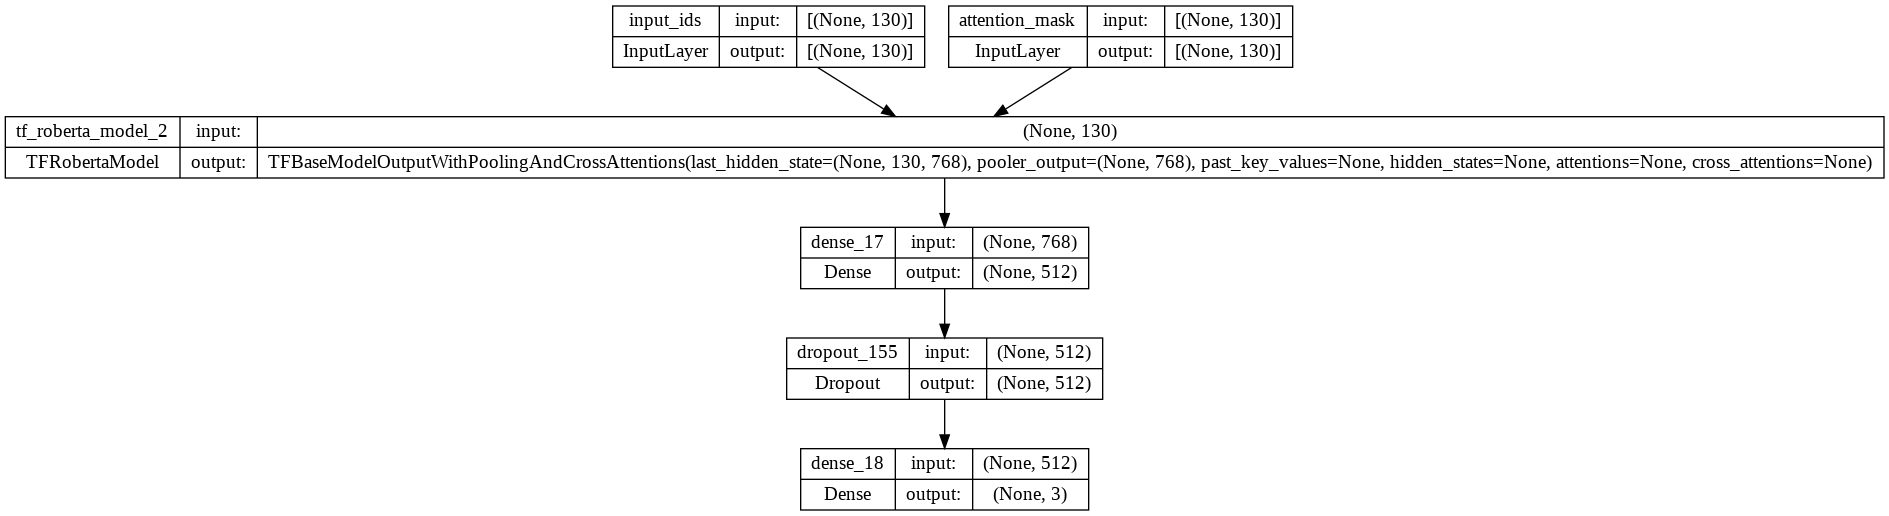

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # pooler

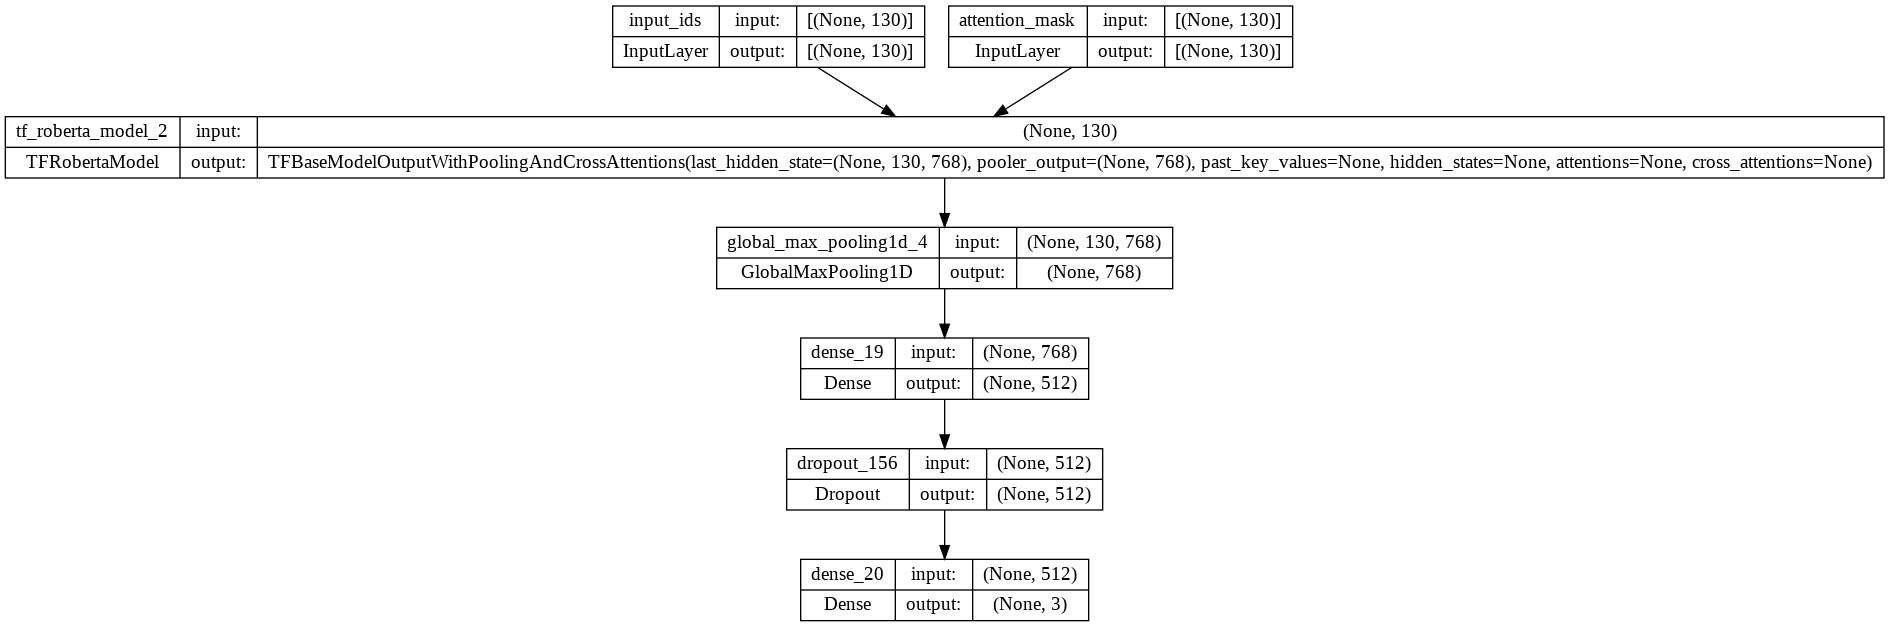

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # last hidden

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pooler 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # hidden train 2

Epoch 1/2


337/337 [==============================] - 125s 293ms/step - loss: 0.5632 - balanced_accuracy: 0.7955 - val_loss: 0.5693 - val_balanced_accuracy: 0.7890
Epoch 2/2
337/337 [==============================] - 95s 282ms/step - loss: 0.3696 - balanced_accuracy: 0.8818 - val_loss: 0.5888 - val_balanced_accuracy: 0.7845


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer
y_pred = np.argmax(predicted, axis = -1)
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 

22/22 [==============================] - 11s 264ms/step
              precision    recall  f1-score   support

           0      0.815     0.773     0.794       291
           1      0.649     0.632     0.641       117
           2      0.710     0.758     0.734       265

    accuracy                          0.743       673
   macro avg      0.725     0.721     0.723       673
weighted avg      0.745     0.743     0.743       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# last hidden 

              precision    recall  f1-score   support

           0      0.733     0.736     0.734       265
           1      0.773     0.821     0.797       291
           2      0.724     0.607     0.660       117

    accuracy                          0.750       673
   macro avg      0.744     0.721     0.731       673
weighted avg      0.749     0.750     0.748       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# last hidden 3

              precision    recall  f1-score   support

           0      0.834     0.845     0.840       291
           1      0.708     0.641     0.673       117
           2      0.761     0.781     0.771       265

    accuracy                          0.785       673
   macro avg      0.767     0.756     0.761       673
weighted avg      0.783     0.785     0.784       673



In [ ]:
hil2['ethos_pooler'] = y_pred
hil2.to_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hilary_Tweets_Ethos.xlsx')
hil2.tail(2)

,idx,Tweet ID,tweet,Date Created,Tweet,Polarity,Subjectivity,Retweets,Favorites,User ID,User Name,Text,ethos,ethos_pooler
7679,3198,772963506127765505,"""the essence of his campaign is bigotry.""",2016-09-06,"""The essence of his campaign is bigotry."" —@Be...",0.0,0.0,2584,6060,1339835893,Hillary Clinton,"""the essence of his campaign is bigotry.""",2,1
7680,3198,772963506127765505,—@berniesanders on donald trump in new hampshi...,2016-09-06,"""The essence of his campaign is bigotry."" —@Be...",0.0,0.0,2584,6060,1339835893,Hillary Clinton,user on donald trump in new hampshire url,0,0


In [ ]:
hil2.iloc[:, -2].value_counts(normalize=True)

0    0.686629
1    0.173545
2    0.139826
Name: ethos, dtype: float64

In [ ]:
hil2.iloc[:, -1].value_counts(normalize=True)

0    0.664236
1    0.202317
2    0.133446
Name: ethos_pooler, dtype: float64

In [ ]:
metrics.accuracy_score(hil2.iloc[:, -2].values, hil2.iloc[:, -1].values)

0.9315193334201276

In [ ]:
metrics.cohen_kappa_score(hil2.iloc[:, -2].values, hil2.iloc[:, -1].values)

0.8602849950865361

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# pooler 3

              precision    recall  f1-score   support

           0      0.860     0.821     0.840       291
           1      0.650     0.684     0.667       117
           2      0.768     0.789     0.778       265

    accuracy                          0.785       673
   macro avg      0.760     0.765     0.762       673
weighted avg      0.787     0.785     0.786       673



##m3 vol.2

In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

#checkpoint = "cardiffnlp/twitter-roberta-base-sentiment-latest" 
checkpoint = 'finiteautomata/bertweet-base-sentiment-analysis'
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
''' 
"finiteautomata/bertweet-base-sentiment-analysis"

"id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
'''
df_ethos_tr['label'] = df_ethos_tr['Ethos_Label'].map({0:1, 1: 2, 2:0})
df_ethos_ts['label'] = df_ethos_ts['Ethos_Label'].map({0:1, 1: 2, 2:0})    

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(hil2.Text.str.split().map(len))

47

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
model.layers

In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy(from_logits = True) #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) 

Epoch 1/2
337/337 [==============================] - 124s 289ms/step - loss: 0.7702 - balanced_accuracy: 0.6770 - val_loss: 0.6898 - val_balanced_accuracy: 0.7340
Epoch 2/2
337/337 [==============================] - 95s 283ms/step - loss: 0.5421 - balanced_accuracy: 0.7948 - val_loss: 0.7004 - val_balanced_accuracy: 0.7340


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer
#y_pred = np.argmax(predicted, axis = -1)

softmax = tf.nn.softmax(predicted[0])
y_pred = np.argmax(softmax, axis = -1)
print(metrics.f1_score(df_ethos_ts.label.tolist(), y_pred, average='macro')) 

22/22 [==============================] - 12s 277ms/step
0.7014404338247755


In [ ]:
print(metrics.classification_report(df_ethos_ts.label.tolist(), y_pred, digits=3)) 
# cardiffnlp/twitter-roberta-base-sentiment-latest

              precision    recall  f1-score   support

           0      0.733     0.736     0.734       265
           1      0.790     0.787     0.788       291
           2      0.615     0.615     0.615       117

    accuracy                          0.737       673
   macro avg      0.713     0.713     0.713       673
weighted avg      0.737     0.737     0.737       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.label.tolist(), y_pred, digits=3)) 
# 'finiteautomata/bertweet-base-sentiment-analysis'

              precision    recall  f1-score   support

           0      0.705     0.785     0.743       265
           1      0.819     0.763     0.790       291
           2      0.598     0.547     0.571       117

    accuracy                          0.734       673
   macro avg      0.707     0.698     0.701       673
weighted avg      0.736     0.734     0.733       673



In [ ]:
hil2['ethos_pooler'] = y_pred
hil2.to_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hilary_Tweets_Ethos.xlsx')
hil2.tail(2)

In [ ]:
hil2.iloc[:, -2].value_counts(normalize=True)

In [ ]:
hil2.iloc[:, -1].value_counts(normalize=True)

In [ ]:
metrics.accuracy_score(hil2.iloc[:, -2].values, hil2.iloc[:, -1].values)

In [ ]:
metrics.cohen_kappa_score(hil2.iloc[:, -2].values, hil2.iloc[:, -1].values)

##m3.2 sent


In [ ]:
max_len = 130

from transformers import pipeline

check = "siebert/sentiment-roberta-large-english"
sentiment_analysis = pipeline("sentiment-analysis", model=check, device=0)

result_tr = sentiment_analysis(df_ethos_tr.Text.tolist())
result_ts = sentiment_analysis(df_ethos_ts.Text.tolist())

In [ ]:
result_tr[:4]

[{'label': 'POSITIVE', 'score': 0.9988620281219482},
 {'label': 'POSITIVE', 'score': 0.985237181186676},
 {'label': 'POSITIVE', 'score': 0.5944963097572327},
 {'label': 'NEGATIVE', 'score': 0.9973949193954468}]

In [ ]:
df_ethos_tr['senti'] = [x['label'] for x in result_tr]
df_ethos_ts['senti'] = [x['label'] for x in result_ts]
df_ethos_tr['senti'].value_counts(normalize=True).round(3)

NEGATIVE    0.641
POSITIVE    0.359
Name: senti, dtype: float64

In [ ]:
df_ethos_tr['senti'] = df_ethos_tr['senti'].map({'NEGATIVE':0, 'POSITIVE':1})
df_ethos_ts['senti'] = df_ethos_ts['senti'].map({'NEGATIVE':0, 'POSITIVE':1})

In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(hil2.Text.str.split().map(len))

47

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# pool 2 as in 3.3 emo

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)

x1 = Dense(246, activation = 'relu')(x)
x2 = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x2)
x = tf.keras.layers.Concatenate(axis=1)([x, x1])
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x2)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

In [ ]:
# pool  - reported

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)

x1 = Dense(128, activation = 'relu')(x)
x2 = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x2)
x = Dropout(0.3)(x2)
x = tf.keras.layers.Concatenate(axis=1)([x, x1])
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x2)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

In [ ]:
model.layers

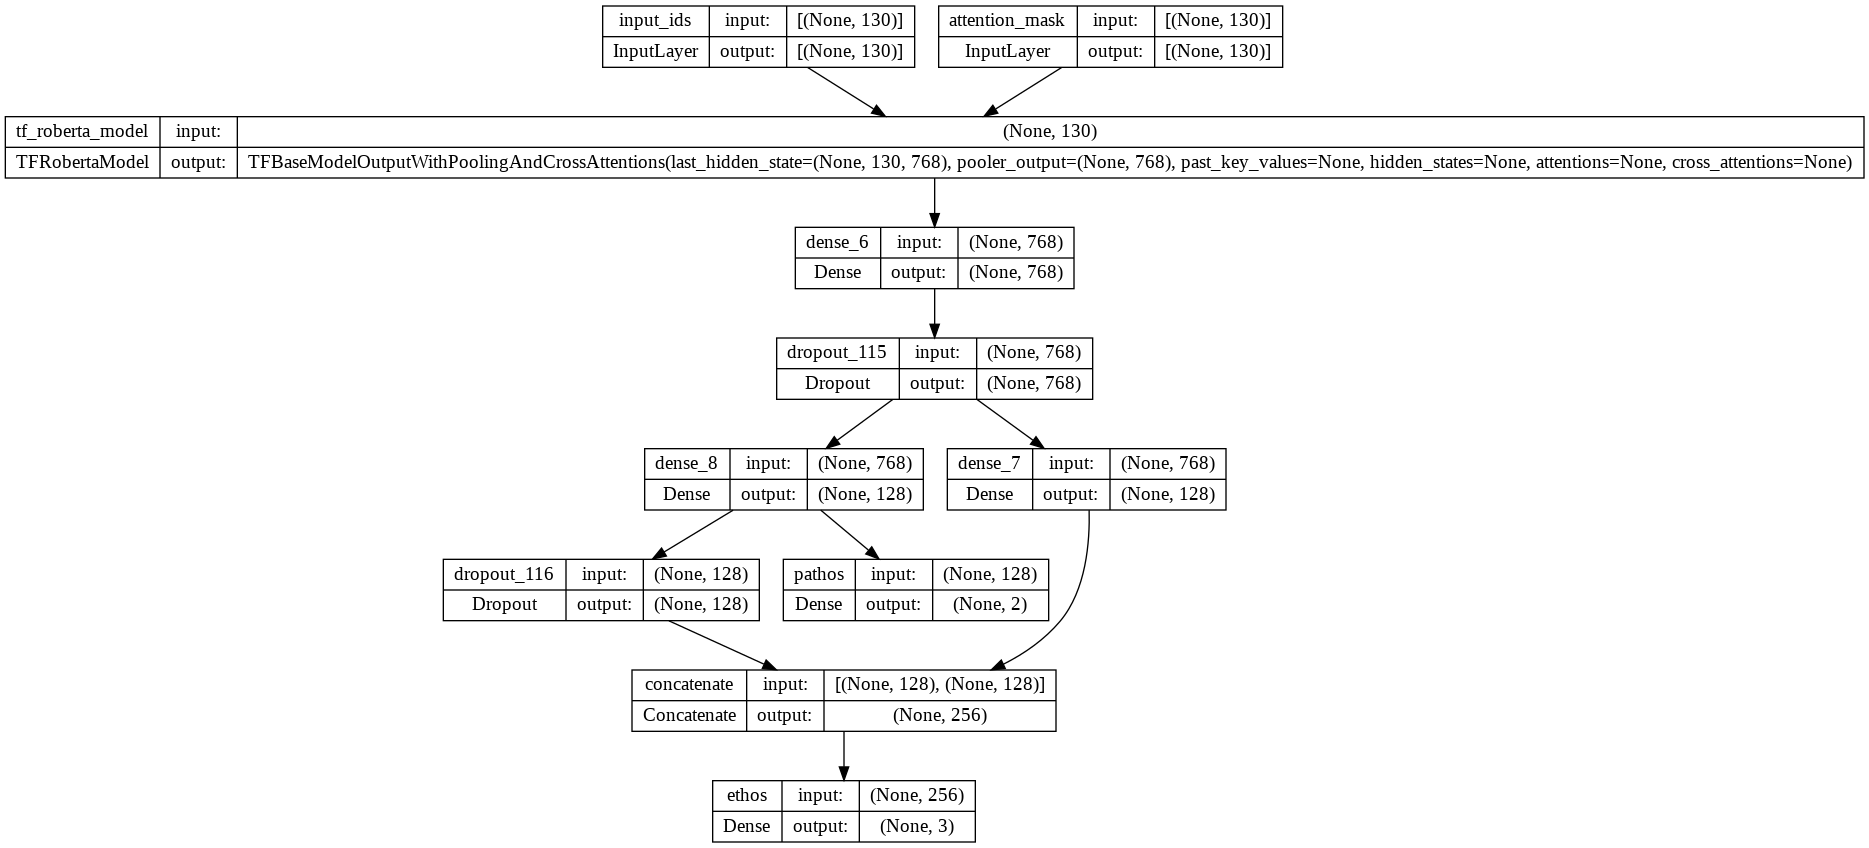

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # pool 2

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

#model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.senti.tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.senti.tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pooler

Epoch 1/2
337/337 [==============================] - 138s 313ms/step - loss: 1.5137 - ethos_loss: 0.9073 - pathos_loss: 0.6063 - ethos_balanced_accuracy: 0.5736 - pathos_balanced_accuracy: 0.6803 - val_loss: 1.1480 - val_ethos_loss: 0.7082 - val_pathos_loss: 0.4398 - val_ethos_balanced_accuracy: 0.7207 - val_pathos_balanced_accuracy: 0.8098
Epoch 2/2
337/337 [==============================] - 100s 296ms/step - loss: 1.0968 - ethos_loss: 0.6789 - pathos_loss: 0.4179 - ethos_balanced_accuracy: 0.7346 - pathos_balanced_accuracy: 0.8253 - val_loss: 1.0609 - val_ethos_loss: 0.6665 - val_pathos_loss: 0.3944 - val_ethos_balanced_accuracy: 0.7281 - val_pathos_balanced_accuracy: 0.8291


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.senti.tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.senti.tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2

Epoch 1/2
337/337 [==============================] - 128s 283ms/step - loss: 0.8772 - ethos_loss: 0.5848 - pathos_loss: 0.2924 - ethos_balanced_accuracy: 0.7877 - pathos_balanced_accuracy: 0.8948 - val_loss: 1.1016 - val_ethos_loss: 0.6806 - val_pathos_loss: 0.4211 - val_ethos_balanced_accuracy: 0.7415 - val_pathos_balanced_accuracy: 0.8351
Epoch 2/2
337/337 [==============================] - 94s 278ms/step - loss: 0.5966 - ethos_loss: 0.4082 - pathos_loss: 0.1884 - ethos_balanced_accuracy: 0.8550 - pathos_balanced_accuracy: 0.9398 - val_loss: 1.1324 - val_ethos_loss: 0.7137 - val_pathos_loss: 0.4187 - val_ethos_balanced_accuracy: 0.7533 - val_pathos_balanced_accuracy: 0.8440


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.senti.tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.senti.tolist())} ), 
                    epochs = 3, 
                    batch_size = batch_size, verbose = 1) # pool 2 - 3.3 emo

337/337 [==============================] - 93s 275ms/step - loss: 0.8974 - ethos_loss: 0.5812 - pathos_loss: 0.3162 - ethos_balanced_accuracy: 0.7911 - pathos_balanced_accuracy: 0.8792 - val_loss: 1.0617 - val_ethos_loss: 0.6641 - val_pathos_loss: 0.3976 - val_ethos_balanced_accuracy: 0.7400 - val_pathos_balanced_accuracy: 0.8336


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# multi-task
y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # Sentimet
y_pred[:5], y_pred2[:5]

22/22 [==============================] - 6s 246ms/step


(array([2, 0, 2, 1, 2]), array([0, 0, 0, 1, 0]))

In [ ]:
# pooler

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Sentimet\n', metrics.classification_report(df_ethos_ts.senti.tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.796     0.780     0.788       291
           1      0.552     0.726     0.627       117
           2      0.761     0.672     0.713       265

    accuracy                          0.728       673
   macro avg      0.703     0.726     0.710       673
weighted avg      0.740     0.728     0.731       673

Sentimet
               precision    recall  f1-score   support

           0      0.897     0.824     0.859       425
           1      0.735     0.839     0.783       248

    accuracy                          0.829       673
   macro avg      0.816     0.831     0.821       673
weighted avg      0.838     0.829     0.831       673



In [ ]:
# pool 2

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Sentimet\n', metrics.classification_report(df_ethos_ts.senti.tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.823     0.814     0.819       291
           1      0.589     0.650     0.618       117
           2      0.758     0.732     0.745       265

    accuracy                          0.753       673
   macro avg      0.723     0.732     0.727       673
weighted avg      0.757     0.753     0.755       673

Sentimet
               precision    recall  f1-score   support

           0      0.870     0.885     0.877       425
           1      0.797     0.774     0.785       248

    accuracy                          0.844       673
   macro avg      0.834     0.829     0.831       673
weighted avg      0.843     0.844     0.844       673



In [ ]:
# pool 2 3.3 emo

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Sentimet\n', metrics.classification_report(df_ethos_ts.senti.tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.787     0.787     0.787       291
           1      0.652     0.624     0.638       117
           2      0.726     0.740     0.733       265

    accuracy                          0.740       673
   macro avg      0.722     0.717     0.719       673
weighted avg      0.739     0.740     0.740       673

Sentimet
               precision    recall  f1-score   support

           0      0.847     0.899     0.872       425
           1      0.806     0.722     0.762       248

    accuracy                          0.834       673
   macro avg      0.827     0.810     0.817       673
weighted avg      0.832     0.834     0.831       673



##m3.3 emo

In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel
from transformers import pipeline

check = "j-hartmann/emotion-english-distilroberta-base"
#check = "bhadresh-savani/distilbert-base-uncased-emotion"
sentiment_analysis = pipeline("text-classification", model=check, device=0)

result_tr = sentiment_analysis(df_ethos_tr.Text.tolist())
result_ts = sentiment_analysis(df_ethos_ts.Text.tolist())

In [ ]:
df_ethos_tr['emo'] = [x['label'] for x in result_tr]
df_ethos_ts['emo'] = [x['label'] for x in result_ts]

In [ ]:
#check = "j-hartmann/emotion-english-distilroberta-base"

df_ethos_tr['emo'].value_counts(normalize=True).round(3)

neutral     0.591
anger       0.130
disgust     0.080
surprise    0.074
sadness     0.052
joy         0.045
fear        0.028
Name: emo, dtype: float64

In [ ]:
#check = "bhadresh-savani/distilbert-base-uncased-emotion"

df_ethos_tr['emo'].value_counts(normalize=True).round(3)

anger       0.504
joy         0.366
sadness     0.072
fear        0.042
love        0.009
surprise    0.006
Name: emo, dtype: float64

In [ ]:
#check = "j-hartmann/emotion-english-distilroberta-base"

df_ethos_ts['emo'].value_counts(normalize=True).round(3)

neutral     0.585
anger       0.111
surprise    0.083
disgust     0.083
joy         0.062
sadness     0.048
fear        0.027
Name: emo, dtype: float64

In [ ]:
#check = "bhadresh-savani/distilbert-base-uncased-emotion"

df_ethos_ts['emo'].value_counts(normalize=True).round(3)

anger       0.514
joy         0.334
sadness     0.083
fear        0.043
love        0.016
surprise    0.009
Name: emo, dtype: float64

In [ ]:
max_len = 130
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(hil2.Text.str.split().map(len))

47

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# pool 2

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)

x1 = Dense(246, activation = 'relu')(x)
x2 = Dense(246, activation = 'relu')(x)
#x = Dense(128, activation = 'relu')(x2)
x = Dropout(0.3)(x2)
x = tf.keras.layers.Concatenate(axis=1)([x, x1])
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(7, activation = 'softmax', name = 'pathos')(x2)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

In [ ]:
model.layers

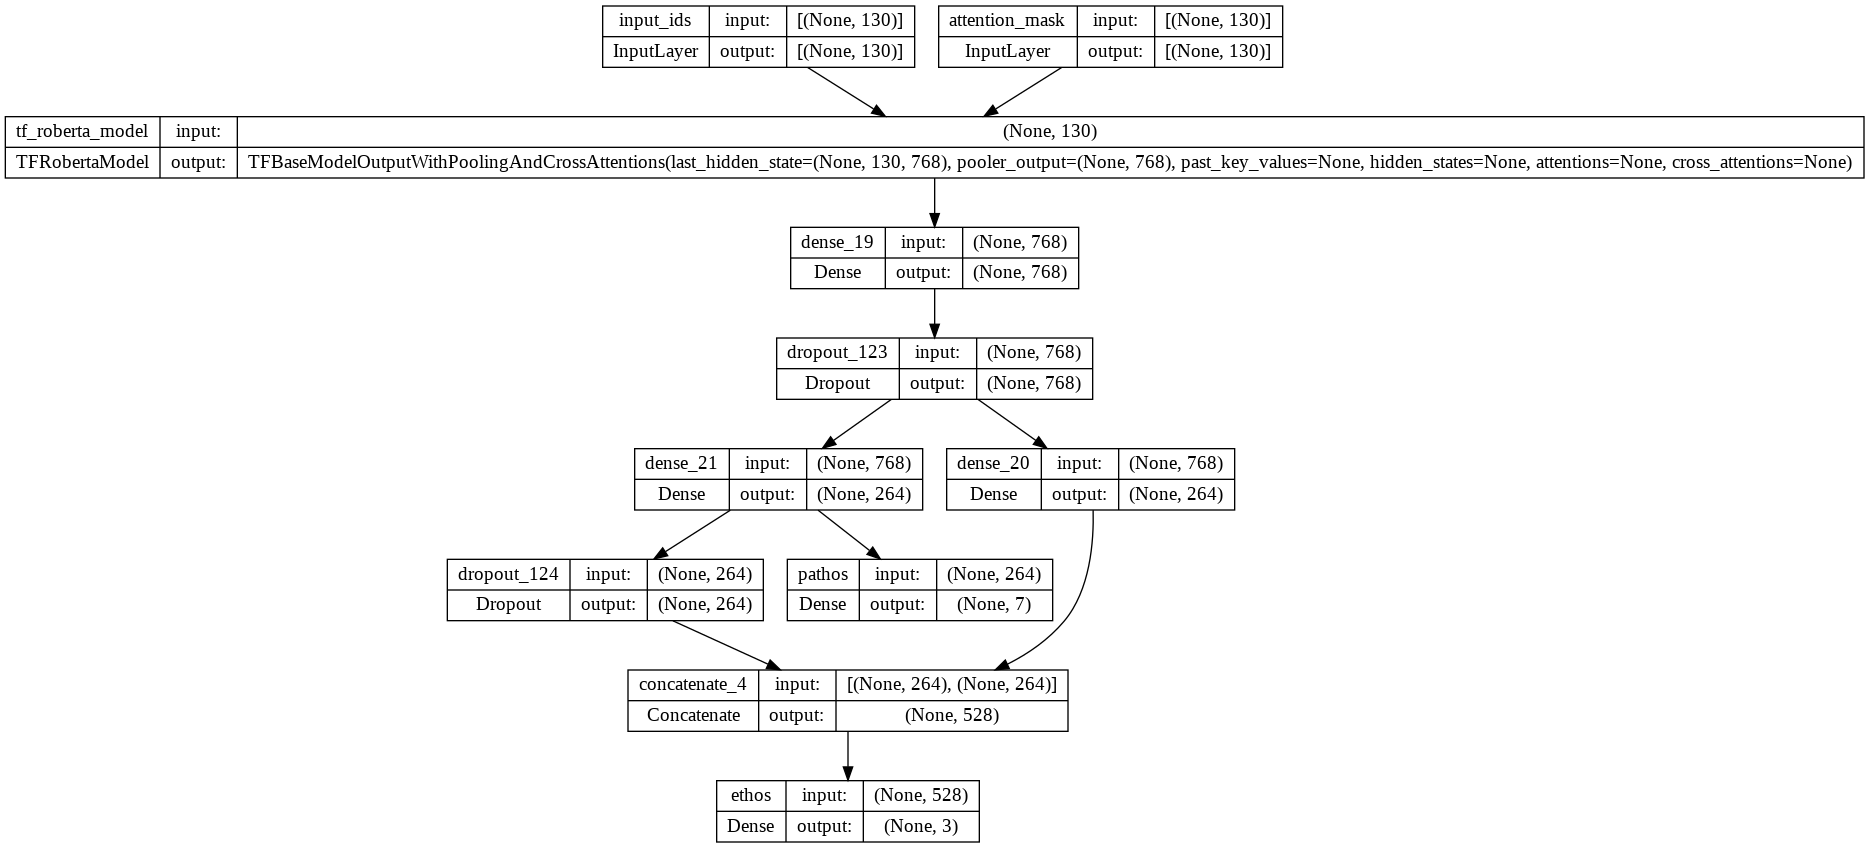

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # pooler 2

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

#model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
label2id ={
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6
  }

In [ ]:
# "bhadresh-savani/distilbert-base-uncased-emotion"

label2id ={
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  }

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.emo.map(label2id).tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.emo.map(label2id).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2

Epoch 1/2
337/337 [==============================] - 141s 310ms/step - loss: 1.8178 - ethos_loss: 0.4641 - pathos_loss: 1.3537 - ethos_balanced_accuracy: 0.8375 - pathos_balanced_accuracy: 0.5829 - val_loss: 1.9626 - val_ethos_loss: 0.7030 - val_pathos_loss: 1.2595 - val_ethos_balanced_accuracy: 0.7563 - val_pathos_balanced_accuracy: 0.5854
Epoch 2/2
337/337 [==============================] - 100s 297ms/step - loss: 1.5507 - ethos_loss: 0.2950 - pathos_loss: 1.2557 - ethos_balanced_accuracy: 0.9019 - pathos_balanced_accuracy: 0.5929 - val_loss: 1.9524 - val_ethos_loss: 0.7314 - val_pathos_loss: 1.2210 - val_ethos_balanced_accuracy: 0.7608 - val_pathos_balanced_accuracy: 0.5914


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.emo.map(label2id).tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.emo.map(label2id).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2

Epoch 1/2
337/337 [==============================] - 113s 283ms/step - loss: 1.5884 - ethos_loss: 0.2770 - pathos_loss: 1.3114 - ethos_balanced_accuracy: 0.9275 - pathos_balanced_accuracy: 0.5892 - val_loss: 2.0360 - val_ethos_loss: 0.8206 - val_pathos_loss: 1.2154 - val_ethos_balanced_accuracy: 0.7608 - val_pathos_balanced_accuracy: 0.6003
Epoch 2/2
337/337 [==============================] - 94s 279ms/step - loss: 1.3345 - ethos_loss: 0.1386 - pathos_loss: 1.1959 - ethos_balanced_accuracy: 0.9647 - pathos_balanced_accuracy: 0.6067 - val_loss: 2.0199 - val_ethos_loss: 0.8658 - val_pathos_loss: 1.1541 - val_ethos_balanced_accuracy: 0.7533 - val_pathos_balanced_accuracy: 0.6107


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.emo.map(label2id).tolist()) } , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.emo.map(label2id).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2  "bhadresh-savani/distilbert-base-uncased-emotion"

Epoch 1/2
337/337 [==============================] - 129s 299ms/step - loss: 1.4483 - ethos_loss: 0.3419 - pathos_loss: 1.1064 - ethos_balanced_accuracy: 0.8926 - pathos_balanced_accuracy: 0.5617 - val_loss: 1.8339 - val_ethos_loss: 0.7747 - val_pathos_loss: 1.0591 - val_ethos_balanced_accuracy: 0.7593 - val_pathos_balanced_accuracy: 0.6077
Epoch 2/2
337/337 [==============================] - 97s 289ms/step - loss: 1.1823 - ethos_loss: 0.1831 - pathos_loss: 0.9991 - ethos_balanced_accuracy: 0.9468 - pathos_balanced_accuracy: 0.6182 - val_loss: 1.8682 - val_ethos_loss: 0.8446 - val_pathos_loss: 1.0236 - val_ethos_balanced_accuracy: 0.7504 - val_pathos_balanced_accuracy: 0.6241


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# multi-task
y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

22/22 [==============================] - 10s 255ms/step


(array([1, 0, 2, 1, 2]), array([4, 4, 4, 4, 4]))

In [ ]:
# pooler 2
#"j-hartmann/emotion-english-distilroberta-base"

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.805     0.821     0.813       291
           1      0.632     0.675     0.653       117
           2      0.773     0.732     0.752       265

    accuracy                          0.761       673
   macro avg      0.737     0.743     0.739       673
weighted avg      0.762     0.761     0.761       673



In [ ]:
# pooler 2
# "bhadresh-savani/distilbert-base-uncased-emotion"

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.842     0.790     0.816       291
           1      0.577     0.675     0.622       117
           2      0.745     0.740     0.742       265

    accuracy                          0.750       673
   macro avg      0.721     0.735     0.727       673
weighted avg      0.758     0.750     0.753       673



In [ ]:
hil2['ethos_m3-3-emo'] = y_pred #"j-hartmann/emotion-english-distilroberta-base"

hil2.to_excel('/content/hilary_results.xlsx')
hil2.tail(2)

In [ ]:
hil2.iloc[:2, -4:]

,Rep Speech,ethos_m3-2-sent,sentiment_m3-2-sent,ethos_m3-3-emo
0.0,NaN,0,POSITIVE,0
1.0,NaN,0,POSITIVE,0


##m3.2 sent and target


In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel
from transformers import pipeline

check = "siebert/sentiment-roberta-large-english"

sentiment_analysis = pipeline("sentiment-analysis", model=check, device=0)

result_tr = sentiment_analysis(df_ethos_tr.Text.tolist())
result_ts = sentiment_analysis(df_ethos_ts.Text.tolist())

In [ ]:
result_tr[:4]

[{'label': 'POSITIVE', 'score': 0.9988620281219482},
 {'label': 'POSITIVE', 'score': 0.985237181186676},
 {'label': 'POSITIVE', 'score': 0.5944963097572327},
 {'label': 'NEGATIVE', 'score': 0.9973949193954468}]

In [ ]:
df_ethos_tr['senti'] = [x['label'] for x in result_tr]
df_ethos_ts['senti'] = [x['label'] for x in result_ts]
df_ethos_tr['senti'].value_counts(normalize=True).round(3)

NEGATIVE    0.641
POSITIVE    0.359
Name: senti, dtype: float64

In [ ]:
df_ethos_tr['senti'] = df_ethos_tr['senti'].map({'NEGATIVE':0, 'POSITIVE':1})
df_ethos_ts['senti'] = df_ethos_ts['senti'].map({'NEGATIVE':0, 'POSITIVE':1})

In [ ]:
df_ethos_ts = lemma_text(df_ethos_ts, text_column = 'Text')
df_ethos_ts = transform_text(df_ethos_ts, 'Text_lemmatized')

df_ethos_tr = lemma_text(df_ethos_tr, text_column = 'Text')
df_ethos_tr = transform_text(df_ethos_tr, 'Text_lemmatized')

In [ ]:
prons = {'he', 'she', 'you', 'they'}

for i in df_ethos_tr[df_ethos_tr.Text_ent.map(len) < 1].index:
  txt_lem = df_ethos_tr.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos_tr.loc[i, 'Text_ent'].append('PERSON')
  else:
    df_ethos_tr.loc[i, 'Text_ent'].append('empty')
    

for i in df_ethos_ts[df_ethos_ts.Text_ent.map(len) < 1].index:
  txt_lem = df_ethos_ts.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos_ts.loc[i, 'Text_ent'].append('PERSON')
  else:
    df_ethos_ts.loc[i, 'Text_ent'].append('empty')

df_ethos_ts.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,senti,Text_lemmatized,Text_dep,Text_pos,Text_ent
51,9706,As a big supporter: he needs to get his shit t...,tdlop,Sanders,0.0,1.0,0.0,1.0,2,0.0,...,As a big supporter: he needs to get his shit t...,as a big supporter : he need to get his shit t...,joy,NaN,NaN,0,as a big supporter he need to get his shit tog...,"[prep, det, amod, pobj, nsubj, ROOT, aux, xcom...","[ADP, DET, ADJ, NOUN, PRON, VERB, PART, VERB, ...",[PERSON]
3213,10226,we should hear more from the candidates that a...,secretcurse,NaN,1.0,0.0,NaN,NaN,0,1.0,...,we should hear more from the candidates that a...,we should hear more from the candidate that be...,joy,NaN,NaN,0,we should hear more from the candidate that be...,"[nsubj, aux, ROOT, dobj, prep, det, pobj, nsub...","[PRON, AUX, VERB, ADJ, ADP, DET, NOUN, PRON, V...",[empty]


In [ ]:
df_ethos_tr = df_ethos_tr.iloc[:, :-4]
df_ethos_ts = df_ethos_ts.iloc[:, :-4]

In [ ]:
df_ethos_ts['text_feat'] = df_ethos_ts.Text_pos.apply(lambda x: " ".join(x)) + " "+ df_ethos_ts.Text_ent.apply(lambda x: " ".join(x))
df_ethos_tr['text_feat'] = df_ethos_tr.Text_pos.apply(lambda x: " ".join(x)) + " "+ df_ethos_tr.Text_ent.apply(lambda x: " ".join(x))


In [ ]:
df_ethos_tr.iloc[0]['text_feat']

'ADV VERB PRON VERB DET NOUN ADP NOUN CCONJ DET ADJ NOUN ADV ADV ADV PERSON'

In [ ]:
#df_ethos_ts['text_feat'] = "POS: "+ df_ethos_ts.Text_pos.apply(lambda x: " ".join(x))+'. NER: '+ df_ethos_ts.Text_ent.apply(lambda x: " ".join(x))
#df_ethos_tr['text_feat'] = "POS: "+ df_ethos_tr.Text_pos.apply(lambda x: " ".join(x))+'. NER: '+ df_ethos_tr.Text_ent.apply(lambda x: " ".join(x))

df_ethos_ts = count_categories(df_ethos_ts, categories_column = 'Text_ent', prefix_txt = 'ent_')
df_ethos_tr = count_categories(df_ethos_tr, categories_column = 'Text_ent', prefix_txt = 'ent_')
df_ethos_tr.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,expressed_sentiment_confidence,senti,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat,ent_PERSON,ent_empty,ent_ORG
1143,10585,Also shows she has a sense of humor and some g...,Curiousbystander,Clinton,0.0,1.0,1.0,0.0,1,1.0,...,NaN,1,also show she have a sense of humor and some g...,"[advmod, ROOT, nsubj, ccomp, det, dobj, prep, ...","[ADV, VERB, PRON, VERB, DET, NOUN, ADP, NOUN, ...",[PERSON],also show she have a sense of humor and some g...,1,0,0
1286,10627,Are you sure you watched the debate,andreaslordos,143jammy,0.0,1.0,0.0,1.0,2,1.0,...,NaN,1,be you sure you watch the debate,"[ROOT, nsubj, acomp, nsubj, ccomp, det, dobj]","[AUX, PRON, ADJ, PRON, VERB, DET, NOUN]",[PERSON],be you sure you watch the debate PERSON,1,0,0


In [ ]:
df_ethos_tr.groupby('Ethos_Label')[['ent_PERSON', 'ent_ORG', 'ent_empty']].mean()*100 # enhanced

,ent_PERSON,ent_ORG,ent_empty
Ethos_Label,,,
0,30.686518,9.511993,61.952026
1,73.085339,8.752735,21.444201
2,60.839844,10.937500,31.152344


In [ ]:
df_ethos_tr.groupby('Ethos_Label')[['ent_PERSON', 'ent_ORG']].mean()*100

,ent_PERSON,ent_ORG
Ethos_Label,,
0,9.015715,9.511993
1,21.444201,8.752735
2,12.890625,10.937500


In [ ]:
max(df_ethos_tr['text_feat'].str.split().map(len))

134

In [ ]:
from tensorflow.keras.layers import TextVectorization

x_feat = df_ethos_tr.text_feat.tolist()

vectorizer = TextVectorization(output_sequence_length=135)
text_ds = tf.data.Dataset.from_tensor_slices(x_feat).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()

num_tokens = len(voc) + 2
embedding_dim = 50
num_tokens

25

In [ ]:
add_ftr = df_ethos_tr['text_feat'].values
add_fts = df_ethos_ts['text_feat'].values

add_ftr = vectorizer(np.array([[s] for s in add_ftr])).numpy()
add_fts = vectorizer(np.array([[s] for s in add_fts])).numpy()
add_ftr[:1]

array([[ 9,  3,  4,  3,  6,  2,  5,  2, 15,  6,  7,  2,  9,  9,  9, 10,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]])

In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(hil2.Text.str.split().map(len))

47

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# pool 2.2 

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_pos = Input(shape = (135, ), dtype = tf.int32, name = 'input_pos')

input_layer1 = layers.Embedding(num_tokens, 50, input_length=135, trainable=True)
x00 = input_layer1(input_pos)
x00 = Conv1D(50, 3, activation = 'relu')(x00)
x00 = GlobalMaxPool1D()(x00)

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)

x0 = tf.keras.layers.Concatenate(axis=1)([x, x00])
x0 = Dropout(0.2)(x0)
x0 = Dense(100, activation = 'relu')(x0)

x1 = Dense(246, activation = 'relu')(x)
x2 = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x2)
x = tf.keras.layers.Concatenate(axis=1)([x, x1, x00])
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)

y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x2)
y3 = Dense(2, activation = 'softmax', name = 'target')(x0)

model = tf.keras.Model(inputs = [input_ids, input_mask, input_pos], outputs = [y1, y2, y3])

In [ ]:
model.layers

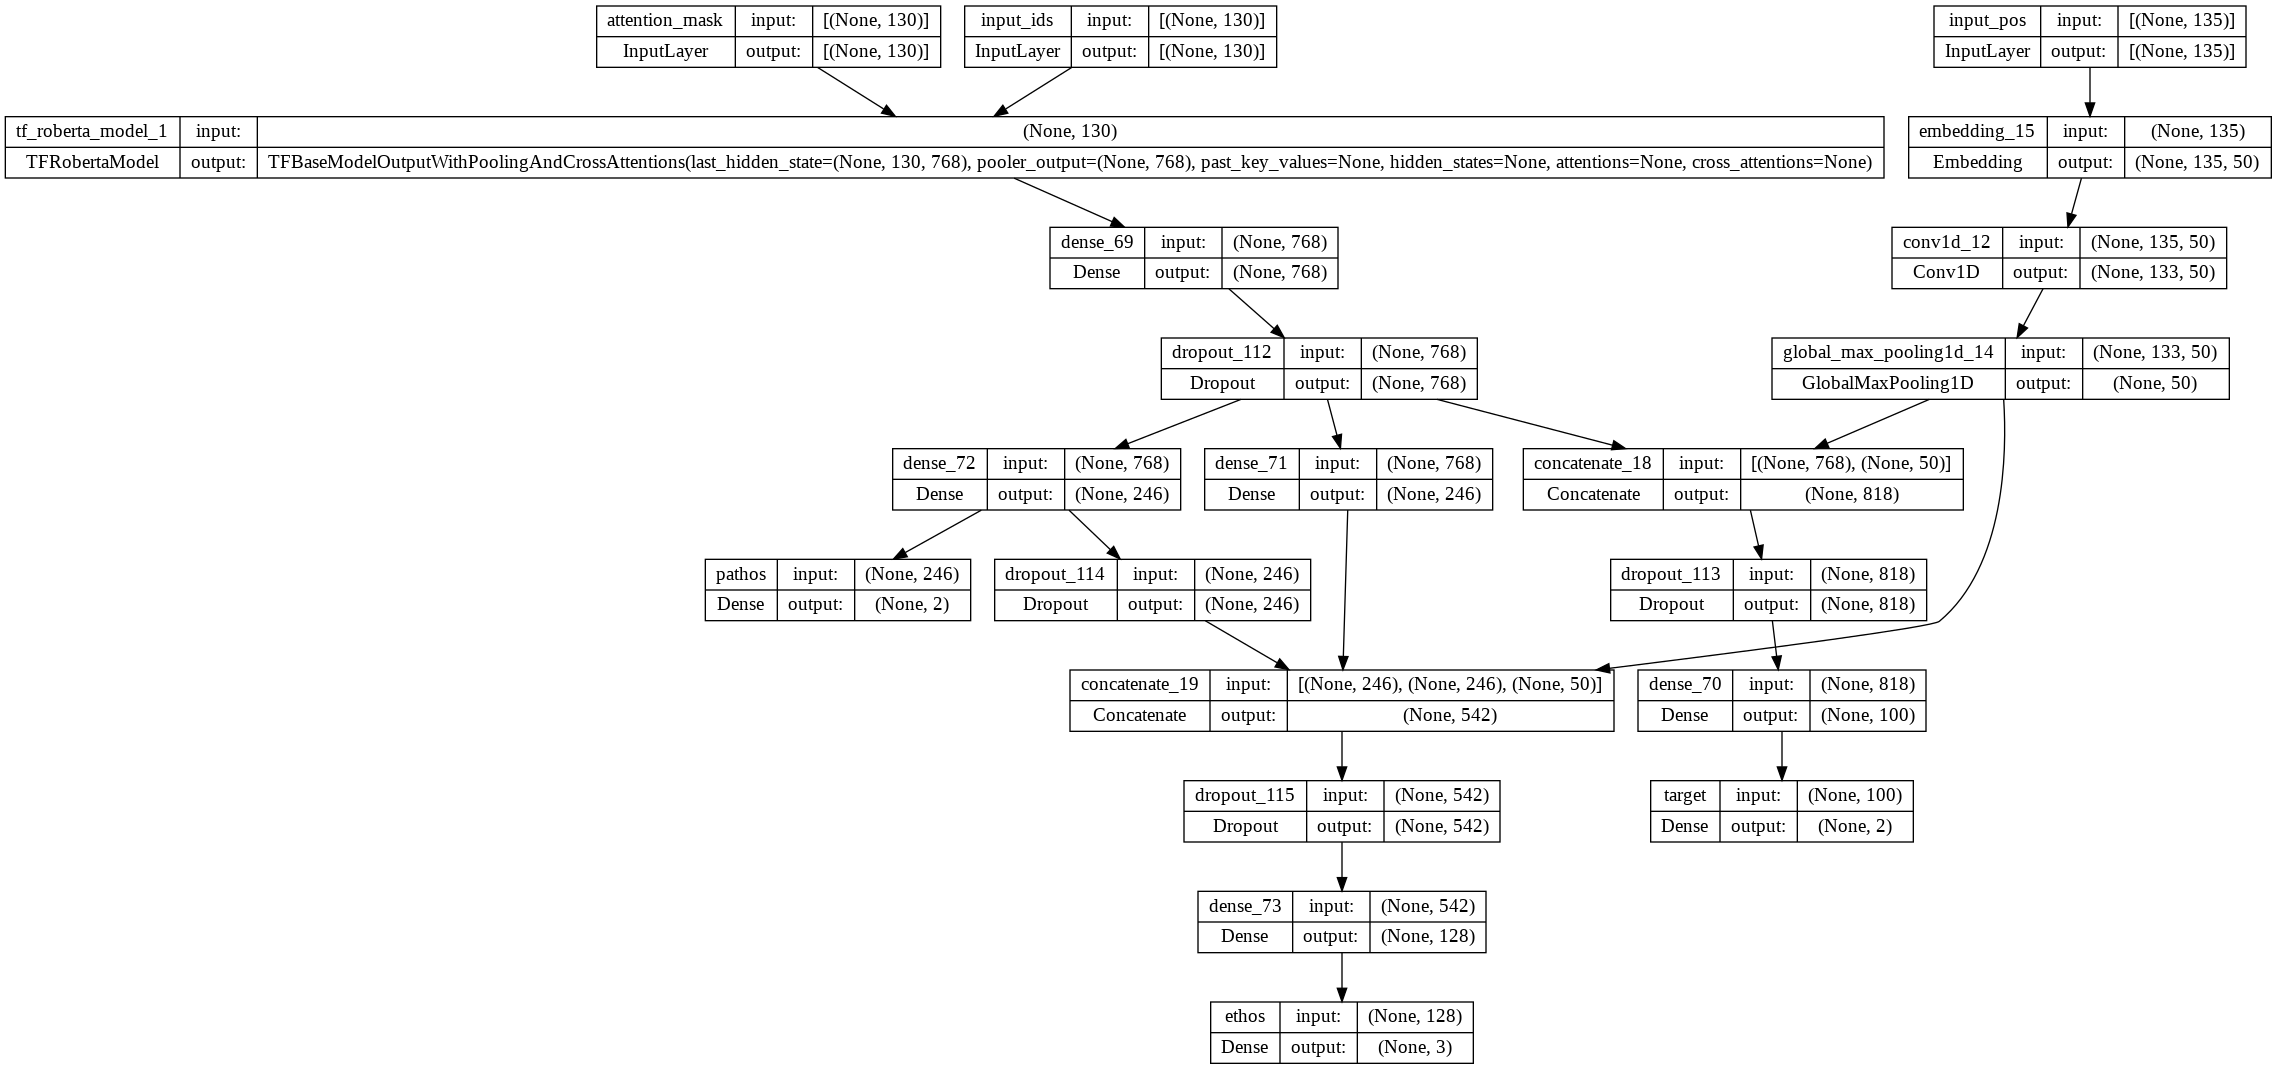

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # pool 2

In [ ]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                        

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss, 'target': loss}, 
              optimizer = optimizer, metrics = metric)

#model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.senti.tolist()),
                         'target': to_categorical(df_ethos_tr.Ethos_Label.map({0:0,1:1, 2:1}).tolist())} , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.senti.tolist()), 
                                        'target': to_categorical(df_ethos_ts.Ethos_Label.map({0:0,1:1,2:1}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2

Epoch 1/2
337/337 [==============================] - 118s 291ms/step - loss: 1.4584 - ethos_loss: 0.5309 - pathos_loss: 0.2449 - target_loss: 0.6826 - ethos_balanced_accuracy: 0.8086 - pathos_balanced_accuracy: 0.9160 - target_balanced_accuracy: 0.5539 - val_loss: 1.8203 - val_ethos_loss: 0.7162 - val_pathos_loss: 0.4258 - val_target_loss: 0.6782 - val_ethos_balanced_accuracy: 0.7459 - val_pathos_balanced_accuracy: 0.8380 - val_target_balanced_accuracy: 0.5869
Epoch 2/2
337/337 [==============================] - 91s 271ms/step - loss: 1.1862 - ethos_loss: 0.3630 - pathos_loss: 0.1452 - target_loss: 0.6780 - ethos_balanced_accuracy: 0.8665 - pathos_balanced_accuracy: 0.9532 - target_balanced_accuracy: 0.5755 - val_loss: 1.8701 - val_ethos_loss: 0.7383 - val_pathos_loss: 0.4564 - val_target_loss: 0.6753 - val_ethos_balanced_accuracy: 0.7637 - val_pathos_balanced_accuracy: 0.8351 - val_target_balanced_accuracy: 0.5929


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.senti.tolist()),
                         'target': to_categorical(df_ethos_tr.Ethos_Label.map({0:0,1:1, 2:1}).tolist())} , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.senti.tolist()), 
                                        'target': to_categorical(df_ethos_ts.Ethos_Label.map({0:0,1:1,2:1}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2 2nd try

Epoch 1/2
337/337 [==============================] - 115s 280ms/step - loss: 0.4566 - ethos_loss: 0.2698 - pathos_loss: 0.0931 - target_loss: 0.0936 - ethos_balanced_accuracy: 0.9238 - pathos_balanced_accuracy: 0.9825 - target_balanced_accuracy: 0.9807 - val_loss: 2.2704 - val_ethos_loss: 1.0374 - val_pathos_loss: 0.5155 - val_target_loss: 0.7176 - val_ethos_balanced_accuracy: 0.7281 - val_pathos_balanced_accuracy: 0.8529 - val_target_balanced_accuracy: 0.8262
Epoch 2/2
337/337 [==============================] - 92s 272ms/step - loss: 0.1942 - ethos_loss: 0.1100 - pathos_loss: 0.0392 - target_loss: 0.0451 - ethos_balanced_accuracy: 0.9736 - pathos_balanced_accuracy: 0.9914 - target_balanced_accuracy: 0.9903 - val_loss: 2.5317 - val_ethos_loss: 1.1946 - val_pathos_loss: 0.5758 - val_target_loss: 0.7613 - val_ethos_balanced_accuracy: 0.7251 - val_pathos_balanced_accuracy: 0.8470 - val_target_balanced_accuracy: 0.8306


In [ ]:

predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts})

# multi-task
y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # Sentimet
y_pred3 = np.argmax(predicted[2], axis = -1) # target
y_pred[:5], y_pred2[:5], y_pred3[:5]

22/22 [==============================] - 9s 258ms/step


(array([2, 0, 2, 1, 2]), array([0, 0, 0, 1, 0]), array([1, 0, 1, 1, 1]))

In [ ]:
# pool 2

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Sentimet\n', metrics.classification_report(df_ethos_ts.senti.tolist(), 
                                               y_pred2, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map({0:0,1:1, 2:1}).tolist(), 
                                               y_pred3, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.797     0.849     0.822       291
           1      0.617     0.675     0.645       117
           2      0.800     0.709     0.752       265

    accuracy                          0.764       673
   macro avg      0.738     0.744     0.740       673
weighted avg      0.767     0.764     0.764       673

Sentimet
               precision    recall  f1-score   support

           0      0.862     0.880     0.871       425
           1      0.787     0.758     0.772       248

    accuracy                          0.835       673
   macro avg      0.824     0.819     0.821       673
weighted avg      0.834     0.835     0.834       673

Target
               precision    recall  f1-score   support

           0      0.947     0.062     0.116       291
           1      0.583     0.997     0.736       382

    accuracy                          0.593       673
   macro avg      0.765     0.530     0.426      

In [ ]:
# pool 2 2nd try 3 epochs enhanced prons

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Sentimet\n', metrics.classification_report(df_ethos_ts.senti.tolist(), 
                                               y_pred2, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map({0:0,1:1, 2:1}).tolist(), 
                                               y_pred3, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.862     0.732     0.792       291
           1      0.522     0.718     0.604       117
           2      0.721     0.721     0.721       265

    accuracy                          0.725       673
   macro avg      0.702     0.724     0.706       673
weighted avg      0.747     0.725     0.731       673

Sentimet
               precision    recall  f1-score   support

           0      0.863     0.901     0.881       425
           1      0.817     0.754     0.784       248

    accuracy                          0.847       673
   macro avg      0.840     0.828     0.833       673
weighted avg      0.846     0.847     0.846       673

Target
               precision    recall  f1-score   support

           0      0.864     0.722     0.787       291
           1      0.812     0.914     0.860       382

    accuracy                          0.831       673
   macro avg      0.838     0.818     0.823      

##m3.3 emo and target

In [ ]:
df_ethos_ts = lemma_text(df_ethos_ts, text_column = 'Text')
df_ethos_ts = transform_text(df_ethos_ts, 'Text_lemmatized')

df_ethos_tr = lemma_text(df_ethos_tr, text_column = 'Text')
df_ethos_tr = transform_text(df_ethos_tr, 'Text_lemmatized')

df_ethos_tr.head(2)

In [ ]:
prons = {'he', 'she', 'you', 'they'}

for i in df_ethos_tr[df_ethos_tr.Text_ent.map(len) < 1].index:
  txt_lem = df_ethos_tr.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos_tr.loc[i, 'Text_ent'].append('PERSON')
  else:
    df_ethos_tr.loc[i, 'Text_ent'].append('empty')
    

for i in df_ethos_ts[df_ethos_ts.Text_ent.map(len) < 1].index:
  txt_lem = df_ethos_ts.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos_ts.loc[i, 'Text_ent'].append('PERSON')
  else:
    df_ethos_ts.loc[i, 'Text_ent'].append('empty')
    

In [ ]:
df_ethos_ts = count_categories(df_ethos_ts, categories_column = 'Text_ent', prefix_txt = 'ent_')
df_ethos_tr = count_categories(df_ethos_tr, categories_column = 'Text_ent', prefix_txt = 'ent_')

#senti_dummy_ts = pd.get_dummies(df_ethos_ts.expressed_sentiment)
#senti_dummy_tr = pd.get_dummies(df_ethos_tr.expressed_sentiment)

senti_dummy_ts = pd.get_dummies(df_ethos_ts.pathos_label, prefix='pathe')
senti_dummy_tr = pd.get_dummies(df_ethos_tr.pathos_label, prefix='pathe')

df_ethos_ts.head(2)

In [ ]:
senti_dummy_ts = pd.get_dummies(df_ethos_ts.EmotAn_label, prefix='EmotAn')
senti_dummy_tr = pd.get_dummies(df_ethos_tr.EmotAn_label, prefix='EmotAn')

df_ethos_ts.head(2)

In [ ]:
df_ethos_ts['ent_PERSON'] = np.where(df_ethos_ts['ent_PERSON'] > 0, 1, 0)
df_ethos_tr['ent_PERSON'] = np.where(df_ethos_tr['ent_PERSON'] > 0, 1, 0)

In [ ]:
df_ethos_ts['text_feat'] = df_ethos_ts.Text_pos.apply(lambda x: " ".join(x)) + " "+ df_ethos_ts.Text_ent.apply(lambda x: " ".join(x))
df_ethos_tr['text_feat'] = df_ethos_tr.Text_pos.apply(lambda x: " ".join(x)) + " "+ df_ethos_tr.Text_ent.apply(lambda x: " ".join(x))

df_ethos_tr['text_feat'].iloc[:3]

1143    ADV VERB PRON VERB DET NOUN ADP NOUN CCONJ DET...
1286               AUX PRON ADJ PRON VERB DET NOUN PERSON
140                              NOUN PROPN AUX NUM empty
Name: text_feat, dtype: object

In [ ]:
maxlen_feat = max(df_ethos_tr['text_feat'].str.split().map(len)) 

from tensorflow.keras.layers import TextVectorization

x_feat = df_ethos_tr.text_feat.tolist()
vectorizer = TextVectorization(output_sequence_length=maxlen_feat)
text_ds = tf.data.Dataset.from_tensor_slices(x_feat).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()

num_tokens = len(voc) + 2
embedding_dim = 50

num_tokens, maxlen_feat

(25, 134)

In [ ]:
add_ftr = df_ethos_tr['text_feat'].values
add_fts = df_ethos_ts['text_feat'].values

add_ftr = vectorizer(np.array([[s] for s in add_ftr])).numpy()
add_fts = vectorizer(np.array([[s] for s in add_fts])).numpy()
add_ftr[:1]

array([[ 9,  3,  4,  3,  6,  2,  5,  2, 15,  6,  7,  2,  9,  9,  9, 10,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]])

In [ ]:
max_len = 130

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel
from transformers import pipeline

check = "j-hartmann/emotion-english-distilroberta-base"
#check = "bhadresh-savani/distilbert-base-uncased-emotion"
sentiment_analysis = pipeline("text-classification", model=check, device=0)

result_tr = sentiment_analysis(df_ethos_tr.Text.tolist())
result_ts = sentiment_analysis(df_ethos_ts.Text.tolist())

In [ ]:
df_ethos_tr['emo'] = [x['label'] for x in result_tr]
df_ethos_ts['emo'] = [x['label'] for x in result_ts]

In [ ]:
#check = "j-hartmann/emotion-english-distilroberta-base"

df_ethos_tr['emo'].value_counts(normalize=True).round(3)

neutral     0.591
anger       0.130
disgust     0.080
surprise    0.074
sadness     0.052
joy         0.045
fear        0.028
Name: emo, dtype: float64

In [ ]:
#check = "bhadresh-savani/distilbert-base-uncased-emotion"

df_ethos_tr['emo'].value_counts(normalize=True).round(3)

anger       0.504
joy         0.366
sadness     0.072
fear        0.042
love        0.009
surprise    0.006
Name: emo, dtype: float64

In [ ]:
#check = "j-hartmann/emotion-english-distilroberta-base"

df_ethos_ts['emo'].value_counts(normalize=True).round(3)

neutral     0.585
anger       0.111
surprise    0.083
disgust     0.083
joy         0.062
sadness     0.048
fear        0.027
Name: emo, dtype: float64

In [ ]:
#check = "bhadresh-savani/distilbert-base-uncased-emotion"

df_ethos_ts['emo'].value_counts(normalize=True).round(3)

anger       0.514
joy         0.334
sadness     0.083
fear        0.043
love        0.016
surprise    0.009
Name: emo, dtype: float64

In [ ]:
max_len = 130
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# pool 2.2 

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_pos = Input(shape = (maxlen_feat, ), dtype = tf.int32, name = 'input_pos')

input_layer1 = layers.Embedding(num_tokens, 50, input_length=maxlen_feat, trainable=True)
x00 = input_layer1(input_pos)
x00 = Conv1D(50, 3, activation = 'relu')(x00)
x00 = GlobalMaxPool1D()(x00)

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
#x = Dropout(0.3)(x)

x0 = tf.keras.layers.Concatenate(axis=1)([x, x00])
x0 = Dropout(0.2)(x0)
x0 = Dense(100, activation = 'relu')(x0)

x1 = Dense(246, activation = 'relu')(x)
x2 = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x2)
x = tf.keras.layers.Concatenate(axis=1)([x, x1, x00])
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
#y2 = Dense(7, activation = 'softmax', name = 'pathos')(x2)
y2 = Dense(3, activation = 'softmax', name = 'pathos')(x2)
y3 = Dense(2, activation = 'softmax', name = 'target')(x0)

model = tf.keras.Model( inputs = [input_ids, input_mask, input_pos], outputs = [y1, y2, y3] )

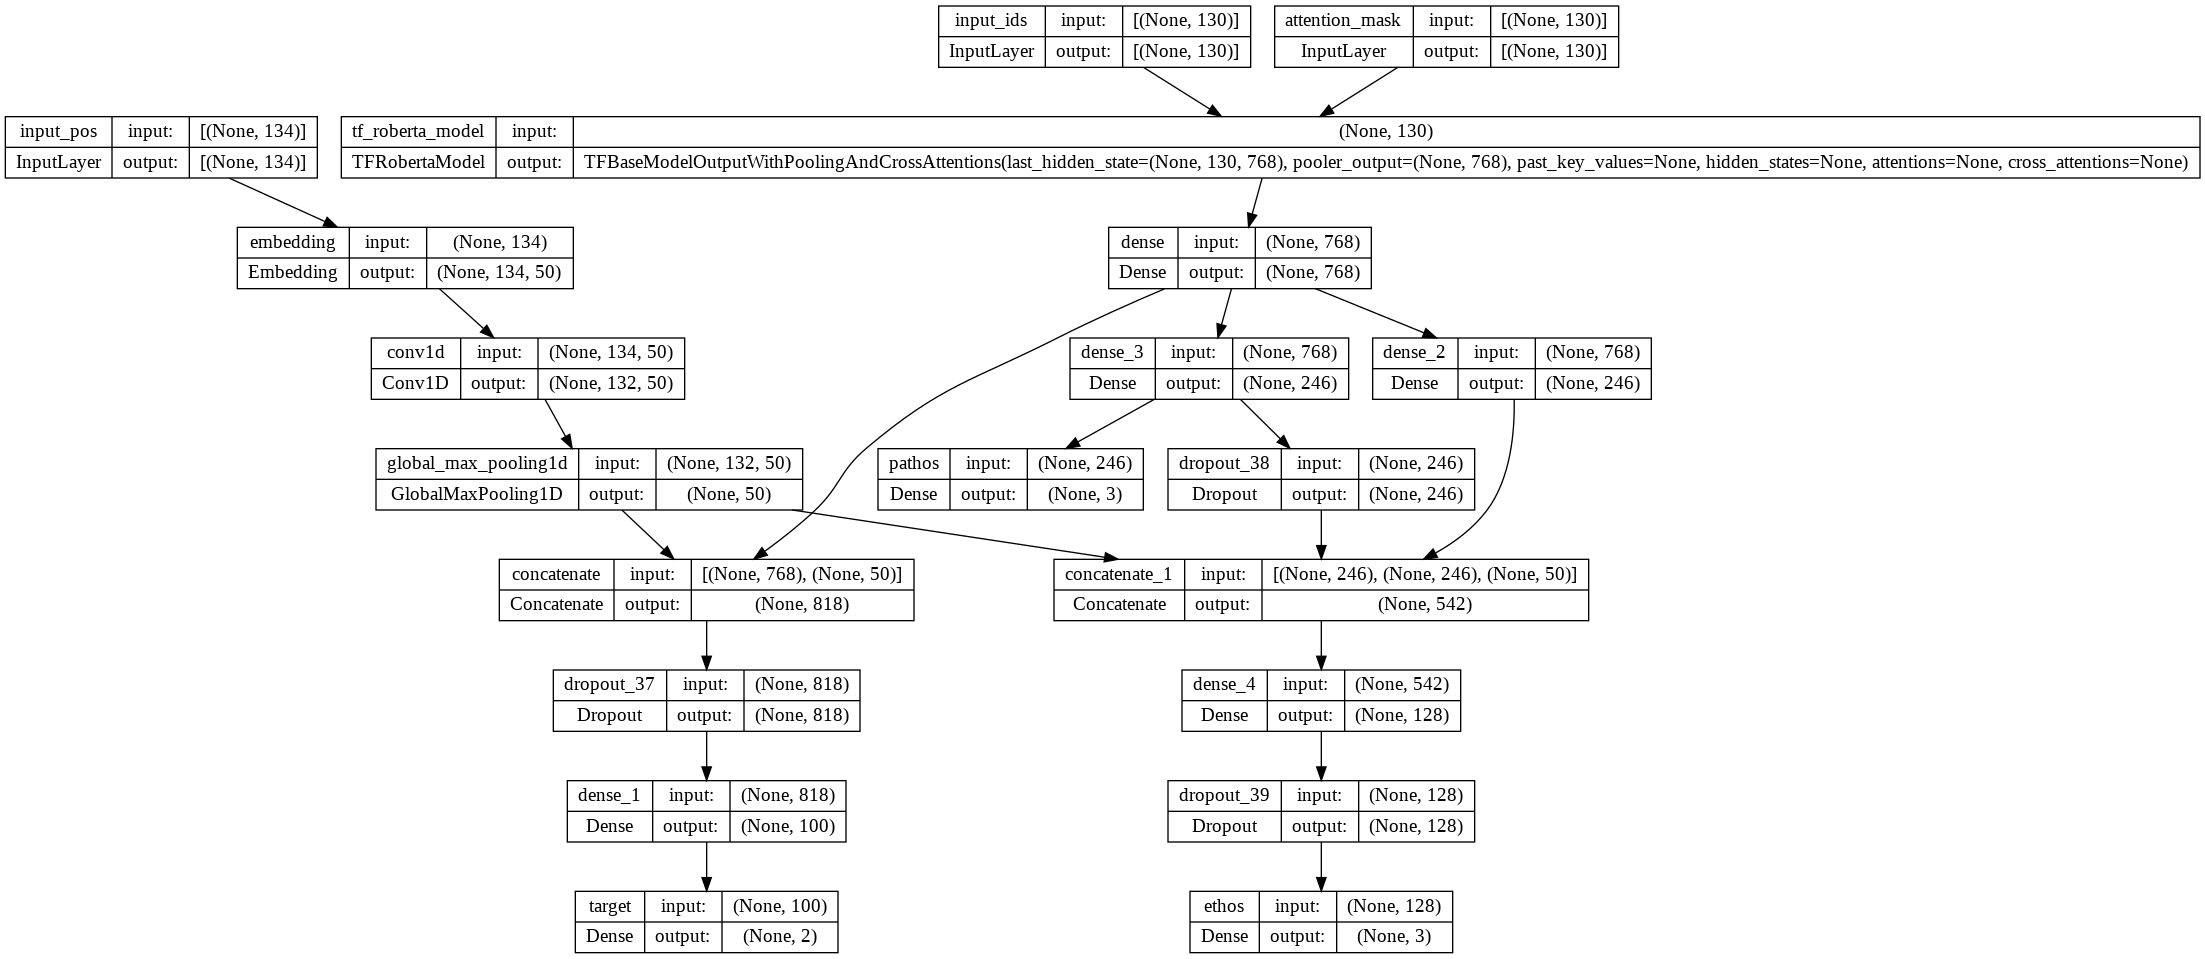

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # pooler 2

In [ ]:
# ethos  with pos feat

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_pos = Input(shape = (maxlen_feat, ), dtype = tf.int32, name = 'input_pos')

input_layer1 = layers.Embedding(num_tokens, 50, input_length=maxlen_feat, trainable=True)
x00 = input_layer1(input_pos)
x00 = Conv1D(50, 3, activation = 'relu')(x00)
x00 = GlobalMaxPool1D()(x00)

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)

x0 = tf.keras.layers.Concatenate(axis=1)([x, x00])
x0 = Dense(200, activation = 'relu')(x0)
x0 = Dropout(0.2)(x0)
y = Dense(3, activation = 'softmax', name = 'ethos')(x0)

model = tf.keras.Model( inputs = [input_ids, input_mask, input_pos], outputs = y )

In [ ]:
# ethos  with pos feat  and dummy senti
 
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_pos = Input(shape = (maxlen_feat, ), dtype = tf.int32, name = 'input_pos')
input_senti = Input(shape = (3, ), dtype = tf.int32, name = 'input_senti')

input_layer1 = layers.Embedding(num_tokens, 50, input_length=maxlen_feat, trainable=True)
x00 = input_layer1(input_pos)
x00 = Conv1D(50, 3, activation = 'relu')(x00)
x00 = GlobalMaxPool1D()(x00)

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)

x0 = tf.keras.layers.Concatenate(axis=1)([x, x00])
x0 = Dense(200, activation = 'relu')(x0)
x0 = Dropout(0.2)(x0)
x0 = tf.keras.layers.Concatenate(axis=1)([x0, input_senti])
y = Dense(3, activation = 'softmax', name = 'ethos')(x0)

model = tf.keras.Model( inputs = [input_ids, input_mask, input_pos, input_senti], outputs = y )

In [ ]:
# ethos  with pos feat  and target

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_pos = Input(shape = (maxlen_feat, ), dtype = tf.int32, name = 'input_pos')

input_layer1 = layers.Embedding(num_tokens, 50, input_length=maxlen_feat, trainable=True)
x00 = input_layer1(input_pos)
x00 = Conv1D(50, 3, activation = 'relu')(x00)
x00 = GlobalMaxPool1D()(x00)

embeddings = bert(input_ids, attention_mask = input_mask)[1] 
x = Dense(768, activation = 'relu')(embeddings)
x = Dropout(0.2)(x)

x0 = tf.keras.layers.Concatenate(axis=1)([x, x00])
x0 = Dense(100, activation = 'relu')(x0)
x0 = Dropout(0.2)(x0)

x = tf.keras.layers.Concatenate(axis=1)([x, x00])
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)

y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y3 = Dense(2, activation = 'softmax', name = 'target')(x0)

model = tf.keras.Model( inputs = [input_ids, input_mask, input_pos], outputs = [y1, y3] )

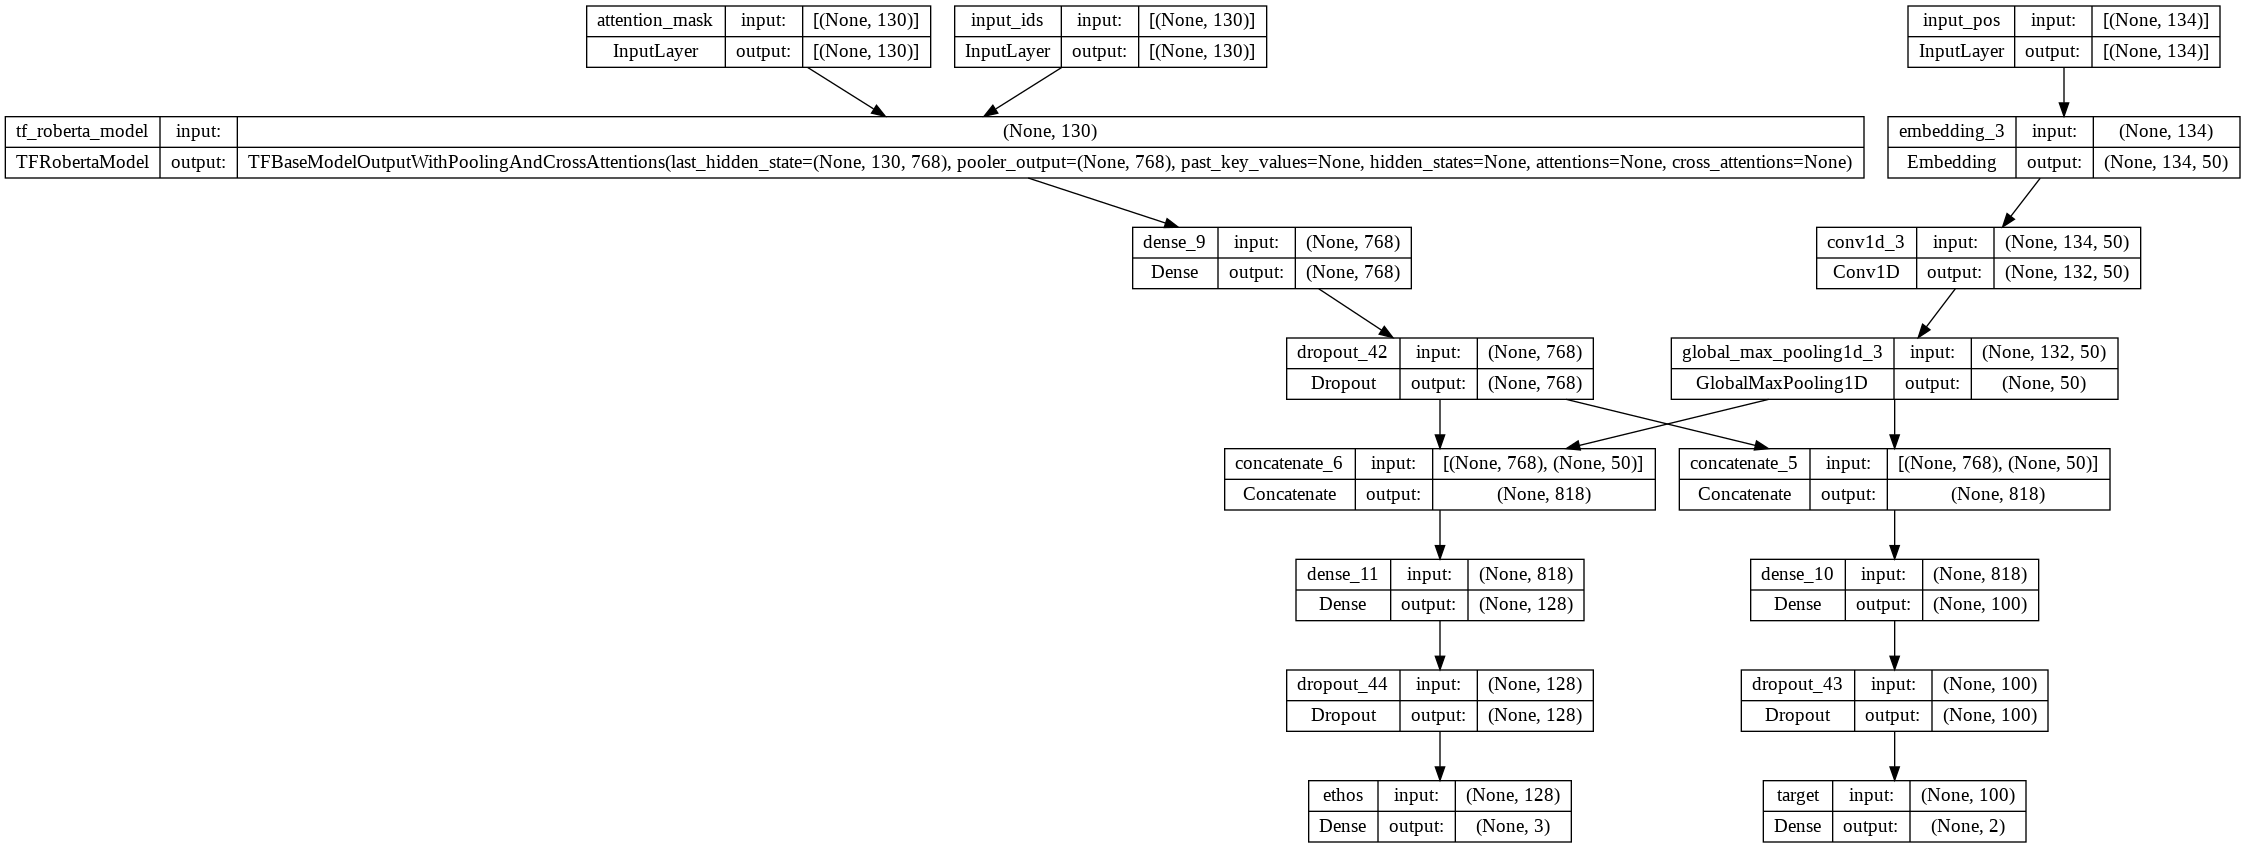

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) 

In [ ]:
model.layers

In [ ]:
model.summary()

In [ ]:
'''
,loss_weights=[1,10]

loss_weights:
  parameter on compile is used to define how much each of your model output loss 
contributes to the final loss value ie. it weighs the model output losses. 
You could have a model with 2 outputs where one is the primary output and the other auxiliary.
 eg. 1. * primary + 0.3 * auxiliary. The default values for loss weights is 1.

class_weight:
   parameter on fit is used to weigh the importance of each sample based on the class 
they belong to, during training. This is typically used when you have an uneven distribution of samples per class.
'''

###train

In [ ]:
# chech parameters -> loss !!  from_logits

# https://www.tensorflow.org/recommenders/examples/multitask 
# https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb

optimizer = Adam(learning_rate = 3e-5,) #  epsilon = 1e-8, decay = 1e-2
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss, 'target': loss}, optimizer = optimizer, metrics = metric ) # ,loss_weights=[2, 1, 1] / loss_weights={'ethos': 1, 'pathos': 0.7, 'target': 0.8},

#model.compile(loss = loss, optimizer = optimizer, metrics = metric )

model.compile(loss = {'ethos': loss, 'target': loss}, optimizer = optimizer, metrics = metric )

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
df_ethos_tr['EmotAn_label'].unique()

array(['joy', 'anger', 'neutral', 'sadness', 'surprise', 'fear'],
      dtype=object)

In [ ]:
label2id ={
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "joy": 3,
    "neutral": 4,
    "sadness": 5,
    "surprise": 6
  }

In [ ]:
# 3 cats- p, n, neu

label2id ={
    "anger": 2,
    "disgust": 2,
    "fear": 2,
    "joy": 1,
    "neutral": 0,
    "sadness": 2,
    "surprise": 1
  }

In [ ]:
# "bhadresh-savani/distilbert-base-uncased-emotion"

label2id ={
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  }

In [ ]:

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.emo.map(label2id).tolist()),
                         'target': to_categorical(df_ethos_tr.Ethos_Label.map({0:0,1:1, 2:1}).tolist())} , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.emo.map(label2id).tolist()), 
                                        'target': to_categorical(df_ethos_ts.Ethos_Label.map({0:0,1:1,2:1}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2 1st try

Epoch 1/2
337/337 [==============================] - 117s 292ms/step - loss: 2.6433 - ethos_loss: 0.8238 - pathos_loss: 1.3285 - target_loss: 0.4909 - ethos_balanced_accuracy: 0.6532 - pathos_balanced_accuracy: 0.5896 - target_balanced_accuracy: 0.7736 - val_loss: 2.3800 - val_ethos_loss: 0.7008 - val_pathos_loss: 1.2588 - val_target_loss: 0.4204 - val_ethos_balanced_accuracy: 0.7236 - val_pathos_balanced_accuracy: 0.6122 - val_target_balanced_accuracy: 0.8098
Epoch 2/2
337/337 [==============================] - 101s 301ms/step - loss: 2.1644 - ethos_loss: 0.6152 - pathos_loss: 1.2146 - target_loss: 0.3345 - ethos_balanced_accuracy: 0.7710 - pathos_balanced_accuracy: 0.6100 - target_balanced_accuracy: 0.8751 - val_loss: 2.3676 - val_ethos_loss: 0.6983 - val_pathos_loss: 1.2203 - val_target_loss: 0.4489 - val_ethos_balanced_accuracy: 0.7162 - val_pathos_balanced_accuracy: 0.6048 - val_target_balanced_accuracy: 0.8113


In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.emo.map(label2id).tolist()),
                         'target': to_categorical(df_ethos_tr.ent_PERSON.tolist())} , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.emo.map(label2id).tolist()), 
                                        'target': to_categorical(df_ethos_ts.ent_PERSON.tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2 2nd try - 3 cat emo and loss weight

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist())),
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2 etho with pos

337/337 [==============================] - 100s 298ms/step - loss: 0.3622 - accuracy: 0.8751 - val_loss: 0.7375 - val_accuracy: 0.7459


In [ ]:
senti_dummy_tr

history = model.fit(x = { 'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr, 'input_senti': senti_dummy_tr.to_numpy() }, 
                    
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts, 'input_senti': senti_dummy_ts.to_numpy() }, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist())),
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) # pool 2 etho with pos  and dummy senti

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'input_pos': add_ftr}, 
                    
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'target': to_categorical(df_ethos_tr.ent_PERSON.tolist())} , 
                    
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts}, 
                                       
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'target': to_categorical(df_ethos_ts.ent_PERSON.tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1) #  pool 2 etho with pos and target

In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts})

# multi-task
y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # Sentimet
y_pred3 = np.argmax(predicted[2], axis = -1) # target
y_pred[:5], y_pred2[:5], y_pred3[:5]

22/22 [==============================] - 9s 260ms/step


(array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts})

# multi-task
y_pred = np.argmax(predicted, axis = -1)
y_pred[:5]

22/22 [==============================] - 11s 262ms/step


array([1, 0, 0, 1, 2])

In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'input_pos': add_fts})

# multi-task
y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # Sentimet
y_pred[:5], y_pred2[:5]

22/22 [==============================] - 12s 266ms/step


(array([2, 0, 0, 2, 2]), array([1, 0, 1, 1, 1]))

In [ ]:
# pool 2 etho with pos 3 epochs

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.785     0.818     0.801       291
           1      0.680     0.564     0.617       117
           2      0.725     0.747     0.736       265

    accuracy                          0.746       673
   macro avg      0.730     0.710     0.718       673
weighted avg      0.744     0.746     0.744       673



In [ ]:
# pooler 2 with pos  and target 1 epoch

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.ent_PERSON.tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.812     0.832     0.822       291
           1      0.600     0.641     0.620       117
           2      0.768     0.725     0.746       265

    accuracy                          0.756       673
   macro avg      0.727     0.732     0.729       673
weighted avg      0.758     0.756     0.757       673

Target
               precision    recall  f1-score   support

           0      0.934     0.928     0.931       349
           1      0.923     0.929     0.926       324

    accuracy                          0.929       673
   macro avg      0.929     0.929     0.929       673
weighted avg      0.929     0.929     0.929       673



In [ ]:
# pooler 2 2 epochs
#"j-hartmann/emotion-english-distilroberta-base"

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Emo\n', metrics.classification_report(df_ethos_ts.emo.map(label2id).tolist(), 
                                               y_pred2, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map({0:0,1:1, 2:1}).tolist(), 
                                               y_pred3, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.838     0.694     0.759       291
           1      0.620     0.530     0.571       117
           2      0.657     0.823     0.730       265

    accuracy                          0.716       673
   macro avg      0.705     0.682     0.687       673
weighted avg      0.729     0.716     0.715       673

Emo
               precision    recall  f1-score   support

           0      0.309     0.507     0.384        75
           1      0.000     0.000     0.000        56
           2      0.000     0.000     0.000        18
           3      0.000     0.000     0.000        42
           4      0.671     0.937     0.782       394
           5      0.000     0.000     0.000        32
           6      0.000     0.000     0.000        56

    accuracy                          0.605       673
   macro avg      0.140     0.206     0.167       673
weighted avg      0.427     0.605     0.500       673

Target
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# pooler 2 3 epochs  -  3 cat emo
#"j-hartmann/emotion-english-distilroberta-base"

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Emo\n', metrics.classification_report(df_ethos_ts.emo.map(label2id).tolist(), 
                                               y_pred2, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map({0:0,1:1, 2:1}).tolist(), 
                                               y_pred3, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.820     0.784     0.801       291
           1      0.643     0.615     0.629       117
           2      0.728     0.777     0.752       265

    accuracy                          0.752       673
   macro avg      0.730     0.725     0.727       673
weighted avg      0.753     0.752     0.752       673

Emo
               precision    recall  f1-score   support

           0      0.764     0.911     0.831       394
           1      0.909     0.102     0.183        98
           2      0.693     0.735     0.713       181

    accuracy                          0.746       673
   macro avg      0.789     0.583     0.576       673
weighted avg      0.766     0.746     0.705       673

Target
               precision    recall  f1-score   support

           0      0.826     0.766     0.795       291
           1      0.831     0.877     0.854       382

    accuracy                          0.829       673


In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Emo\n', metrics.classification_report(df_ethos_ts.emo.map(label2id).tolist(), 
                                               y_pred2, digits=3)) 

print('Target\n', metrics.classification_report(df_ethos_ts.ent_PERSON.tolist(), 
                                               y_pred3, digits=3)) 

##m4

###load lexicons

In [ ]:
abuse=load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/abuseLexicon.xlsx")

#lep_lex=load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/lepAnLexicon.xlsx")
lep_lex=load_data('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/lepAnLexicon2.csv')

In [ ]:
abus_words = set(abuse.word.values)
lep_words = set(lep_lex.word.values)

In [ ]:
!pip install -U spacy --quiet

# install Spacy language model 
!python -m spacy download en_core_web_lg --quiet

import spacy
nlp = spacy.load('en_core_web_lg')

     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct)]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data

In [ ]:
def count_categories(dataframe, categories_column, prefix_txt = 'pos'):
  '''Parameters: 
  dataframe: dataframe with data,
  
  categories_column: str - name of a column in dataframe where the list of categories is located,
  
  '''

  dataframe["merge_indx"] = range(0, len(dataframe))
  from collections import Counter

  dataframe = pd.merge(dataframe, pd.DataFrame([Counter(x) for x in dataframe[categories_column]]).fillna(0).astype(int).add_prefix(str(prefix_txt)), how='left', left_on="merge_indx", right_index=True)
  dataframe.drop(["merge_indx"], axis=1, inplace=True)
  
  return dataframe

In [ ]:
def transform_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    dep_column.append([token.dep_ for token in doc])
    pos_column.append([token.pos_ for token in doc])
    ent_column.append([token.label_ for token in doc.ents if (token.label_ == 'PERSON' or token.label_ == 'ORG') ])
  
  data["Text_dep"] = dep_column
  data["Text_pos"] = pos_column
  data["Text_ent"] = ent_column
  return data

In [ ]:
df_ethos = lemma_text(df_ethos, text_column = 'Text')
df_ethos.tail(1)

In [ ]:
df_ethos = transform_text(df_ethos, 'Text_lemmatized')

df_ethos['text_feat'] = 'DEP: '+df_ethos.Text_dep.apply(lambda x: " ".join(x))+". POS: "+ df_ethos.Text_pos.apply(lambda x: " ".join(x))+'. NER: '+ df_ethos.Text_ent.apply(lambda x: " ".join(x))
df_ethos.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,he's killing it,he be kill it,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",[],DEP: nsubj aux ROOT dobj. POS: PRON AUX VERB P...
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Sanders has some good points,sander have some good point,joy,NaN,NaN,Sanders have some good point,"[nsubj, ROOT, det, amod, dobj]","[PROPN, VERB, DET, ADJ, NOUN]",[PERSON],DEP: nsubj ROOT det amod dobj. POS: PROPN VERB...


In [ ]:
df_ethos = count_categories(df_ethos, categories_column = 'Text_dep', prefix_txt = 'dep_')
df_ethos = count_categories(df_ethos, categories_column = 'Text_pos', prefix_txt = 'pos_')
df_ethos = count_categories(df_ethos, categories_column = 'Text_ent', prefix_txt = 'ent_')
df_ethos.head(3)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,pos_CCONJ,pos_SPACE,pos_X,pos_SCONJ,pos_NUM,pos_INTJ,pos_PUNCT,pos_SYM,ent_PERSON,ent_ORG
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,0,0,0,0,0,0,0,0,1,0
2,10055,his delivery is not solid,berlinbrown,Sanders,0.0,1.0,0.0,1.0,2,1.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ttest_cols = ['pos_VERB', 'pos_ADJ', 'pos_PROPN', 'pos_ADP', 'pos_CCONJ',
       'pos_PART', 'dep_acomp', 'dep_prep', 'dep_aux', 'dep_cc',
       'dep_poss', 'dep_xcomp', 'dep_case', 'ent_PERSON', 'pos_INTJ',
       'pos_PRON', 'pos_AUX', 'dep_nsubj', 'dep_pobj', 'dep_prt',
       'dep_amod', 'dep_neg', 'dep_ccomp', 'pos_NOUN']

# refer to EthosAnalytics notebook to see the reason why those are selected

In [ ]:
#df_ethos[ttest_cols] = df_ethos[ttest_cols] / 10

In [ ]:
df_ethos[ttest_cols].describe()

,pos_VERB,pos_ADJ,pos_PROPN,pos_ADP,pos_CCONJ,pos_PART,dep_acomp,dep_prep,dep_aux,dep_cc,...,pos_INTJ,pos_PRON,pos_AUX,dep_nsubj,dep_pobj,dep_prt,dep_amod,dep_neg,dep_ccomp,pos_NOUN
count,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,...,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000
mean,1.570324,0.777282,0.472197,0.881356,0.218852,0.435326,0.198037,0.785905,0.568243,0.216176,...,0.061850,1.446328,0.793042,1.255724,0.715135,0.068689,0.490039,0.234315,0.278323,1.725245
std,1.318666,0.988660,0.992259,1.116325,0.548353,0.672101,0.439061,1.031602,0.814628,0.543153,...,0.297289,1.335582,0.943048,1.032499,0.960415,0.263332,0.813775,0.462567,0.595314,1.748810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000
max,20.000000,9.000000,21.000000,10.000000,9.000000,7.000000,3.000000,9.000000,10.000000,9.000000,...,6.000000,18.000000,15.000000,21.000000,8.000000,3.000000,7.000000,4.000000,10.000000,16.000000


In [ ]:
df_ethos[ttest_cols] = df_ethos[ttest_cols].fillna(0)

for c in ttest_cols:
  df_ethos[c] = df_ethos[c].apply(lambda x: np.log(x+1))

df_ethos[ttest_cols].describe()

,pos_VERB,pos_ADJ,pos_PROPN,pos_ADP,pos_CCONJ,pos_PART,dep_acomp,dep_prep,dep_aux,dep_cc,...,pos_INTJ,pos_PRON,pos_AUX,dep_nsubj,dep_pobj,dep_prt,dep_amod,dep_neg,dep_ccomp,pos_NOUN
count,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,...,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000,3363.000000
mean,0.829667,0.451068,0.266459,0.490114,0.137619,0.276119,0.132696,0.447604,0.346953,0.136262,...,0.040027,0.762829,0.469606,0.722073,0.414927,0.046892,0.293542,0.157721,0.176736,0.825783
std,0.480922,0.479689,0.437944,0.513395,0.309979,0.390744,0.285086,0.493323,0.431715,0.307918,...,0.172635,0.516132,0.466581,0.430482,0.477450,0.177183,0.426173,0.302619,0.337307,0.593674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.693147,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,...,0.000000,0.693147,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147
75%,1.098612,0.693147,0.693147,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.000000,...,0.000000,1.098612,0.693147,1.098612,0.693147,0.000000,0.693147,0.000000,0.000000,1.098612
max,3.044522,2.302585,3.091042,2.397895,2.302585,2.079442,1.386294,2.302585,2.397895,2.302585,...,1.945910,2.944439,2.772589,3.091042,2.197225,1.386294,2.079442,1.609438,2.397895,2.833213


In [ ]:
df_ethos['offens'] = df_ethos.Text_lemmatized.apply(lambda x: set(x.lower().split()).intersection(abus_words))
df_ethos['lepAN'] = df_ethos.Text_lemmatized.apply(lambda x: set(x.lower().split()).intersection(lep_words))


In [ ]:
df_ethos['add_text'] = df_ethos['offens'].apply(lambda x: " ".join(x)) + " " + df_ethos['lepAN'].apply(lambda x: " ".join(x))


In [ ]:
df_ethos['add_text'] = np.where(df_ethos['add_text'].map(len) < 2, 'nan', df_ethos['add_text'])

In [ ]:
df_ethos.iloc[50:53]

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,pos_INTJ,pos_PUNCT,pos_SYM,ent_PERSON,ent_ORG,offens,lepAN,add_text,offens_num,lep_num
50,9706,he's doing a really bad job of communicating,tdlop,Sanders,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,0.000000,0,{},{},nan,0,0
51,9706,As a big supporter: he needs to get his shit t...,tdlop,Sanders,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,0.000000,0,{shit},{},shit,1,0
52,9751,The fact that Bernie can't easily answer wheth...,broduding,Sanders,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,0.693147,0,{},{},nan,0,0


In [ ]:
df_ethos['offens_num'] = df_ethos['offens'].map(len)
#df_ethos['offens_num'] = np.where(df_ethos['offens_num'] > 0, 1, 0)

df_ethos['offens_num'].describe()

count    3363.000000
mean        0.096045
std         0.320793
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: offens_num, dtype: float64

In [ ]:
df_ethos['lep_num'] = df_ethos['lepAN'].map(len)
#df_ethos['lep_num'] = np.where(df_ethos['lep_num'] > 0, 1, 0)

df_ethos['lep_num'].describe()

count    3363.000000
mean        0.147487
std         0.413501
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: lep_num, dtype: float64

In [ ]:
df_ethos[ (df_ethos.lep_num > 0) & (df_ethos.offens_num > 0)].iloc[:3]

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,pos_INTJ,pos_PUNCT,pos_SYM,ent_PERSON,ent_ORG,offens,lepAN,add_text,offens_num,lep_num
19,10058,CNN and Anderson Cooper are horseshit,bringmethesampo,CNN,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,0.693147,1,{horseshit},{horseshit},horseshit horseshit,1,1
27,9810,Unfortunately the crowd blew up for Hillary's ...,chillbroswagginzz,Clinton,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,1.098612,0,{insane},"{action, blow, insane}",insane action blow insane,1,3
95,9840,Anyone who thinks Hilary is a better candidate...,Kagawaful,Clinton,0.0,1.0,0.0,1.0,2,0.0,...,0.0,0,0,0.693147,0,{idiot},{idiot},idiot idiot,1,1


In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(2690, 673)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:

add_tr = tf.convert_to_tensor(np.asarray(df_ethos_tr[ttest_cols+['lep_num', 'offens_num']].values).astype(np.float32), dtype=tf.float32)
add_ts = tf.convert_to_tensor(np.asarray(df_ethos_ts[ttest_cols+['lep_num', 'offens_num']].values).astype(np.float32), dtype=tf.float32)
add_ts[:4]

<tf.Tensor: shape=(4, 26), dtype=float32, numpy=
array([[1.3862944, 0.6931472, 0.       , 1.0986123, 0.6931472, 0.6931472,
        0.       , 0.6931472, 0.6931472, 0.6931472, 0.6931472, 0.6931472,
        0.       , 0.       , 0.       , 1.3862944, 0.       , 1.0986123,
        0.6931472, 0.       , 0.6931472, 0.       , 0.       , 1.0986123,
        0.       , 1.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.6931472,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       ],
       [0.6931472, 0.       , 0.       , 0.6931472, 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.6931472,
        0.       , 0.6931472, 0.       , 0.       , 0.       , 0.6931472,
 

In [ ]:
add_ts.shape

TensorShape([673, 26])

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# add feat (pos dep ent + abuse and EP)

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')
input_add = Input(shape = (26, ), dtype = tf.float32, name = 'add_features')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state
x = GlobalMaxPool1D()(embeddings)
x = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = tf.keras.layers.Concatenate(axis=1)([x, input_add])
x = Dense(64, activation = 'relu')(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask, input_add], outputs = y)

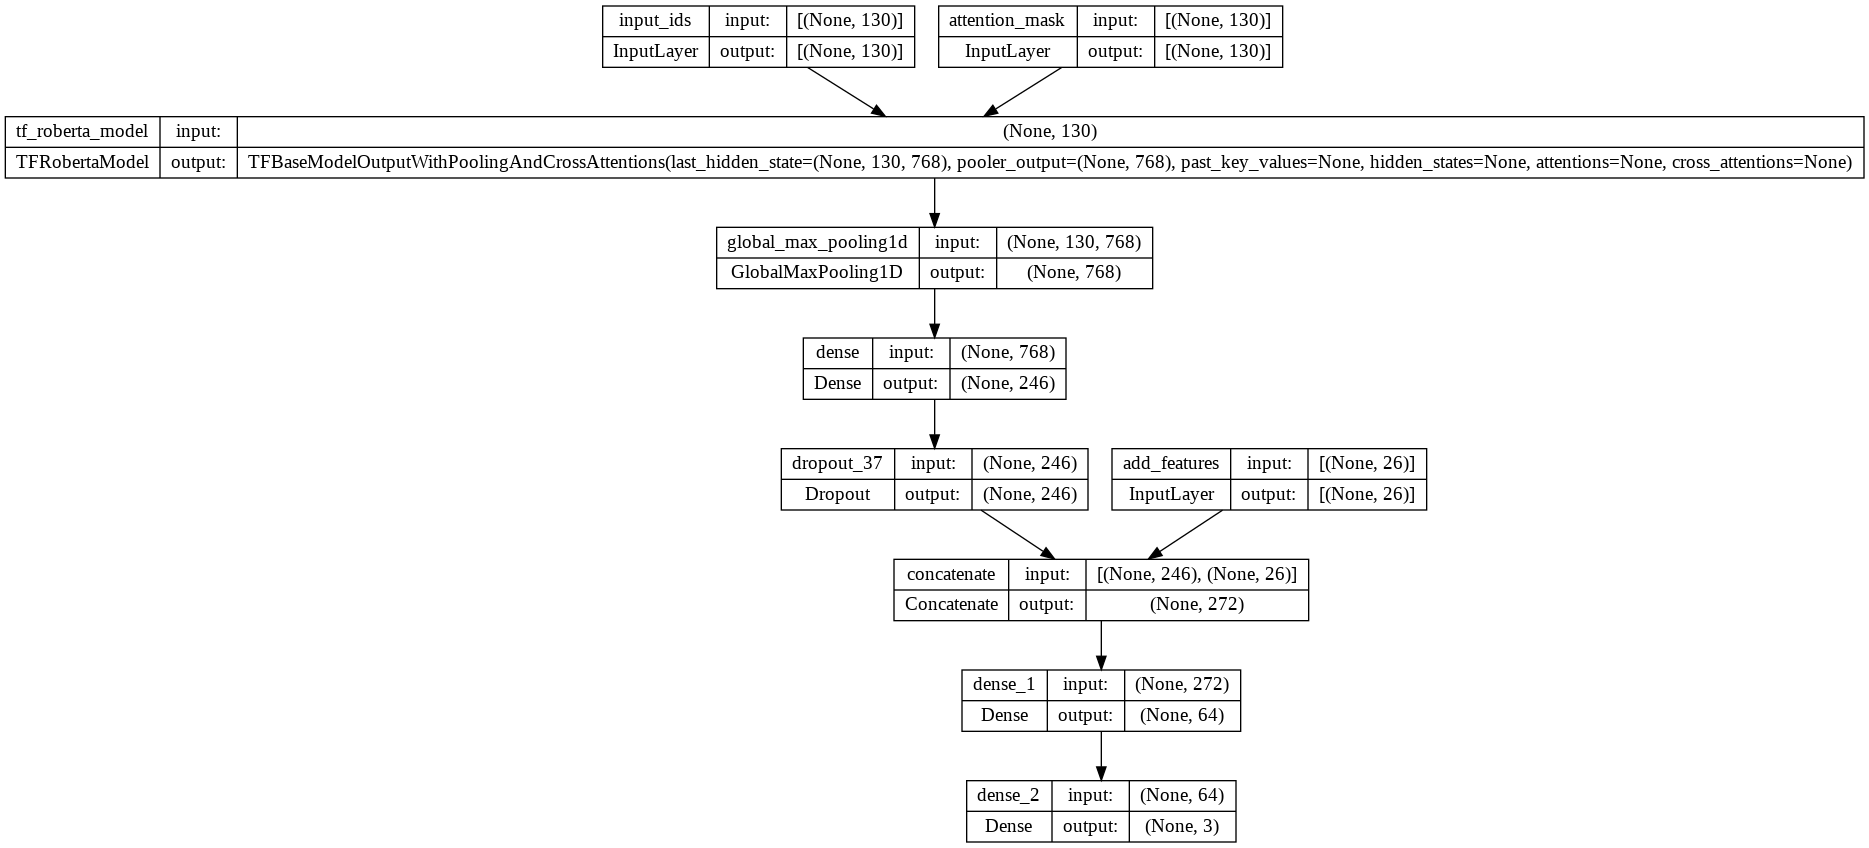

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                           

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 3 #(2+1)

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'add_features': add_tr}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'add_features': add_ts}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/3


337/337 [==============================] - 130s 300ms/step - loss: 0.8971 - balanced_accuracy: 0.5944 - val_loss: 0.7336 - val_balanced_accuracy: 0.7103
Epoch 2/3
337/337 [==============================] - 95s 281ms/step - loss: 0.6575 - balanced_accuracy: 0.7413 - val_loss: 0.7017 - val_balanced_accuracy: 0.7296
Epoch 3/3
337/337 [==============================] - 95s 281ms/step - loss: 0.5297 - balanced_accuracy: 0.8100 - val_loss: 0.6499 - val_balanced_accuracy: 0.7415


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                           'add_features': add_ts})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 11s 259ms/step


array([2, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.789     0.808     0.798       291
           1      0.532     0.701     0.605       117
           2      0.769     0.642     0.700       265

    accuracy                          0.724       673
   macro avg      0.697     0.717     0.701       673
weighted avg      0.736     0.724     0.726       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# updated EP lexicon

              precision    recall  f1-score   support

           0      0.781     0.808     0.794       291
           1      0.647     0.641     0.644       117
           2      0.738     0.713     0.726       265

    accuracy                          0.741       673
   macro avg      0.722     0.721     0.721       673
weighted avg      0.741     0.741     0.741       673



##m5

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] # pooler
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y = Dense(3, activation = 'softmax')(x)


In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

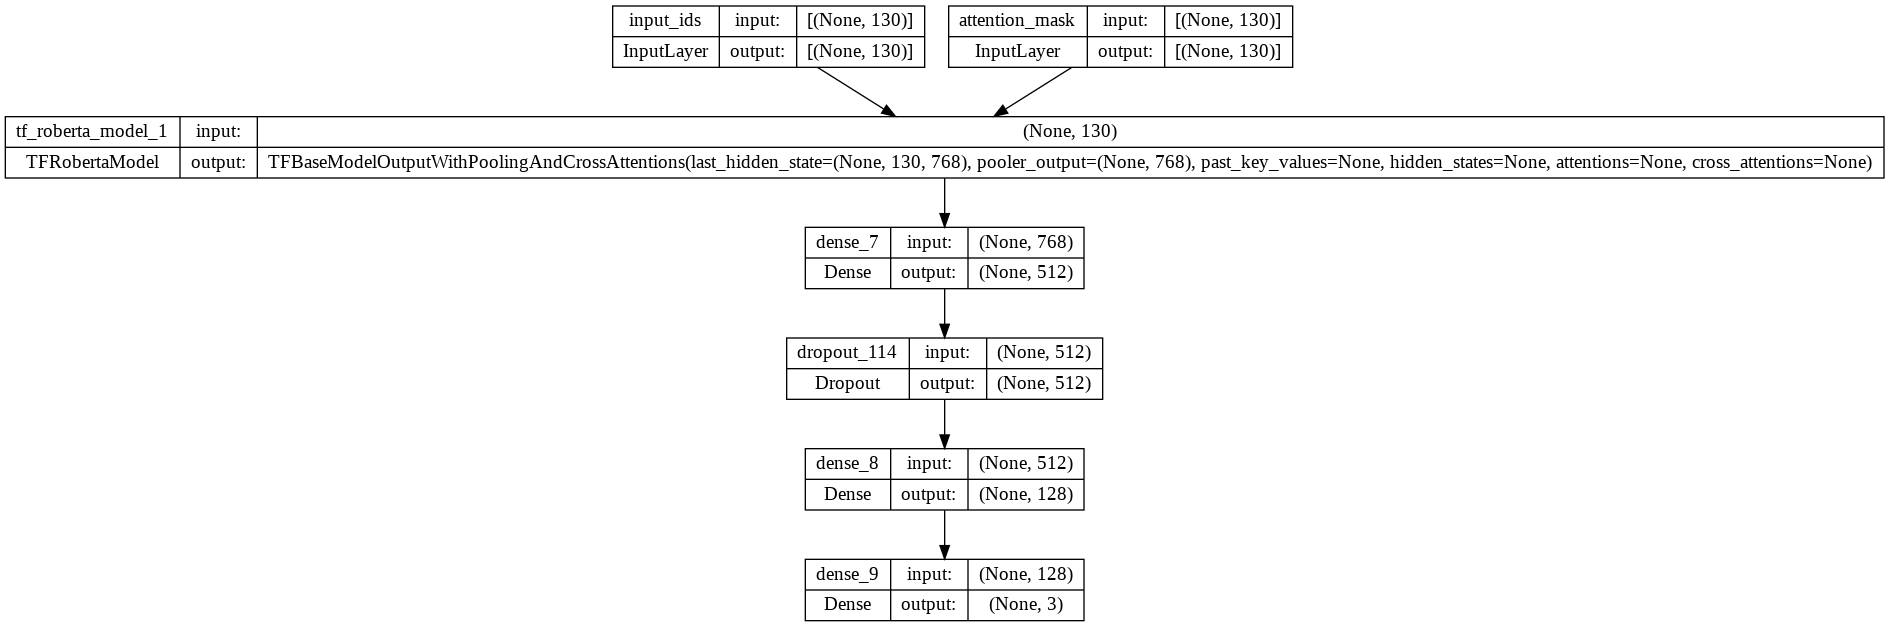

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2
337/337 [==============================] - 118s 302ms/step - loss: 0.8455 - balanced_accuracy: 0.6186 - val_loss: 0.6867 - val_balanced_accuracy: 0.7370
Epoch 2/2
337/337 [==============================] - 95s 283ms/step - loss: 0.6145 - balanced_accuracy: 0.7755 - val_loss: 0.6830 - val_balanced_accuracy: 0.7474


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 9s 266ms/step


array([2, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.859     0.732     0.790       291
           1      0.647     0.641     0.644       117
           2      0.696     0.811     0.749       265

    accuracy                          0.747       673
   macro avg      0.734     0.728     0.728       673
weighted avg      0.758     0.747     0.749       673



##m6

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state
x = GlobalMaxPool1D()(embeddings)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

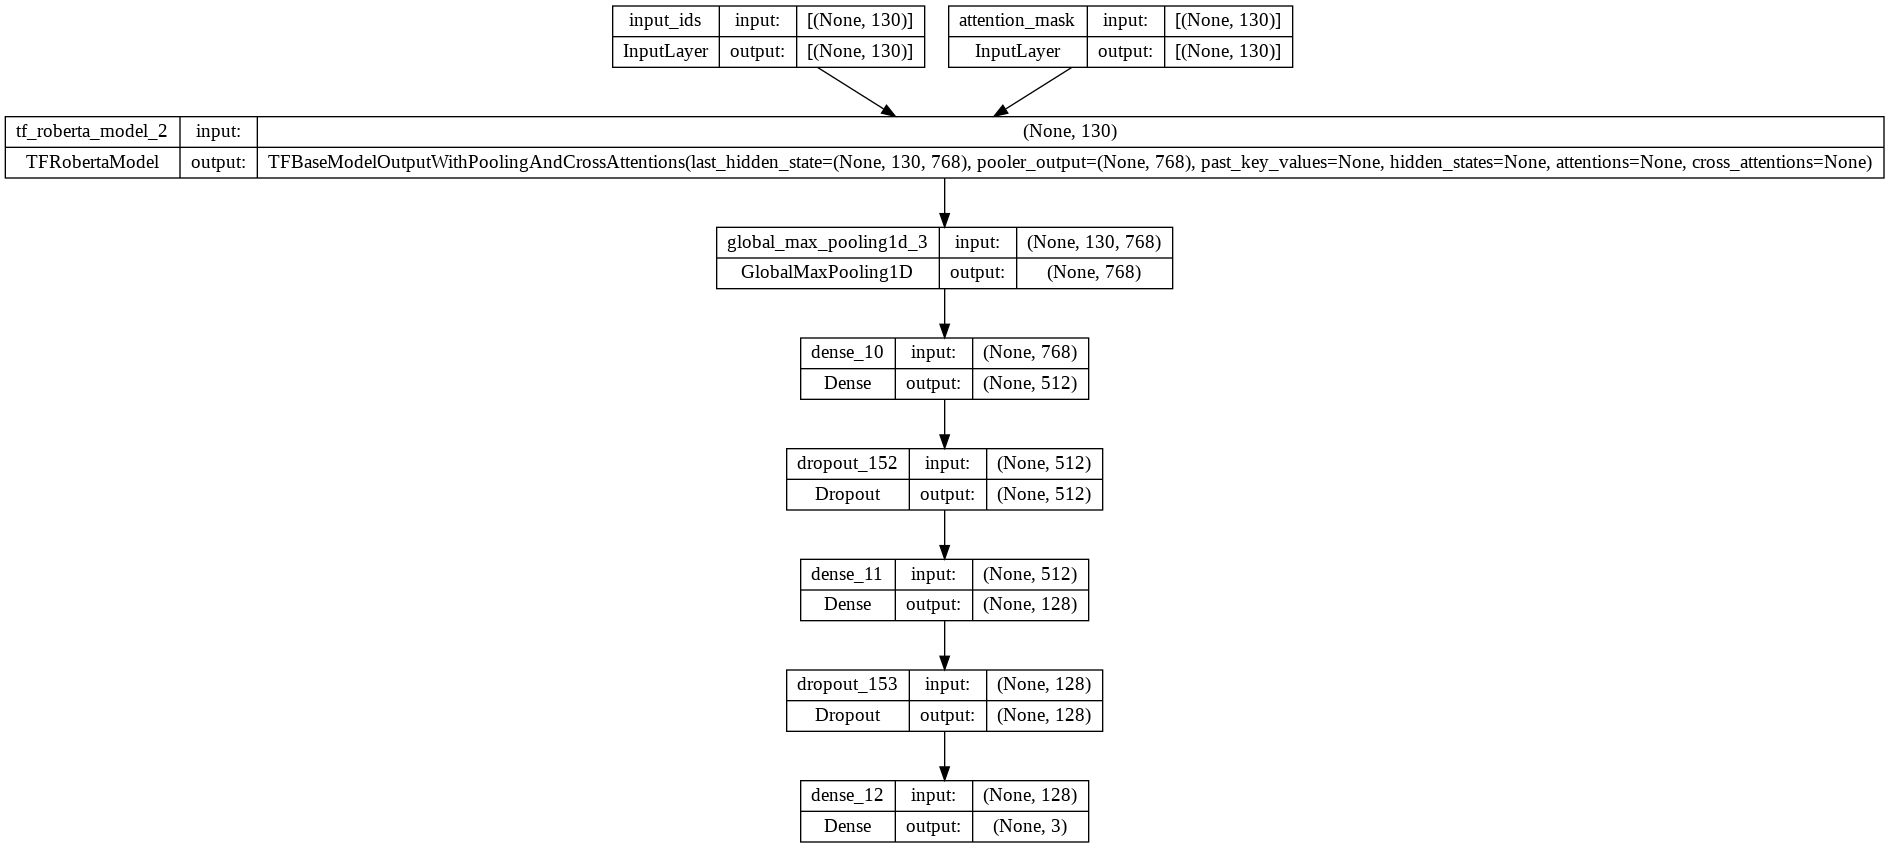

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 2e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

#model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 3

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/3


337/337 [==============================] - 120s 305ms/step - loss: 1.0448 - balanced_accuracy: 0.4796 - val_loss: 0.9257 - val_balanced_accuracy: 0.6018
Epoch 2/3
337/337 [==============================] - 96s 286ms/step - loss: 0.8540 - balanced_accuracy: 0.6342 - val_loss: 0.8208 - val_balanced_accuracy: 0.6686
Epoch 3/3
337/337 [==============================] - 94s 280ms/step - loss: 0.7471 - balanced_accuracy: 0.7004 - val_loss: 0.7707 - val_balanced_accuracy: 0.6865


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 8s 255ms/step


array([2, 0, 2])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.809     0.698     0.749       291
           1      0.763     0.248     0.374       117
           2      0.599     0.868     0.709       265

    accuracy                          0.686       673
   macro avg      0.724     0.604     0.611       673
weighted avg      0.718     0.686     0.668       673



##m7

In [ ]:
abuse=load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/abuseLexicon.xlsx")
lep_lex=load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/lepAnLexicon2.csv")
lep_lex.head(1)

,word,freq,word_pos,pos_VERB,pos_NOUN,pos_ADJ,pos_PROPN,pos_ADV,category
0,fuck,1.0,VERB,1,0,0,0.0,0.0,P-


In [ ]:
abus_words = set(abuse.word.values)
lep_words = set(lep_lex.word.values)

In [ ]:
#!pip install -U spacy --quiet

# install Spacy language model 
!python -m spacy download en_core_web_lg --quiet

# import Spacy and load model nlp()
import spacy
nlp = spacy.load('en_core_web_lg')

     |████████████████████████████████| 6.4 MB 18.2 MB/s 
     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc if (not token.is_punct and len(token) > 1)]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data

In [ ]:
def transform_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    dep_column.append([token.dep_ for token in doc])
    pos_column.append([token.pos_ for token in doc])
    ent_column.append([token.label_ for token in doc.ents if (token.label_ == 'PERSON' or token.label_ == 'ORG') ])
  
  data["Text_dep"] = dep_column
  data["Text_pos"] = pos_column
  data["Text_ent"] = ent_column
  return data

In [ ]:
df_ethos = lemma_text(df_ethos, text_column = 'Text')
df_ethos.tail(1)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,pathos_label,pathos_name,ethos_name,logos_name,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized
3362,22688,Then 6 months later you need a booster booster...,Hunterxb1021,NaN,1.0,NaN,NaN,NaN,0,NaN,...,-1,negative,neutral,support,Then 6 months later you need a booster booster...,then 6 month later you need a booster booster ...,joy,1.0,0.691982,then month later you need booster booster and ...


In [ ]:
df_ethos = transform_text(df_ethos, 'Text_lemmatized')
df_ethos['Text_ent'] = df_ethos['Text_ent'].apply(lambda x: " ".join(x))

In [ ]:
prons = {'he', 'she', 'you', 'they', 'sander', 'Trump', 'Clinton'}

for i in df_ethos[df_ethos.Text_ent.map(len) < 2].index:
  txt_lem = df_ethos.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos.loc[i, 'Text_ent'] = ['PERSON']

df_ethos.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,he's killing it,he be kill it,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",PERSON,DEP: nsubj aux ROOT dobj. POS: PRON AUX VERB P...
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Sanders has some good points,sander have some good point,joy,NaN,NaN,sander have some good point,"[nsubj, ROOT, det, amod, dobj]","[NOUN, VERB, DET, ADJ, NOUN]",PERSON,DEP: nsubj ROOT det amod dobj. POS: NOUN VERB ...


In [ ]:

df_ethos['text_feat'] = 'DEP: '+df_ethos.Text_dep.apply(lambda x: " ".join(x))+". POS: "+ df_ethos.Text_pos.apply(lambda x: " ".join(x))+'. NER: '+ df_ethos.Text_ent
df_ethos.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,he's killing it,he be kill it,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",PERSON,DEP: nsubj aux ROOT dobj. POS: PRON AUX VERB P...
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Sanders has some good points,sander have some good point,joy,NaN,NaN,sander have some good point,"[nsubj, ROOT, det, amod, dobj]","[NOUN, VERB, DET, ADJ, NOUN]",PERSON,DEP: nsubj ROOT det amod dobj. POS: NOUN VERB ...


In [ ]:
df_ethos['offens'] = df_ethos.Text_lemmatized.apply(lambda x: set(x.lower().split()).intersection(abus_words))
df_ethos['lepAN'] = df_ethos.Text_lemmatized.apply(lambda x: set(x.lower().split()).intersection(lep_words))


In [ ]:
df_ethos['add_text'] = df_ethos['offens'].apply(lambda x: " ".join(x)) + " " + df_ethos['lepAN'].apply(lambda x: " ".join(x))


In [ ]:
df_ethos['add_text'] = np.where(df_ethos['add_text'].map(len) < 2, 'nan', df_ethos['add_text'])

In [ ]:
df_ethos.iloc[990:992]

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat,offens,lepAN,add_text,ent_PERSON
990,10541,his screaming and gesticulating reminds me of ...,Thrownawayactually,Trump,0.0,1.0,0.0,1.0,2,0.0,...,NaN,his screaming and gesticulating remind I of ce...,"[poss, nsubj, cc, conj, ROOT, dobj, prep, amod...","[PRON, NOUN, CCONJ, VERB, VERB, PRON, ADP, ADJ...",PERSON,DEP: poss nsubj cc conj ROOT dobj prep amod nu...,{},{},nan,1.0
991,10541,gut reactions to a man screaming at a woman li...,shagfoal,Trump,0.0,1.0,0.0,1.0,2,0.0,...,NaN,gut reaction to man scream at woman like psych...,"[compound, nsubj, prep, pobj, ROOT, prep, pobj...","[NOUN, NOUN, ADP, NOUN, VERB, ADP, NOUN, ADP, ...",,DEP: compound nsubj prep pobj ROOT prep pobj p...,{psychopath},{scream},psychopath scream,NaN


In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
df_ethos = clean_text(df_ethos, 'Text')
df_ethos.tail(3)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat,offens,lepAN,add_text
3360,24228,No,Legitimate_Ad416,NaN,1.0,NaN,NaN,NaN,0,1.0,...,2.0,0.407747,no,[ROOT],[INTJ],,DEP: ROOT. POS: INTJ. NER:,{},{},nan
3361,10496,corporate is staying Manufacturing is leaving,thelazt1,NaN,1.0,0.0,NaN,NaN,0,1.0,...,NaN,NaN,corporate be stay manufacturing be leave,"[amod, aux, advcl, xcomp, auxpass, ROOT]","[ADJ, AUX, VERB, NOUN, AUX, VERB]",,DEP: amod aux advcl xcomp auxpass ROOT. POS: A...,{},{},nan
3362,22688,Then months later you need a booster booster a...,Hunterxb1021,NaN,1.0,NaN,NaN,NaN,0,NaN,...,1.0,0.691982,then month later you need booster booster and ...,"[advmod, npadvmod, advmod, nsubj, ROOT, compou...","[ADV, NOUN, ADV, PRON, VERB, NOUN, NOUN, CCONJ...",PERSON,DEP: advmod npadvmod advmod nsubj ROOT compoun...,{},{},nan


In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(2690, 673)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:
from tensorflow.keras.layers import TextVectorization
max(df_ethos_tr.text_feat.str.split().map(len)), max(df_ethos_tr.add_text.str.split().map(len))

(266, 4)

In [ ]:
df_ethos_tr.text_feat.tolist()[:3]

['DEP: advmod ROOT nsubj ccomp dobj prep pobj cc det amod conj advmod advmod advmod. POS: ADV VERB PRON VERB NOUN ADP NOUN CCONJ DET ADJ NOUN ADP ADV ADV. NER: PERSON',
 'DEP: ROOT nsubj acomp nsubj ccomp det dobj. POS: AUX PRON ADJ PRON VERB DET NOUN. NER: PERSON',
 'DEP: compound nsubj ROOT attr. POS: NOUN NOUN AUX NUM. NER: ']

In [ ]:
x_feat = df_ethos_tr.text_feat.tolist()

vectorizer = TextVectorization(output_sequence_length=275)
text_ds = tf.data.Dataset.from_tensor_slices(x_feat).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()

num_tokens = len(voc) + 2
embedding_dim = 50

num_tokens

66

In [ ]:
x_ep = df_ethos_tr.add_text.tolist()

vectorizer_ep = TextVectorization(output_sequence_length=4)
text_ds_ep = tf.data.Dataset.from_tensor_slices(x_ep).batch(128)
vectorizer_ep.adapt(text_ds_ep)

voc_ep = vectorizer_ep.get_vocabulary()

num_tokens_ep = len(voc_ep) + 2
embedding_dim_ep = 25

num_tokens_ep

182

In [ ]:
add_ttr = df_ethos_tr['add_text'].values
add_tts = df_ethos_ts['add_text'].values

add_ftr = df_ethos_tr['text_feat'].values
add_fts = df_ethos_ts['text_feat'].values


In [ ]:

add_ttr = vectorizer_ep(np.array([[s] for s in add_ttr])).numpy()
add_tts = vectorizer_ep(np.array([[s] for s in add_tts])).numpy()

add_ftr = vectorizer(np.array([[s] for s in add_ftr])).numpy()
add_fts = vectorizer(np.array([[s] for s in add_fts])).numpy()
add_ftr[:1]

array([[ 8, 15,  9,  7, 24, 18, 14, 16, 29,  6, 20, 28, 15, 15, 15, 10,
        17,  3,  5,  3,  2, 12,  2, 27,  6, 13,  2, 12, 17, 17, 11, 19,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

In [ ]:
add_ttr[:3]

array([[2, 0, 0, 0],
       [2, 0, 0, 0],
       [2, 0, 0, 0]])

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
add_fts.shape[1], add_tts.shape[1]

(275, 4)

In [ ]:

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

input_text1 = keras.Input(shape = (add_fts.shape[1],), dtype = np.int32, name = 'featPOSDEPENT')
input_text2 = keras.Input(shape = (add_tts.shape[1],), dtype = np.int32, name = 'txtEPabuse')

input_layer1= layers.Embedding(num_tokens, 50, input_length=275, trainable=True)
input_layer2 = layers.Embedding(num_tokens_ep, 25, input_length=4, trainable=True)

x_text1 = input_layer1(input_text1)
x_text1 = GlobalMaxPool1D()(x_text1)
x_text1 = Dense(128, activation = 'relu')(x_text1)

x_text2 = input_layer2(input_text2)
x_text2 = GlobalMaxPool1D()(x_text2)

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last hidden state
x = GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.Concatenate(axis=1)([x, x_text1, x_text2])
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask, input_text1, input_text2], outputs = y)

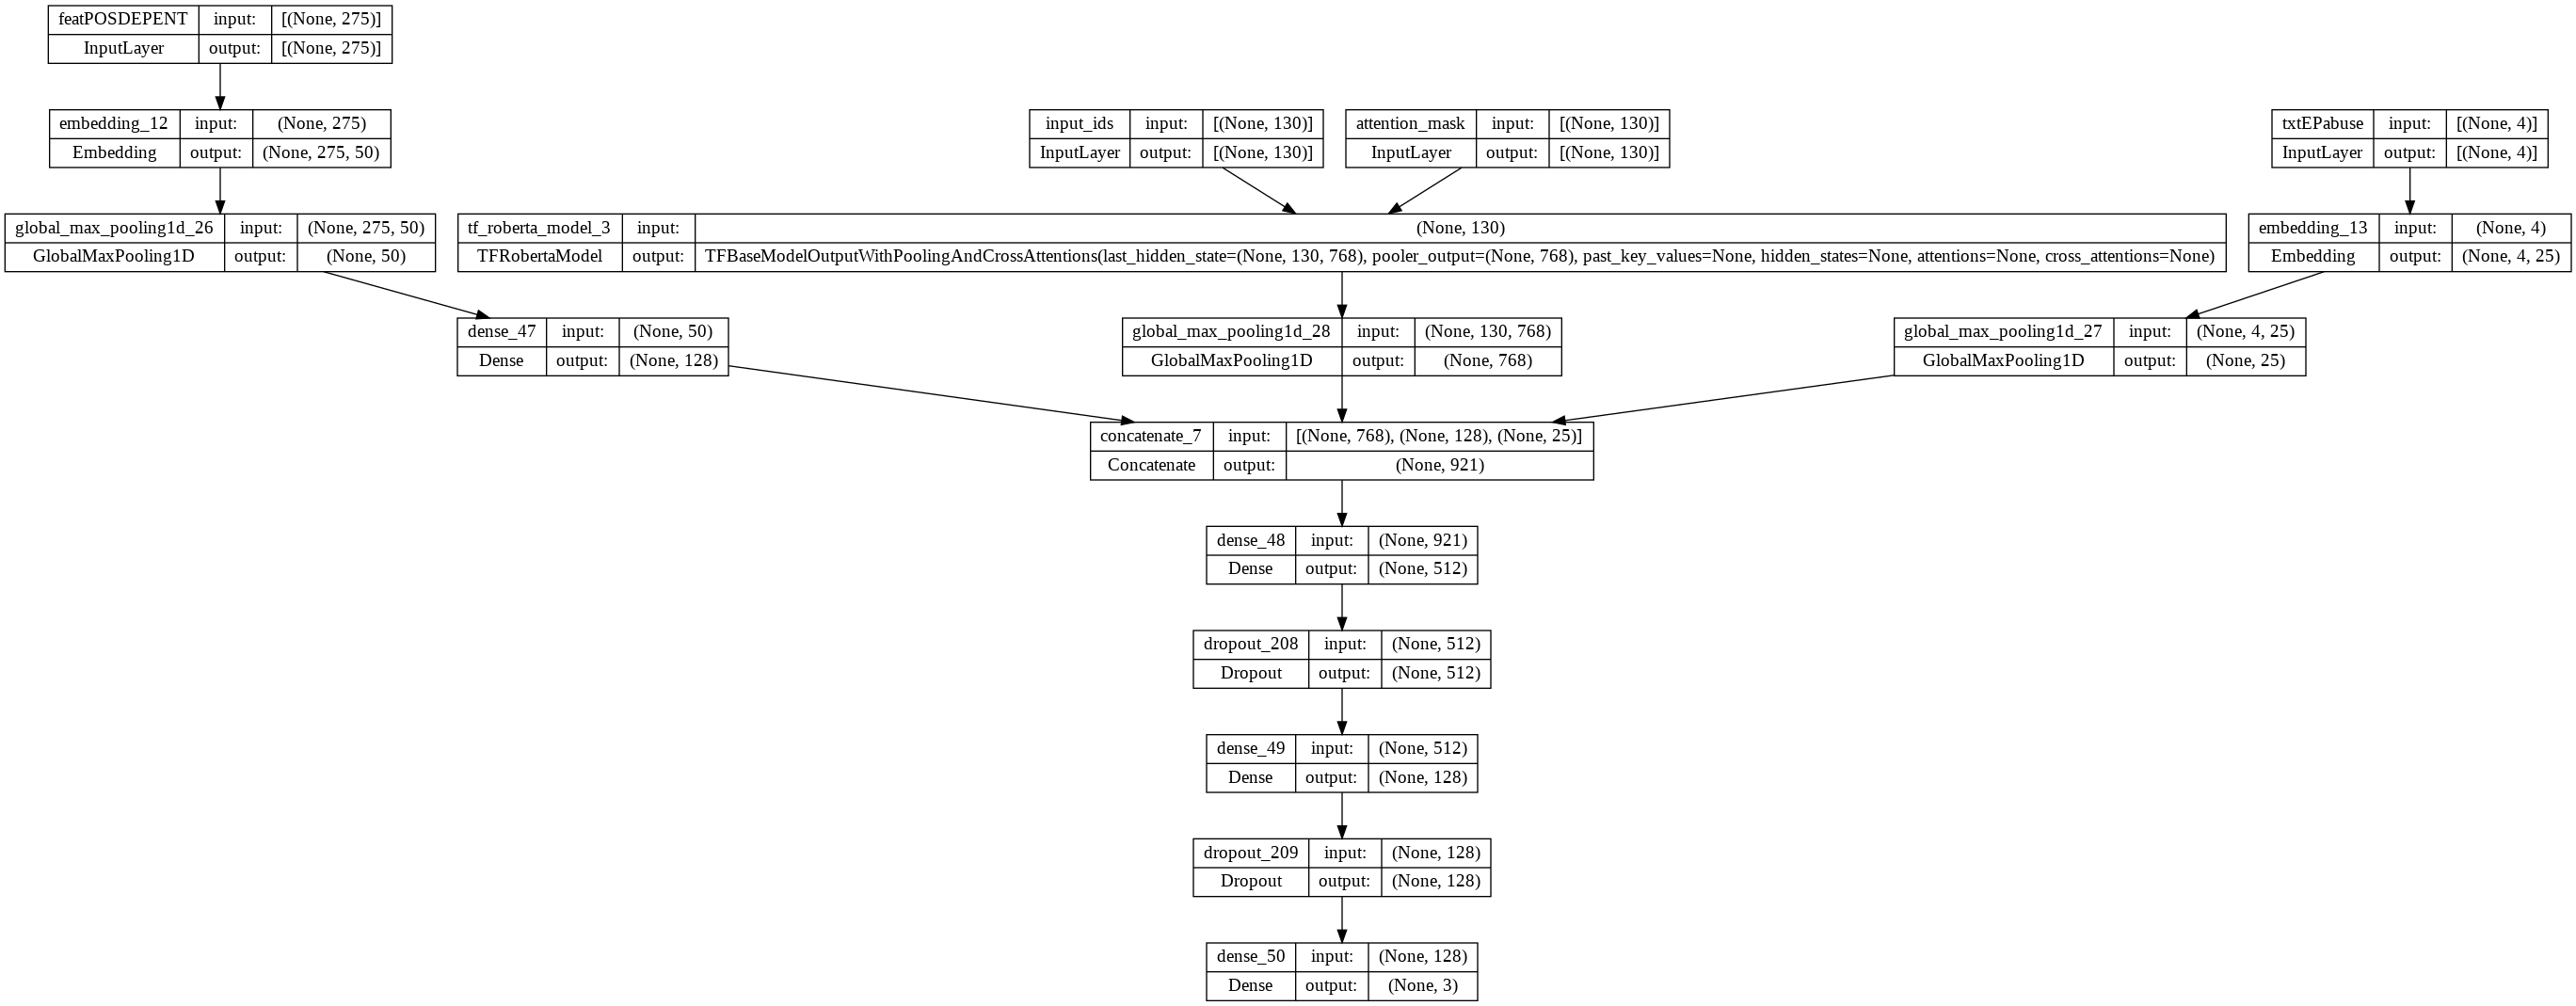

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 featPOSDEPENT (InputLayer)     [(None, 275)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 275, 50)      3350        ['featPOSDEPENT[0][0]']          
                                                                                            

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')


model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 3

In [ ]:
# fancy
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         'txtEPabuse': add_ttr, 'featPOSDEPENT':add_ftr, 
                         }, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         'txtEPabuse': add_tts, 'featPOSDEPENT':add_fts,
                                         }, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


337/337 [==============================] - 125s 294ms/step - loss: 0.6292 - balanced_accuracy: 0.7699 - val_loss: 0.6608 - val_balanced_accuracy: 0.7533
Epoch 2/2
337/337 [==============================] - 95s 282ms/step - loss: 0.4103 - balanced_accuracy: 0.8677 - val_loss: 0.6477 - val_balanced_accuracy: 0.7563


In [ ]:
# fancy

predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                           'txtEPabuse': add_tts, 'featPOSDEPENT':add_fts, 
                           }) # 'ttest': ttest_ts
y_pred = np.argmax(predicted, axis = -1)
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.822     0.777     0.799       291
           1      0.633     0.692     0.661       117
           2      0.748     0.762     0.755       265

    accuracy                          0.756       673
   macro avg      0.734     0.744     0.738       673
weighted avg      0.760     0.756     0.758       673



##m8

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.MaxPool1D(3)(x)
x = layers.Conv1D(128, 3, activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

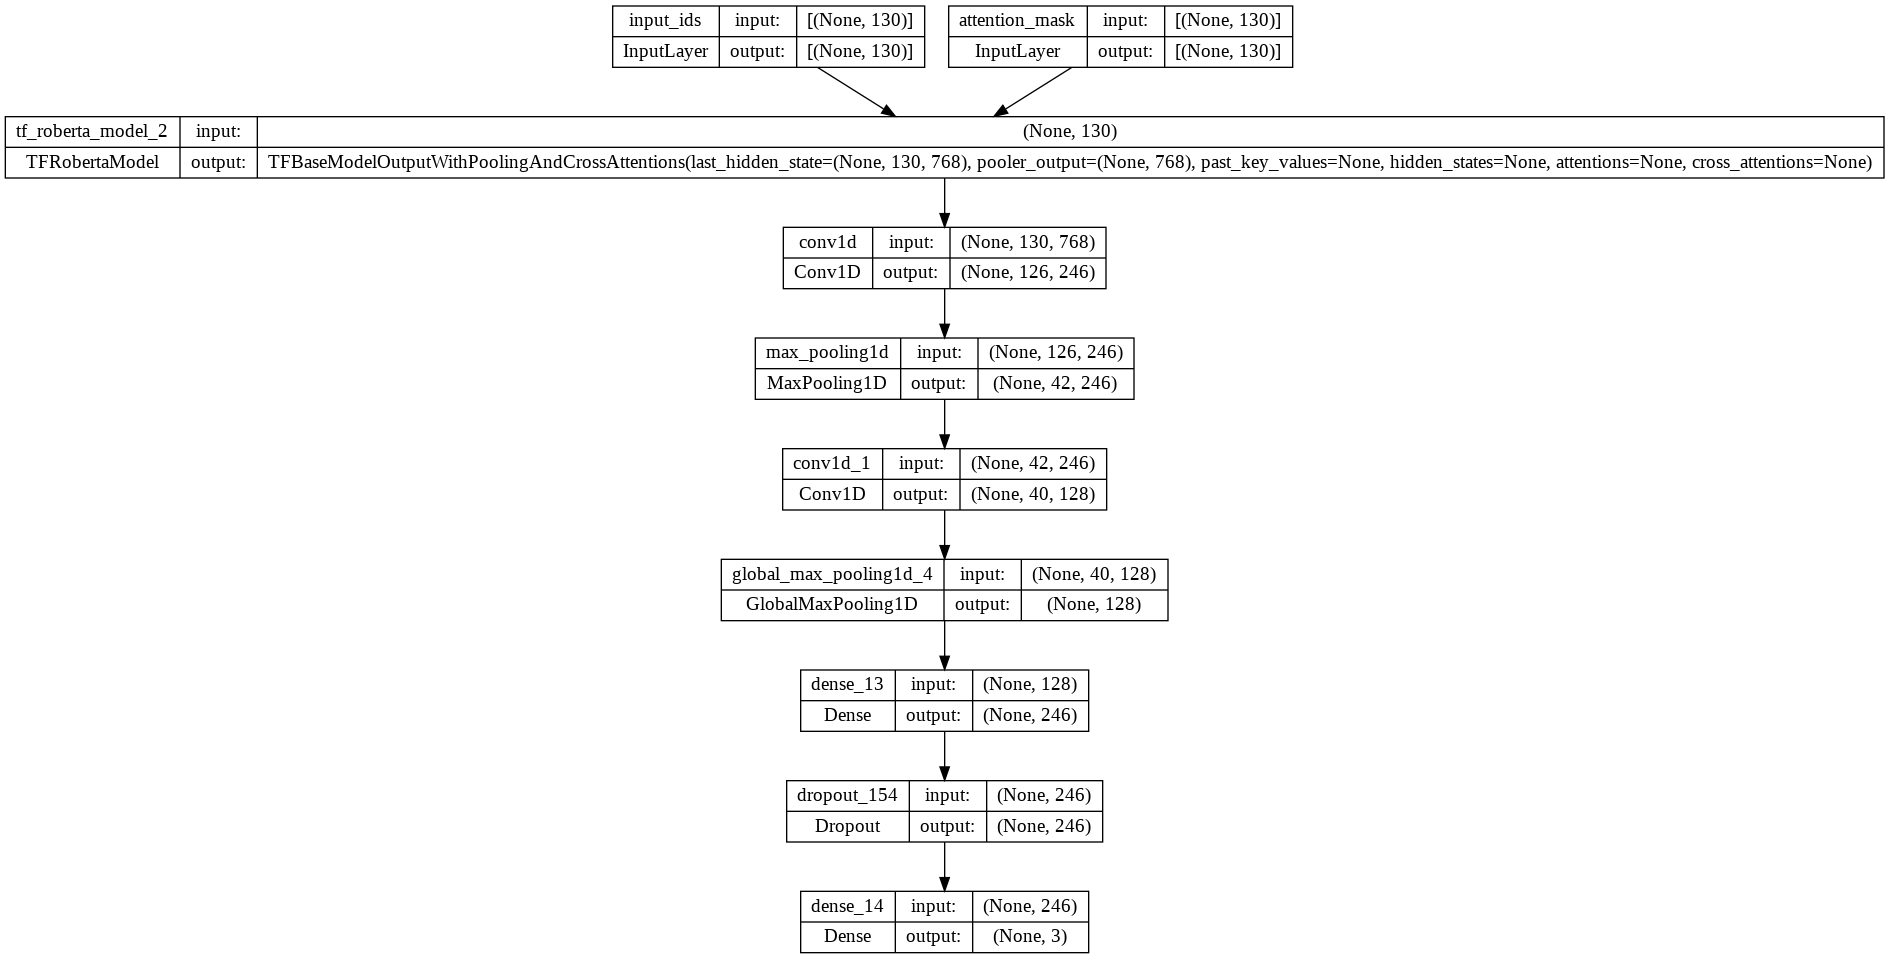

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


337/337 [==============================] - 119s 290ms/step - loss: 0.8959 - balanced_accuracy: 0.5855 - val_loss: 0.7528 - val_balanced_accuracy: 0.7132
Epoch 2/2
337/337 [==============================] - 96s 284ms/step - loss: 0.6258 - balanced_accuracy: 0.7673 - val_loss: 0.6805 - val_balanced_accuracy: 0.7370


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer
y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

22/22 [==============================] - 9s 255ms/step


array([1, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.851     0.746     0.795       291
           1      0.636     0.701     0.667       117
           2      0.720     0.785     0.751       265

    accuracy                          0.753       673
   macro avg      0.735     0.744     0.737       673
weighted avg      0.762     0.753     0.755       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# train 2

              precision    recall  f1-score   support

           0      0.832     0.784     0.807       291
           1      0.732     0.607     0.664       117
           2      0.709     0.808     0.755       265

    accuracy                          0.762       673
   macro avg      0.758     0.733     0.742       673
weighted avg      0.766     0.762     0.762       673



##m9

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base" # "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

In [ ]:
bert.config

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.GlobalMaxPool1D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

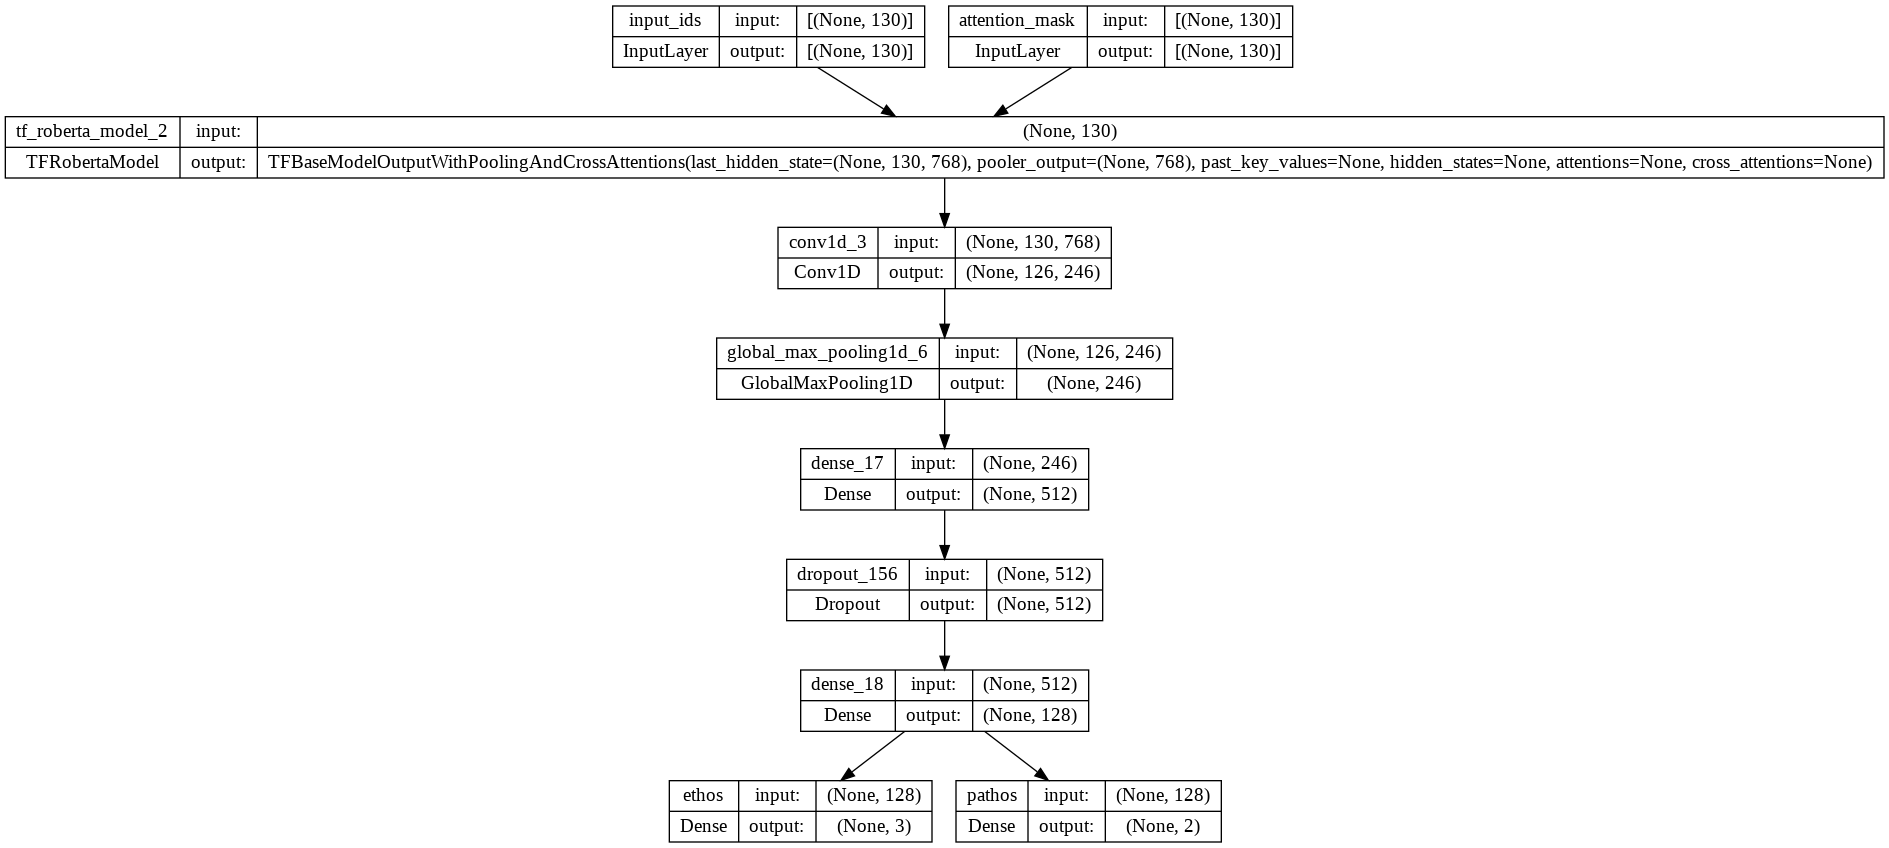

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                        

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)


In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


337/337 [==============================] - 118s 298ms/step - loss: 0.7802 - ethos_loss: 0.2657 - pathos_loss: 0.5145 - ethos_balanced_accuracy: 0.9249 - pathos_balanced_accuracy: 0.7483 - val_loss: 1.3052 - val_ethos_loss: 0.7679 - val_pathos_loss: 0.5373 - val_ethos_balanced_accuracy: 0.7578 - val_pathos_balanced_accuracy: 0.7311
Epoch 2/2
337/337 [==============================] - 95s 283ms/step - loss: 0.5880 - ethos_loss: 0.1553 - pathos_loss: 0.4326 - ethos_balanced_accuracy: 0.9625 - pathos_balanced_accuracy: 0.8112 - val_loss: 1.3267 - val_ethos_loss: 0.7741 - val_pathos_loss: 0.5526 - val_ethos_balanced_accuracy: 0.7563 - val_pathos_balanced_accuracy: 0.7192


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})


22/22 [==============================] - 8s 255ms/step


In [ ]:
# multi-task

y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos

y_pred[:5], y_pred2[:5]

(array([2, 0, 0, 1, 2]), array([1, 1, 1, 1, 0]))

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3)) 


Ethos
               precision    recall  f1-score   support

           0      0.833     0.790     0.811       291
           1      0.630     0.641     0.636       117
           2      0.734     0.770     0.751       265

    accuracy                          0.756       673
   macro avg      0.732     0.734     0.733       673
weighted avg      0.759     0.756     0.757       673

Pathos
               precision    recall  f1-score   support

           0      0.589     0.602     0.595       231
           1      0.789     0.781     0.785       442

    accuracy                          0.719       673
   macro avg      0.689     0.691     0.690       673
weighted avg      0.721     0.719     0.720       673



##m9.2

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base" # "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.str.lower().tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.str.lower().tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] # pooler
#x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
#x = layers.GlobalMaxPool1D()(x)
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
x2 = Dense(128, activation = 'relu')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x2)

x1 = layers.Concatenate(axis=1)([y2, x])
x1 = Dense(128, activation = 'relu')(x1)
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x1)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

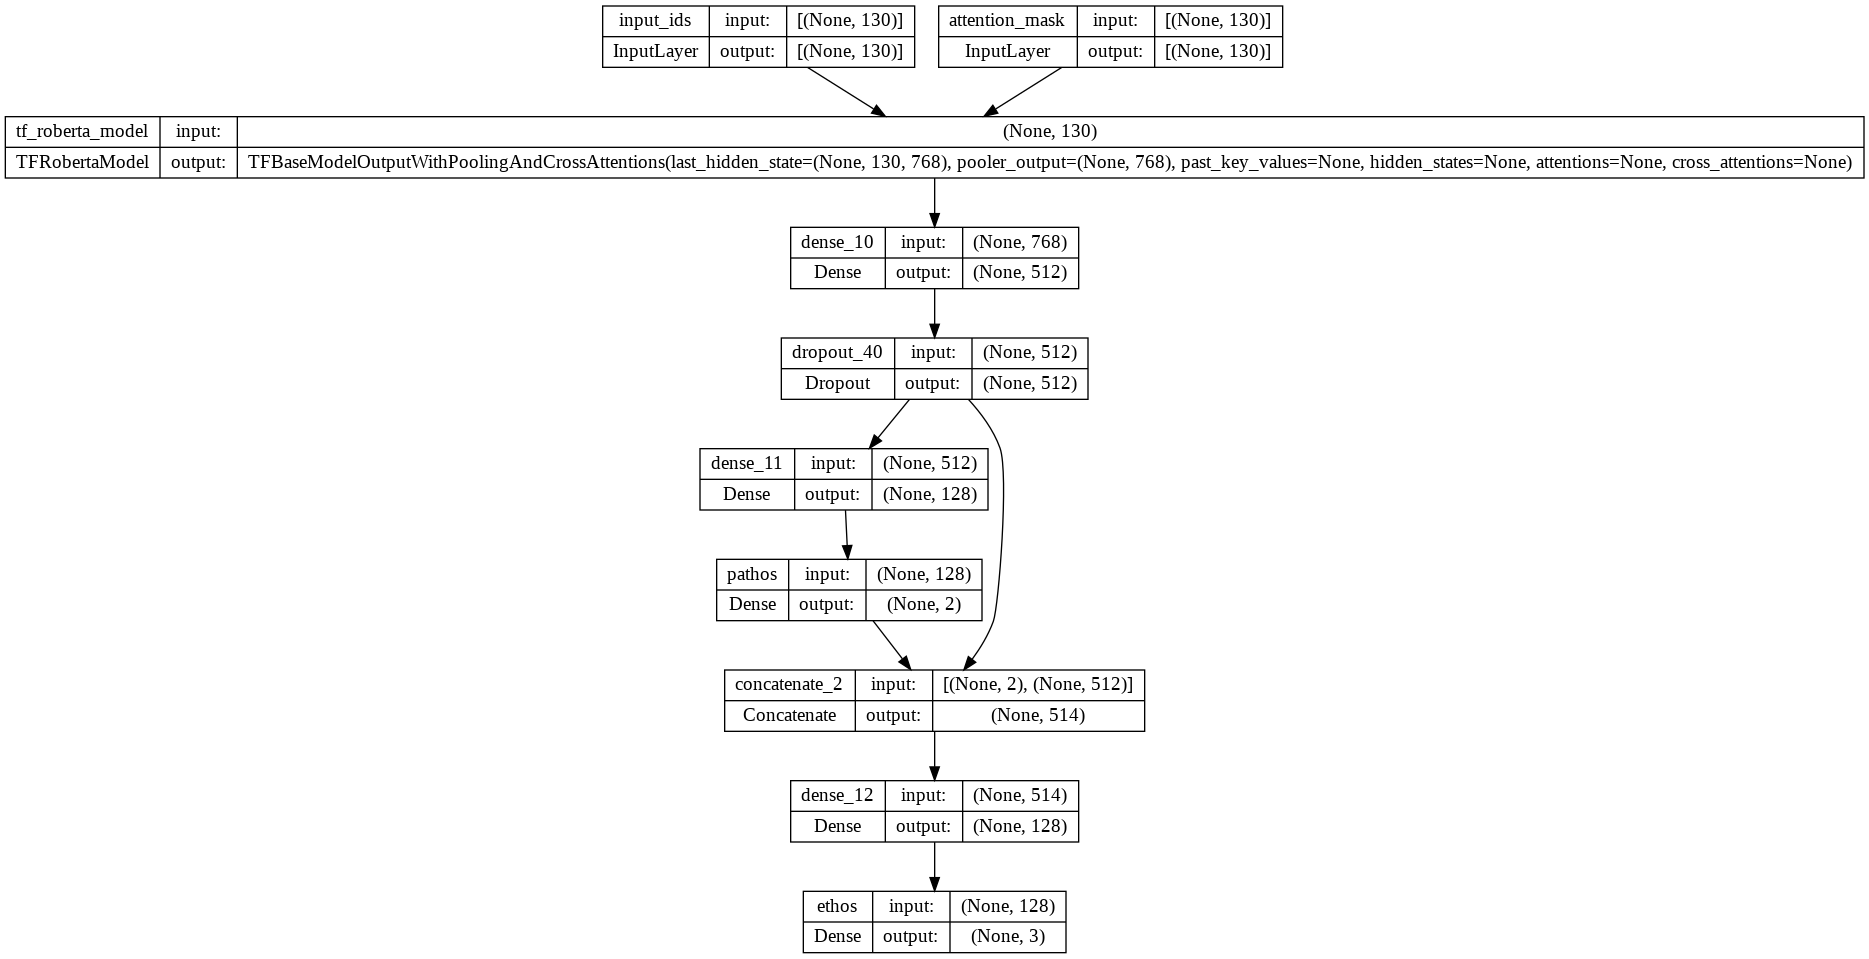

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # v2.2

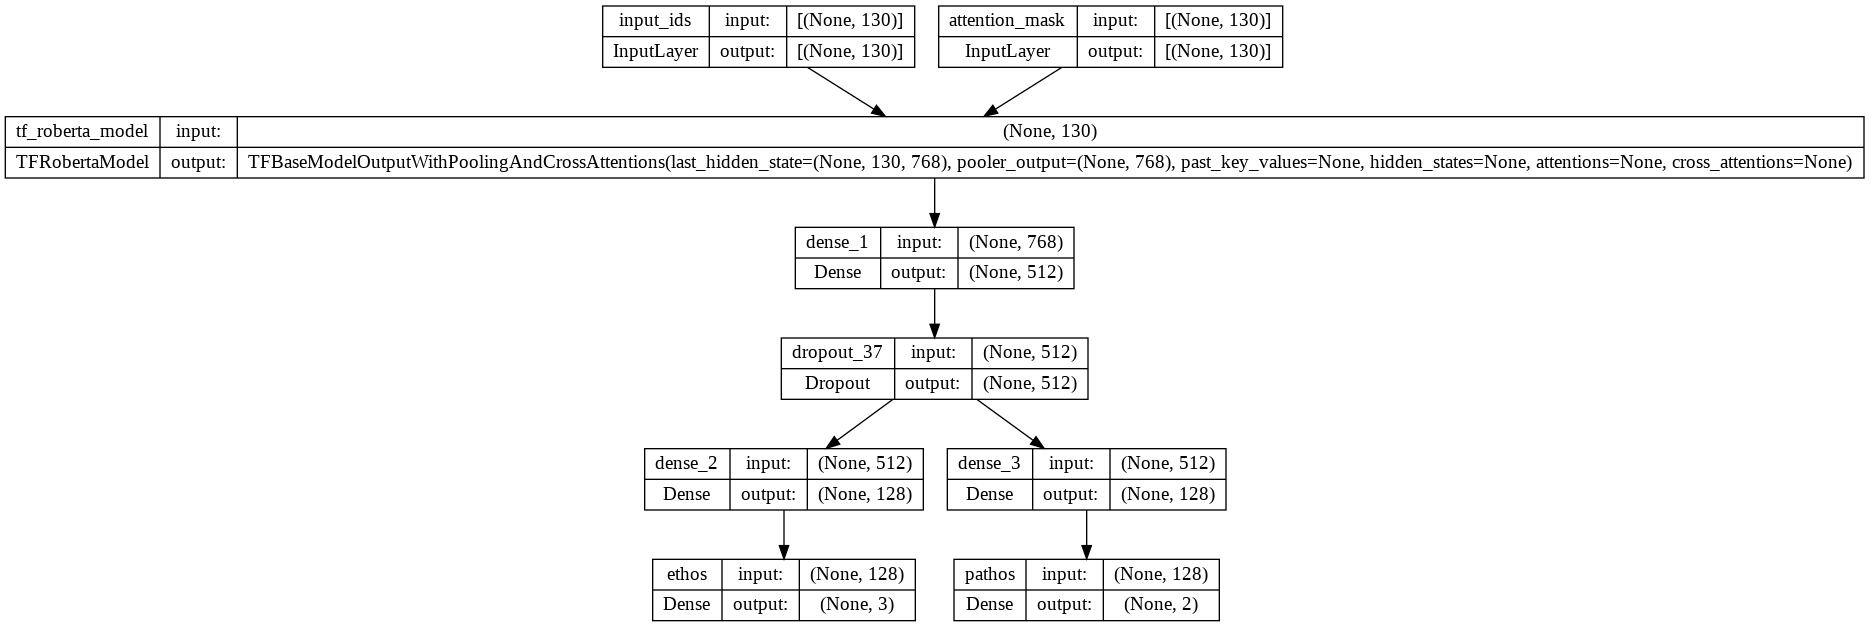

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True) # v2.1

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)


In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2
337/337 [==============================] - 120s 306ms/step - loss: 1.1674 - ethos_loss: 0.6465 - pathos_loss: 0.5209 - ethos_balanced_accuracy: 0.7587 - pathos_balanced_accuracy: 0.7539 - val_loss: 1.1802 - val_ethos_loss: 0.6530 - val_pathos_loss: 0.5272 - val_ethos_balanced_accuracy: 0.7548 - val_pathos_balanced_accuracy: 0.7459
Epoch 2/2
337/337 [==============================] - 97s 287ms/step - loss: 0.9349 - ethos_loss: 0.4785 - pathos_loss: 0.4564 - ethos_balanced_accuracy: 0.8342 - pathos_balanced_accuracy: 0.7918 - val_loss: 1.1899 - val_ethos_loss: 0.6561 - val_pathos_loss: 0.5338 - val_ethos_balanced_accuracy: 0.7623 - val_pathos_balanced_accuracy: 0.7444


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})


22/22 [==============================] - 13s 265ms/step


In [ ]:
# multi-task

y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos

y_pred[:5], y_pred2[:5]

(array([2, 0, 0, 1, 2]), array([1, 1, 1, 1, 0]))

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3)) 
# v2.1

Ethos
               precision    recall  f1-score   support

           0      0.825     0.759     0.791       291
           1      0.636     0.641     0.638       117
           2      0.704     0.762     0.732       265

    accuracy                          0.740       673
   macro avg      0.721     0.721     0.720       673
weighted avg      0.744     0.740     0.741       673

Pathos
               precision    recall  f1-score   support

           0      0.649     0.623     0.636       231
           1      0.807     0.824     0.815       442

    accuracy                          0.755       673
   macro avg      0.728     0.723     0.725       673
weighted avg      0.753     0.755     0.754       673



In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3)) 
# v2.2

Ethos
               precision    recall  f1-score   support

           0      0.826     0.814     0.820       291
           1      0.661     0.667     0.664       117
           2      0.739     0.747     0.743       265

    accuracy                          0.762       673
   macro avg      0.742     0.743     0.742       673
weighted avg      0.763     0.762     0.763       673

Pathos
               precision    recall  f1-score   support

           0      0.677     0.489     0.568       231
           1      0.767     0.878     0.819       442

    accuracy                          0.744       673
   macro avg      0.722     0.684     0.693       673
weighted avg      0.736     0.744     0.733       673



##m9.3 - meta-learning idea

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base" # "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

In [ ]:
bert.config

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] # pool
#x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
#x = layers.GlobalMaxPool1D()(x)
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y = Dense(3, activation = 'softmax', name = 'ethos')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

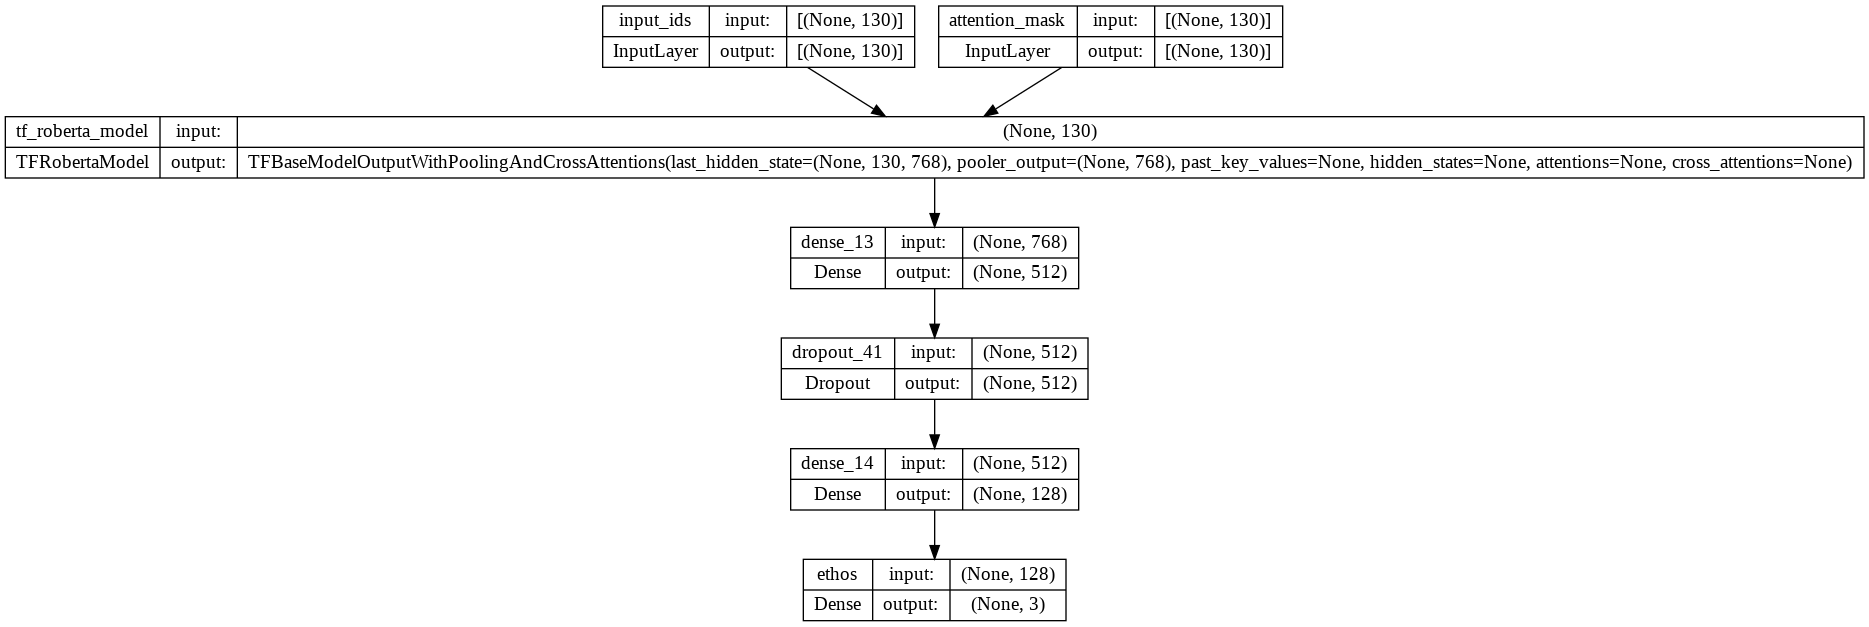

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)


In [ ]:
batch_size = 8
epoch = 2 #(2+2)

In [ ]:
# to_categorical(df_ethos_tr.Ethos_Label.tolist()) then with these labels
# to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':2}).tolist()) first some training

# to_categorical(df_ethos_ts.Ethos_Label.tolist())
# to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':2}).tolist())

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y =  to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                        to_categorical(df_ethos_ts.Ethos_Label.tolist())
                                       ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2
337/337 [==============================] - 97s 287ms/step - loss: 0.6638 - balanced_accuracy: 0.7368 - val_loss: 0.6730 - val_balanced_accuracy: 0.7444
Epoch 2/2
337/337 [==============================] - 96s 286ms/step - loss: 0.4594 - balanced_accuracy: 0.8346 - val_loss: 0.6805 - val_balanced_accuracy: 0.7519


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})


22/22 [==============================] - 9s 260ms/step


In [ ]:

y_pred = np.argmax(predicted, axis = -1) 
y_pred[:5]

array([2, 0, 0, 1, 2])

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 


Ethos
               precision    recall  f1-score   support

           0      0.829     0.766     0.796       291
           1      0.636     0.718     0.675       117
           2      0.732     0.751     0.741       265

    accuracy                          0.752       673
   macro avg      0.732     0.745     0.737       673
weighted avg      0.757     0.752     0.754       673



##m10

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base" #"bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

In [ ]:
bert.config

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
hil2['Text'] = hil2.Text.apply(str)
hil2[hil2.Text.map(len) > 2].shape, hil2.shape
#hil2.head(2)

((7618, 16), (7672, 16))

In [ ]:
hil2 = hil2[hil2.Text.map(len) > 2]

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] # pooler
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y1 = Dense(3, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

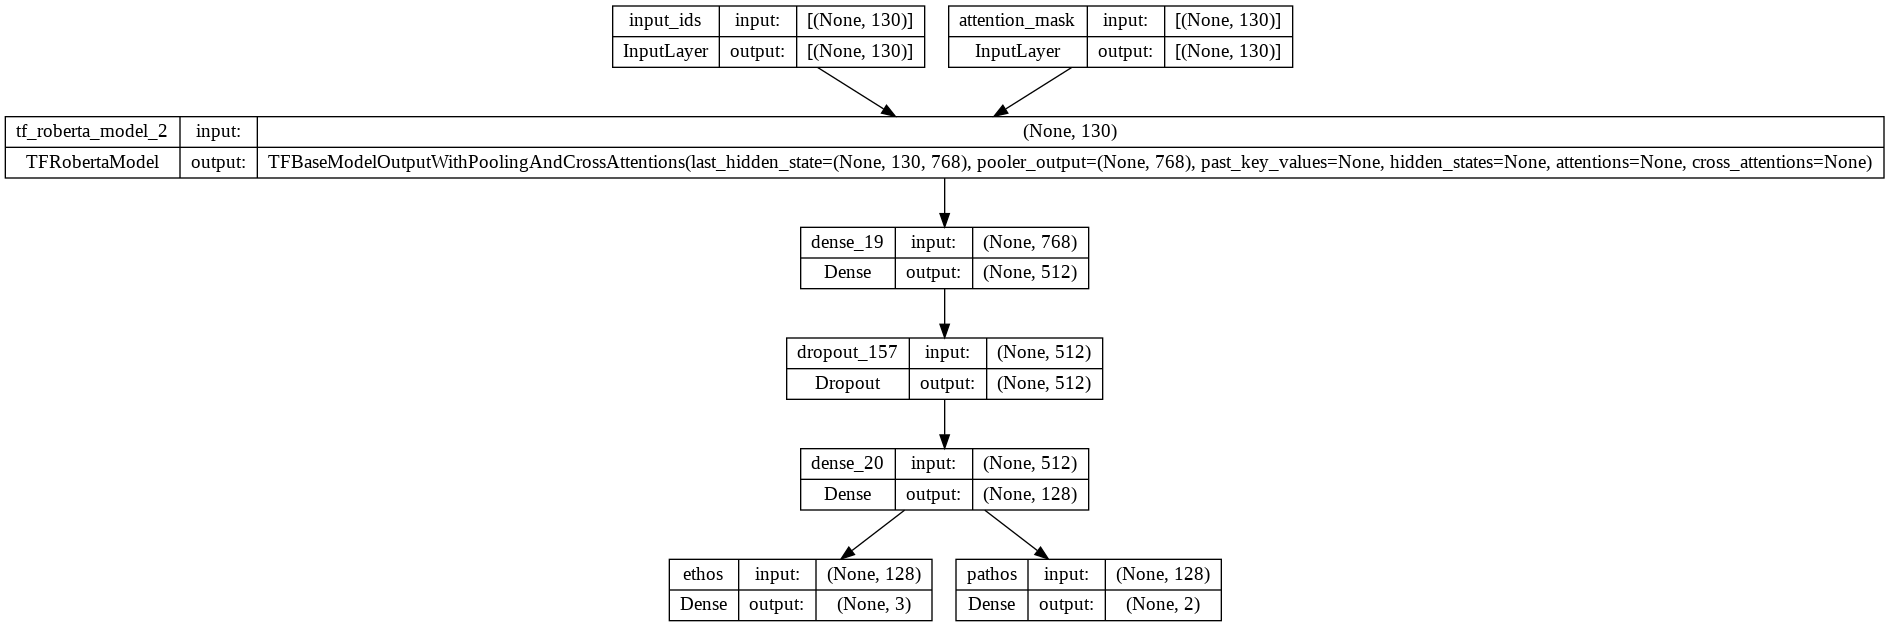

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 130)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 130)]        0           []                               
                                                                                                  
 tf_roberta_model_2 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 130,                                         

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 2e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)


In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/3
337/337 [==============================] - 117s 297ms/step - loss: 0.9334 - ethos_loss: 0.3856 - pathos_loss: 0.5478 - ethos_balanced_accuracy: 0.8970 - pathos_balanced_accuracy: 0.7193 - val_loss: 1.3300 - val_ethos_loss: 0.7904 - val_pathos_loss: 0.5396 - val_ethos_balanced_accuracy: 0.7415 - val_pathos_balanced_accuracy: 0.7385
Epoch 2/3
337/337 [==============================] - 95s 282ms/step - loss: 0.7192 - ethos_loss: 0.2091 - pathos_loss: 0.5101 - ethos_balanced_accuracy: 0.9476 - pathos_balanced_accuracy: 0.7483 - val_loss: 1.3551 - val_ethos_loss: 0.8188 - val_pathos_loss: 0.5363 - val_ethos_balanced_accuracy: 0.7355 - val_pathos_balanced_accuracy: 0.7370
Epoch 3/3
337/337 [==============================] - 96s 286ms/step - loss: 0.6567 - ethos_loss: 0.1751 - pathos_loss: 0.4816 - ethos_balanced_accuracy: 0.9591 - pathos_balanced_accuracy: 0.7669 - val_loss: 1.3791 - val_ethos_loss: 0.8419 - val_pathos_loss: 0.5372 - val_ethos_balanced_accuracy: 0.7429 - val_pathos

In [ ]:
#train 2

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

337/337 [==============================] - 98s 291ms/step - loss: 0.8499 - ethos_loss: 0.3076 - pathos_loss: 0.5423 - ethos_balanced_accuracy: 0.9145 - pathos_balanced_accuracy: 0.7361 - val_loss: 1.2402 - val_ethos_loss: 0.7266 - val_pathos_loss: 0.5136 - val_ethos_balanced_accuracy: 0.7593 - val_pathos_balanced_accuracy: 0.7489


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})


In [ ]:
# multi-task

y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos

In [ ]:
# train 2 / saved model

print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3))  

Ethos
               precision    recall  f1-score   support

           0      0.794     0.808     0.801       291
           1      0.699     0.615     0.655       117
           2      0.745     0.770     0.757       265

    accuracy                          0.759       673
   macro avg      0.746     0.731     0.737       673
weighted avg      0.758     0.759     0.758       673

Pathos
               precision    recall  f1-score   support

           0      0.683     0.574     0.624       244
           1      0.778     0.848     0.812       429

    accuracy                          0.749       673
   macro avg      0.730     0.711     0.718       673
weighted avg      0.743     0.749     0.743       673



In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3)) 


Ethos
               precision    recall  f1-score   support

           0      0.816     0.777     0.796       291
           1      0.629     0.624     0.627       117
           2      0.718     0.758     0.738       265

    accuracy                          0.743       673
   macro avg      0.721     0.720     0.720       673
weighted avg      0.745     0.743     0.743       673

Pathos
               precision    recall  f1-score   support

           0      0.601     0.632     0.616       231
           1      0.802     0.781     0.791       442

    accuracy                          0.730       673
   macro avg      0.702     0.706     0.704       673
weighted avg      0.733     0.730     0.731       673



In [ ]:
hil2['ethos_10'] = y_pred
hil2['pathos_10'] = y_pred2

In [ ]:
hil2['pathos_10'].value_counts(normalize=True)

1.0    0.900461
0.0    0.099539
Name: pathos_10, dtype: float64

In [ ]:
hil2['ethos_10'].value_counts(normalize=True)

0    0.744552
2    0.147283
1    0.108165
Name: ethos_10, dtype: float64

In [ ]:
hil2.to_excel('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/hilary_Tweets_Ethos.xlsx')


####Save

In [ ]:
# save

from tensorflow import keras
from tensorflow.keras.models import save_model, load_model
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel, TFRobertaModel

 
save_model(model, '/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/EthosPathosMining.h5')
print('Model Saved!')

Model Saved!


In [ ]:
# and this to load

from tensorflow import keras
from tensorflow.keras.models import save_model, load_model
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel, TFRobertaModel

savedModel = load_model('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/EthosPathosMining.h5',
                        custom_objects={'TFRobertaModel':TFRobertaModel}) # , compile = False

# https://stackoverflow.com/questions/49195189/error-loading-the-saved-optimizer-keras-python-raspberry  , compile = False for optimizer warning
# see also: https://github.com/tensorflow/tensorflow/issues/43721   for   custom_objects={'TFBertModel':TFBertModel}
print('Model Loaded!')

# summarize model.
savedModel.summary()

##m11 - update with T5 model 
**- the scheme suits better T5 than bert**

###load lexicons

In [ ]:
abuse=load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/abuseLexicon.xlsx")

#lep_lex=load_data('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/plots_TNE/EthosMining/lepAnLexicon2.csv')

In [ ]:
abus_words = set(abuse.word.values)
#lep_words = set(lep_lex.word.values)

In [ ]:
!pip install -U spacy --quiet

# install Spacy language model 
!python -m spacy download en_core_web_lg --quiet

# import Spacy and load model nlp()
import spacy
nlp = spacy.load('en_core_web_lg')

     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
def lemma_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  lemmas = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_ for token in doc]))
 
  data[text_column+"_lemmatized"] = lemmas
  return data

In [ ]:
def count_categories(dataframe, categories_column, prefix_txt = 'pos'):
  '''Parameters: 
  dataframe: dataframe with data,
  
  categories_column: str - name of a column in dataframe where the list of categories is located,
  
  '''

  dataframe["merge_indx"] = range(0, len(dataframe))
  from collections import Counter

  dataframe = pd.merge(dataframe, pd.DataFrame([Counter(x) for x in dataframe[categories_column]]).fillna(0).astype(int).add_prefix(str(prefix_txt)), how='left', left_on="merge_indx", right_index=True)
  dataframe.drop(["merge_indx"], axis=1, inplace=True)
  
  return dataframe

In [ ]:
def transform_text(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  data = dataframe.copy()
  dep_column = []
  pos_column = []
  ent_column = []

  for doc in nlp.pipe(data[text_column].apply(str)):
    dep_column.append([token.dep_ for token in doc])
    pos_column.append([token.pos_ for token in doc])
    ent_column.append([token.label_ for token in doc.ents if (token.label_ == 'PERSON' or token.label_ == 'ORG') ])
  
  data["Text_dep"] = dep_column
  data["Text_pos"] = pos_column
  data["Text_ent"] = ent_column
  return data

###process data

In [ ]:
df_ethos = lemma_text(df_ethos, text_column = 'Text')
df_ethos = clean_text(df_ethos, text_column = 'Text')
df_ethos.tail(1)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,pathos_label,pathos_name,ethos_name,logos_name,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized
3362,22688,Then 6 months later you need a booster booster...,Hunterxb1021,NaN,1.0,NaN,NaN,NaN,0,NaN,...,-1,negative,neutral,support,Then 6 months later you need a booster booster...,then 6 month later you need a booster booster ...,joy,1.0,0.691982,then 6 month later you need a booster booster ...


In [ ]:
prons = {'he', 'she', 'you', 'they', 'his', 'her', 'their', 'your'}

In [ ]:
df_ethos = transform_text(df_ethos, 'Text_lemmatized')

df_ethos['text_feat'] = df_ethos.Text_pos.apply(lambda x: " ".join(x))
df_ethos.head(2)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,clean_Text,clean_Text_lemmatized,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,he's killing it,he be kill it,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",[],PRON AUX VERB PRON
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,Sanders has some good points,sander have some good point,joy,NaN,NaN,Sanders have some good point,"[nsubj, ROOT, det, amod, dobj]","[PROPN, VERB, DET, ADJ, NOUN]",[PERSON],PROPN VERB DET ADJ NOUN


In [ ]:
df_ethos = count_categories(df_ethos, categories_column = 'Text_ent', prefix_txt = 'ent_')
df_ethos.head(3)

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat,ent_PERSON,ent_ORG
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",[],PRON AUX VERB PRON,0,0
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,joy,NaN,NaN,Sanders have some good point,"[nsubj, ROOT, det, amod, dobj]","[PROPN, VERB, DET, ADJ, NOUN]",[PERSON],PROPN VERB DET ADJ NOUN,1,0
2,10055,his delivery is not solid,berlinbrown,Sanders,0.0,1.0,0.0,1.0,2,1.0,...,joy,NaN,NaN,his delivery be not solid,"[poss, nsubj, ROOT, neg, acomp]","[PRON, NOUN, AUX, PART, ADJ]",[],PRON NOUN AUX PART ADJ,0,0


In [ ]:
for i in df_ethos[df_ethos.Text_ent.map(len) == 0].index:
  txt_lem = df_ethos.loc[i, 'Text_lemmatized'].split()
  ners = set(txt_lem).intersection(prons)
  if len(ners) > 0:
    df_ethos.loc[i, 'Text_ent'] = ['PERSON']
    df_ethos.loc[i, 'ent_PERSON'] = 1

df_ethos.head(2)    

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,EmotAn_label,corpus,expressed_sentiment_confidence,Text_lemmatized,Text_dep,Text_pos,Text_ent,text_feat,ent_PERSON,ent_ORG
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,anger,NaN,NaN,he be kill it,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",PERSON,PRON AUX VERB PRON,1,0
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,joy,NaN,NaN,Sanders have some good point,"[nsubj, ROOT, det, amod, dobj]","[PROPN, VERB, DET, ADJ, NOUN]",[PERSON],PROPN VERB DET ADJ NOUN,1,0


In [ ]:
df_ethos['offens'] = df_ethos.Text_lemmatized.apply(lambda x: set(x.lower().split()).intersection(abus_words))
df_ethos['offens_num'] = df_ethos['offens'].map(len)
df_ethos['offens_num'] = np.where(df_ethos['offens_num'] > 0, 1, 0)

In [ ]:
df_ethos['add_text'] = df_ethos['offens'].apply(lambda x: " ".join(x))
#df_ethos['add_text'] = np.where(df_ethos['add_text'].map(len) < 2, 'nan', df_ethos['add_text'])

In [ ]:
df_ethos['ent_PERSON'] = np.where(df_ethos['ent_PERSON'] > 0, 1, 0)

df_ethos['cont_text'] = 'target: '+df_ethos['ent_PERSON'].map({0: 'empty', 1: 'person'})+' emotion: '+df_ethos['EmotAn_label']+df_ethos['offens_num'].map({0: ' non-abusive ', 1: ' abusive words: '})+df_ethos['add_text']


In [ ]:
df_ethos.iloc[:3]

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,Text_dep,Text_pos,Text_ent,text_feat,ent_PERSON,ent_ORG,offens,offens_num,add_text,cont_text
0,10055,he's killing it,Emerica,Webb,0.0,1.0,1.0,0.0,1,0.0,...,"[nsubj, aux, ROOT, dobj]","[PRON, AUX, VERB, PRON]",PERSON,PRON AUX VERB PRON,1,0,{},0,,target: person emotion: anger non-abusive
1,10055,Sanders has some good points,berlinbrown,Sanders,0.0,1.0,1.0,0.0,1,1.0,...,"[nsubj, ROOT, det, amod, dobj]","[PROPN, VERB, DET, ADJ, NOUN]",[PERSON],PROPN VERB DET ADJ NOUN,1,0,{},0,,target: person emotion: joy non-abusive
2,10055,his delivery is not solid,berlinbrown,Sanders,0.0,1.0,0.0,1.0,2,1.0,...,"[poss, nsubj, ROOT, neg, acomp]","[PRON, NOUN, AUX, PART, ADJ]",PERSON,PRON NOUN AUX PART ADJ,1,0,{},0,,target: person emotion: joy non-abusive


In [ ]:
df_ethos['Text'] = df_ethos['cont_text'] + ' [SEP] ' + df_ethos['Text']

In [ ]:
df_ethos['Text']

0       target: person emotion: anger non-abusive  [SE...
1       target: person emotion: joy non-abusive  [SEP]...
2       target: person emotion: joy non-abusive  [SEP]...
3       target: person emotion: joy non-abusive  [SEP]...
4       target: person emotion: joy non-abusive  [SEP]...
                              ...                        
3358    target: person emotion: anger non-abusive  [SE...
3359    target: person emotion: joy non-abusive  [SEP]...
3360    target: empty emotion: anger non-abusive  [SEP...
3361    target: empty emotion: joy non-abusive  [SEP] ...
3362    target: person emotion: joy non-abusive  [SEP]...
Name: clean_Text, Length: 3363, dtype: object

In [ ]:
df_ethos[ (df_ethos.offens_num > 0)].iloc[:3]

,map_ID,Text,Source,Target,No_Ethos,Contains_ethos,Support,Attack,Ethos_Label,No_pathos,...,Text_dep,Text_pos,Text_ent,text_feat,ent_PERSON,ent_ORG,offens,offens_num,add_text,cont_text
19,10058,CNN and Anderson Cooper are horseshit,bringmethesampo,CNN,0.0,1.0,0.0,1.0,2,0.0,...,"[nsubj, cc, compound, conj, ROOT, attr]","[PROPN, CCONJ, PROPN, PROPN, VERB, NOUN]","[ORG, PERSON]",PROPN CCONJ PROPN PROPN VERB NOUN,1,1,{horseshit},1,horseshit,target: person emotion: sadness abusive words:...
21,10058,your leading candidate its calling people fat ...,Bigtwinkie,Trump,0.0,1.0,0.0,1.0,2,1.0,...,"[poss, amod, ROOT, poss, appos, appos, oprd, c...","[PRON, ADJ, NOUN, PRON, NOUN, NOUN, ADJ, CCONJ...",PERSON,PRON ADJ NOUN PRON NOUN NOUN ADJ CCONJ ADJ CCO...,1,0,{silly},1,silly,target: person emotion: anger abusive words: s...
27,9810,Unfortunately the crowd blew up for Hillary's ...,chillbroswagginzz,Clinton,0.0,1.0,0.0,1.0,2,0.0,...,"[advmod, det, nsubj, ROOT, prt, prep, poss, ca...","[ADV, DET, NOUN, VERB, ADP, ADP, PROPN, PART, ...","[PERSON, PERSON]",ADV DET NOUN VERB ADP ADP PROPN PART ADJ NOUN ...,1,0,{insane},1,insane,target: person emotion: neutral abusive words:...


In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(2690, 673)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:
max(df_ethos.Text.str.split().map(len))

130

In [ ]:
max_len = 131


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, yo

In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
# 1 seq

x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:

input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[1] # last hidden state
#x = GlobalMaxPool1D()(embeddings)
x = Dense(512, activation = 'relu')(embeddings)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y = Dense(3, activation = 'softmax')(x)

In [ ]:
model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

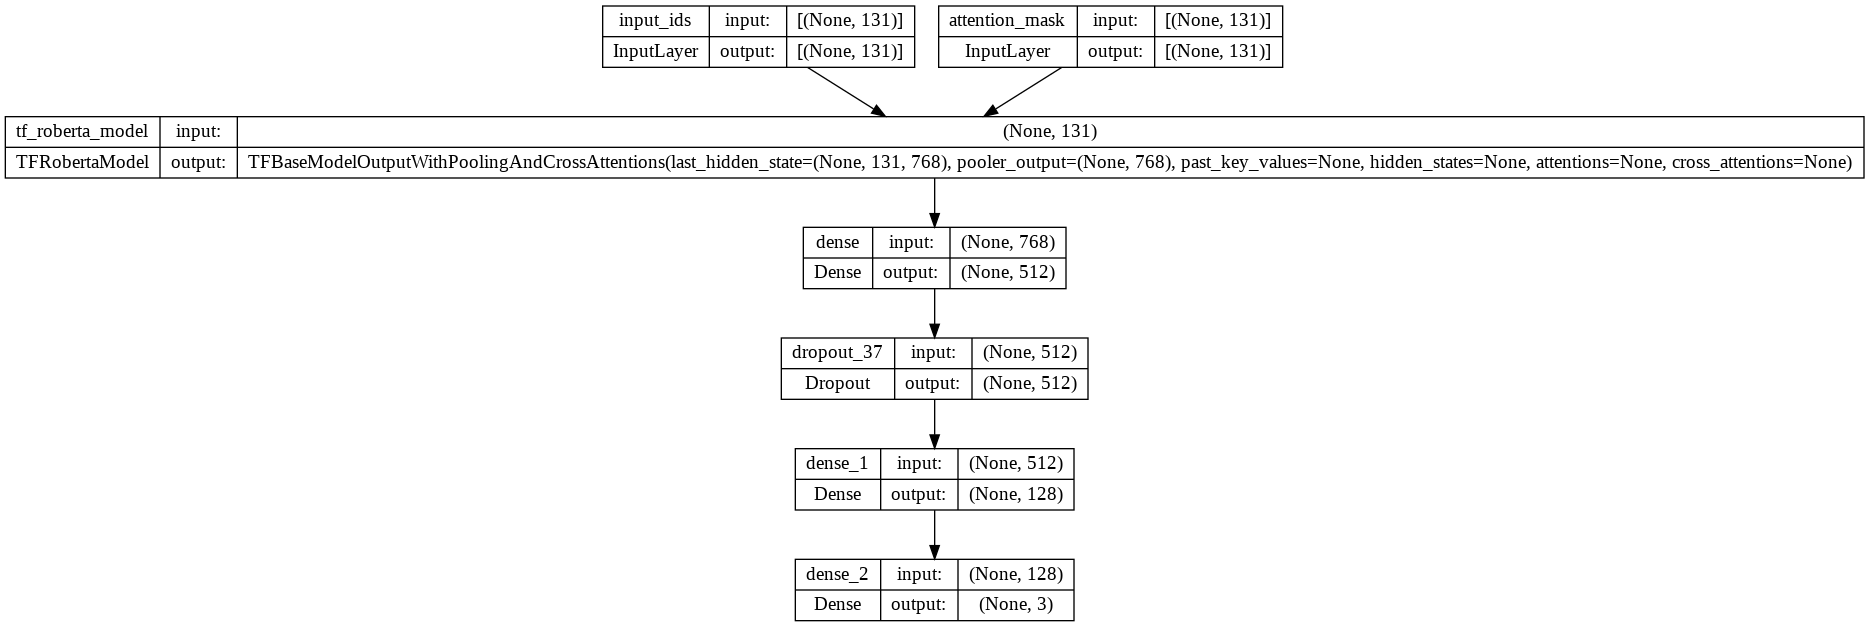

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 131)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 131)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  134899968  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 131,                                           

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask'], 
                         }, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                                         }, 
                                       to_categorical(df_ethos_ts.Ethos_Label.tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask'], 
                           })

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 


              precision    recall  f1-score   support

           0      0.815     0.773     0.794       291
           1      0.655     0.650     0.652       117
           2      0.708     0.751     0.729       265

    accuracy                          0.743       673
   macro avg      0.726     0.725     0.725       673
weighted avg      0.745     0.743     0.744       673



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.tolist(), y_pred, digits=3)) 
# with pooler out 

#Models 2-stage cls

##Resample 2x2-cat

In [ ]:
et.Ethos_Label.value_counts(normalize=True).round(3)

0    0.714
2    0.198
1    0.088
Name: Ethos_Label, dtype: float64

In [ ]:
et.Ethos_Label.value_counts()

0    4650
2    1289
1     574
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos = et[et.Ethos_Label != 0]

neu_eth = et[et.Ethos_Label == 0].sample(n = 2200, random_state=3)

df_ethos = pd.concat([df_ethos, neu_eth], axis = 0)
df_ethos = df_ethos.reset_index(drop=True)
df_ethos.shape

(4063, 42)

In [ ]:
df_ethos.Ethos_Label.value_counts()

0    2200
2    1289
1     574
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos.Ethos_Label.value_counts(normalize=True).round(3)

0    0.541
2    0.317
1    0.141
Name: Ethos_Label, dtype: float64

##Train-Tet split

In [ ]:
from sklearn.dummy import DummyClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, accuracy_score


In [ ]:
df_ethos = clean_text(df_ethos, text_column = 'Text')

In [ ]:
df_ethos.index

RangeIndex(start=0, stop=4063, step=1)

In [ ]:
data_ids =  list(df_ethos.index)

In [ ]:
train, test = train_test_split(data_ids, test_size = 0.2, random_state = 10)
len(train), len(test)

(3250, 813)

In [ ]:
df_ethos_tr = df_ethos.loc[train]
df_ethos_ts = df_ethos.loc[test]

In [ ]:
max(df_ethos.Text.str.split().map(len))

123

In [ ]:
eth_map = {
    0:0, 
    1:1, 
    2:1
}

##LogReg baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
cls_pipe = Pipeline([('count_vector', TfidfVectorizer()), ('Log', LogisticRegression())])
print(f"Model pipeline: {cls_pipe.named_steps}\n")

Model pipeline: {'count_vector': TfidfVectorizer(), 'Log': LogisticRegression()}



In [ ]:
tf = cls_pipe[0]
len(tf.get_feature_names_out())

4579

In [ ]:
tf_df = pd.DataFrame(tf.transform(df_ethos_tr.Text.values).toarray(), 
                     columns = tf.get_feature_names_out())

tf_df.shape

(3250, 4579)

In [ ]:
tf_df.iloc[:5, 3:10]

,aboard,abortion,about,above,abroad,absence,absentee
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
desc = tf_df.describe().T
desc = desc[desc['max'] > 0.5]

In [ ]:
desc.shape

(1813, 8)

In [ ]:
desc[desc['max'] > 0.9].shape

(90, 8)

In [ ]:
desc[desc['max'] > 0.85].shape

(127, 8)

In [ ]:
desc[desc['max'] > 0.75].shape

(252, 8)

In [ ]:
tf_w = " ".join(desc[desc['max'] > 0.75].index.tolist())
tf_w

'absolutely agree agreed ahaha alcoholics amirite amphetamines apparently ate awesome basic being biglig bigly blah blame bonne boring braincells brit button calm can capitalist cares carson catch chaffee childish chinico church cocaine complicated confirmed consistent control correct couldn count crazy cringe cringeworthy cringy criticism deaf death debate deny despise destroy devil ding disagree doesn ear earned easier effukicy embarrassing embarrassment environment exactly excellent except experience eyerollled fair fan fear female filter finally fr free frightening frustrating fuck gaffs gamble genuine gettin giggidy girl governor greater gud hasn hate healthy help hilarious hillary himself holt holup holy honest icon identical ikr illiterate influence introduced ireland ironic irrelevant isn jesus jokes killed killing know la latter league lester liberal libertarian like lmao lol losing lot love mad maddening malley material math maybe mccain me media military millions mine modera

In [ ]:
with open("TfIdf_words_ethos.txt", "w") as text_file:
    text_file.write(tf_w)

In [ ]:
cls_pipe.fit(df_ethos_tr.Text.values, df_ethos_tr.Ethos_Label.map(eth_map).values)
predictions = cls_pipe.predict(df_ethos_ts.Text.values)

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.map(eth_map).values, predictions, digits = 3))

              precision    recall  f1-score   support

           0      0.735     0.801     0.767       433
           1      0.748     0.671     0.707       380

    accuracy                          0.740       813
   macro avg      0.741     0.736     0.737       813
weighted avg      0.741     0.740     0.739       813



In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(df_ethos_tr.Text.values, df_ethos_tr.Ethos_Label.map(eth_map).values)
predictions_cls_frq = dummy_cls_frq.predict(df_ethos_ts.Text.values)
print(metrics.classification_report(df_ethos_ts.Ethos_Label.map(eth_map).values, predictions_cls_frq, digits = 3))

              precision    recall  f1-score   support

           0      0.533     1.000     0.695       433
           1      0.000     0.000     0.000       380

    accuracy                          0.533       813
   macro avg      0.266     0.500     0.348       813
weighted avg      0.284     0.533     0.370       813



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
corr = pd.DataFrame({'test': predictions, 'org': df_ethos_ts.Ethos_Label.map(eth_map).tolist()})
corr.head()

,test,org
0,1,0
1,1,1
2,0,0
3,1,0
4,0,1


In [ ]:
corr['correct'] = np.where(corr['test'] == corr['org'], corr['org'], np.nan)
corr['correct'].iloc[:5]

0    NaN
1    1.0
2    0.0
3    NaN
4    NaN
Name: correct, dtype: float64

In [ ]:
corr.shape

(813, 3)

In [ ]:
corr = corr.dropna(subset = ['correct'], axis=0)
corr.shape

(602, 3)

In [ ]:
corr.correct.value_counts()

0.0    347
1.0    255
Name: correct, dtype: int64

In [ ]:
ids_corr = corr[corr.correct == 1].index
len(ids_corr)

255

In [ ]:
df_ethos_tr[df_ethos_tr.Ethos_Label != 0].Ethos_Label.value_counts()

2    1033
1     450
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos_ts = df_ethos_ts.reset_index(drop=True)
df_ethos_ts2 = df_ethos_ts.loc[ids_corr]

df_ethos_tr2 = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]

In [ ]:
cls_pipe = Pipeline([('count_vector', TfidfVectorizer()), ('Log', LogisticRegression())])
print(f"Model pipeline: {cls_pipe.named_steps}\n")

Model pipeline: {'count_vector': TfidfVectorizer(), 'Log': LogisticRegression()}



In [ ]:
cls_pipe.fit(df_ethos_tr2.Text.values, df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).values)
predictions = cls_pipe.predict(df_ethos_ts2.Text.values)

In [ ]:
print(metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).values, predictions, digits = 3))

              precision    recall  f1-score   support

           0      0.691     0.964     0.805       165
           1      0.760     0.211     0.330        90

    accuracy                          0.698       255
   macro avg      0.726     0.587     0.568       255
weighted avg      0.716     0.698     0.638       255



In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(df_ethos_tr2.Text.values, df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).values)
predictions_cls_frq = dummy_cls_frq.predict(df_ethos_ts2.Text.values)
print(metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).values, predictions_cls_frq, digits = 3))

              precision    recall  f1-score   support

           0      0.647     1.000     0.786       165
           1      0.000     0.000     0.000        90

    accuracy                          0.647       255
   macro avg      0.324     0.500     0.393       255
weighted avg      0.419     0.647     0.508       255



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#  +/- ese separate

df_ethos_tr2 = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]
df_ethos_ts2 = df_ethos_ts[df_ethos_ts.Ethos_Label != 0]

In [ ]:
cls_pipe = Pipeline([('count_vector', CountVectorizer()), ('Log', LogisticRegression())])
print(f"Model pipeline: {cls_pipe.named_steps}\n")

Model pipeline: {'count_vector': CountVectorizer(), 'Log': LogisticRegression()}



In [ ]:
cls_pipe.fit(df_ethos_tr2.Text.values, df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).values)
predictions = cls_pipe.predict(df_ethos_ts2.Text.values)

In [ ]:
cls_pipe.fit(han_tr.text2.values, han_tr.Ethos_Label.map({1:1, 2:0}).values)
predictions = cls_pipe.predict(han_ts.text2.values)# hans

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.map({1:1, 2:0}).values, predictions, digits = 3))

              precision    recall  f1-score   support

           0      0.733     0.867     0.794       256
           1      0.558     0.347     0.428       124

    accuracy                          0.697       380
   macro avg      0.646     0.607     0.611       380
weighted avg      0.676     0.697     0.675       380



In [ ]:
print(metrics.classification_report(han_ts.Ethos_Label.map({1:1, 2:0}).values, predictions, digits = 3)) # hans

              precision    recall  f1-score   support

           0      0.798     0.994     0.886       179
           1      0.947     0.286     0.439        63

    accuracy                          0.810       242
   macro avg      0.873     0.640     0.662       242
weighted avg      0.837     0.810     0.769       242



In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(df_ethos_tr2.Text.values, df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).values)
predictions_cls_frq = dummy_cls_frq.predict(df_ethos_ts2.Text.values)
print(metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).values, predictions_cls_frq, digits = 3))

              precision    recall  f1-score   support

           0      0.674     1.000     0.805       256
           1      0.000     0.000     0.000       124

    accuracy                          0.674       380
   macro avg      0.337     0.500     0.403       380
weighted avg      0.454     0.674     0.542       380



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(han_tr.text2.values, han_tr.Ethos_Label.map({1:1, 2:0}).values)
predictions_cls_frq = dummy_cls_frq.predict(han_ts.text2.values)
print(metrics.classification_report(han_ts.Ethos_Label.map({1:1, 2:0}).values, predictions_cls_frq, digits = 3))# hans

              precision    recall  f1-score   support

           0      0.740     1.000     0.850       179
           1      0.000     0.000     0.000        63

    accuracy                          0.740       242
   macro avg      0.370     0.500     0.425       242
weighted avg      0.547     0.740     0.629       242



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##m8

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
df_ethos_tr = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]
df_ethos_ts = df_ethos_ts[df_ethos_ts.Ethos_Label != 0]

In [ ]:
x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
max(han_tr.Text.str.split().map(len))

97

In [ ]:
han_ts.shape

(242, 5)

In [ ]:
# hans

x_train = tokenizer(text = han_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = 100, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = han_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = 100, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.MaxPool1D(3)(x)
x = layers.Conv1D(128, 3, activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(2, activation = 'softmax')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

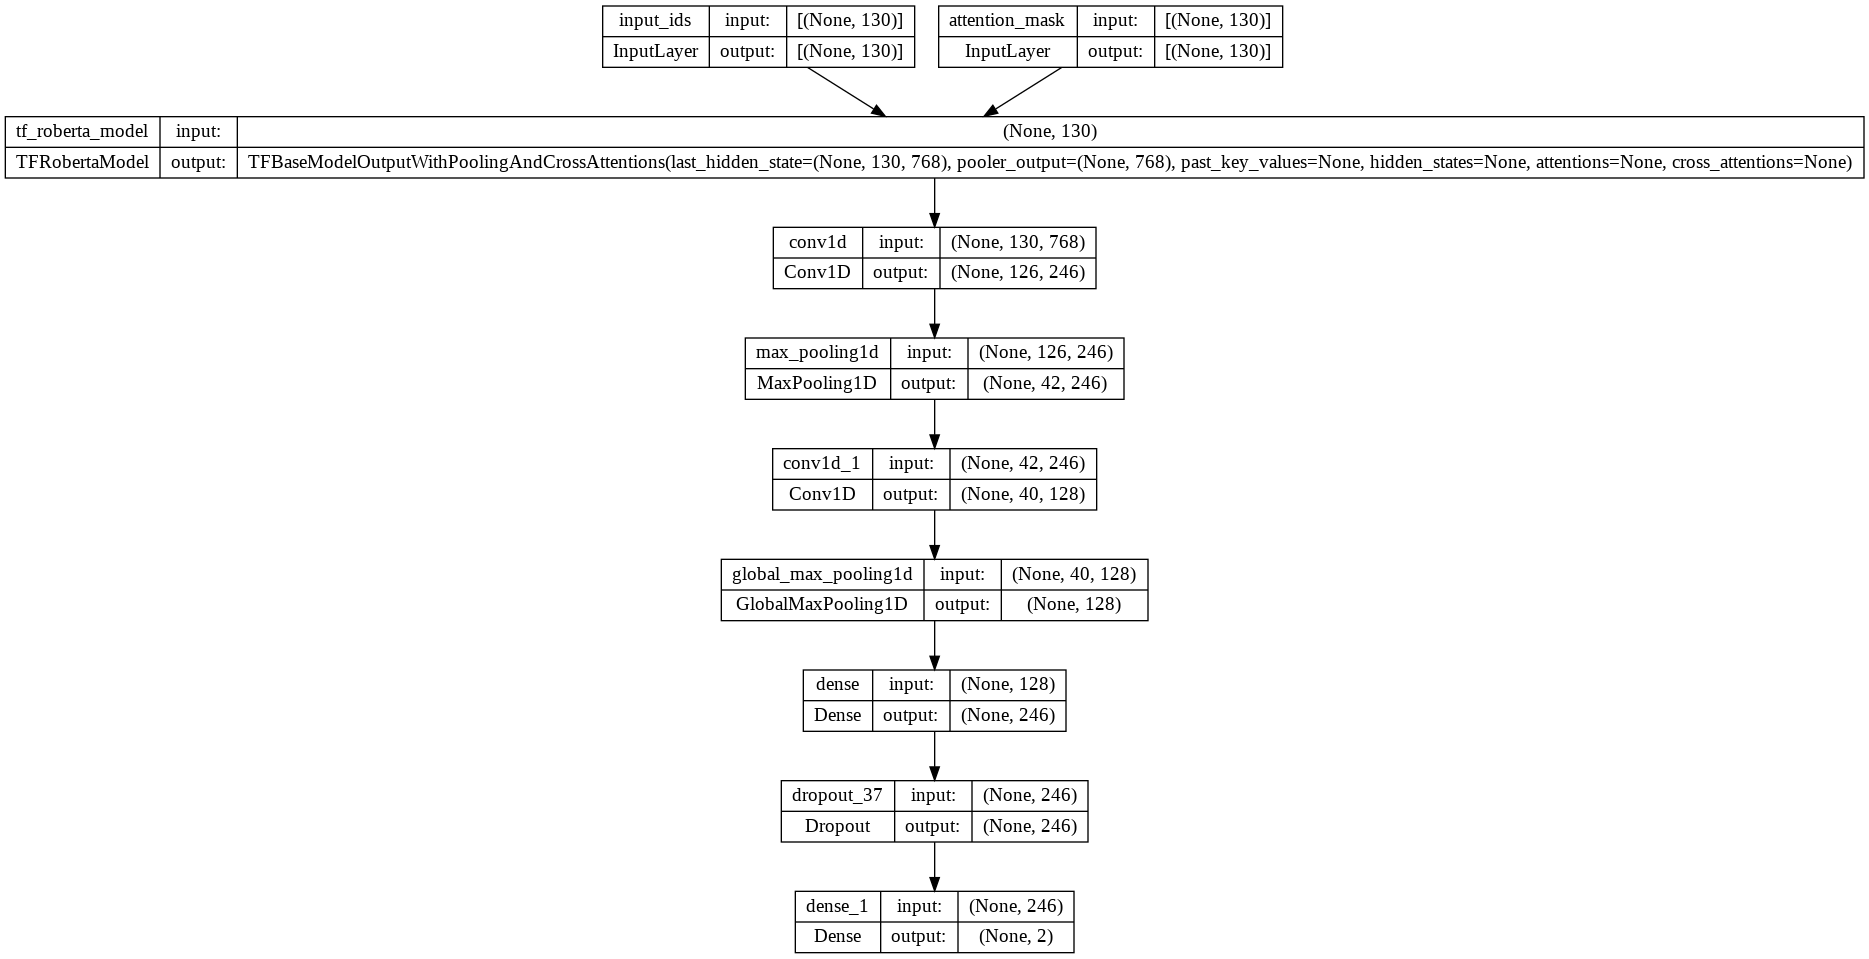

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.map(eth_map).tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.map(eth_map).tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


407/407 [==============================] - 151s 284ms/step - loss: 0.5096 - balanced_accuracy: 0.7557 - val_loss: 0.4715 - val_balanced_accuracy: 0.7835
Epoch 2/2
407/407 [==============================] - 121s 296ms/step - loss: 0.3526 - balanced_accuracy: 0.8585 - val_loss: 0.4338 - val_balanced_accuracy: 0.8020


In [ ]:
#  +/- ese separate

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr.Ethos_Label.map({1:1, 2:0}).tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts.Ethos_Label.map({1:1, 2:0}).tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


186/186 [==============================] - 81s 304ms/step - loss: 0.2278 - balanced_accuracy: 0.9225 - val_loss: 0.5335 - val_balanced_accuracy: 0.8079
Epoch 2/2
186/186 [==============================] - 53s 283ms/step - loss: 0.1347 - balanced_accuracy: 0.9636 - val_loss: 0.5294 - val_balanced_accuracy: 0.8263


In [ ]:
#  +/- ese separate  hans

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(han_tr.Ethos_Label.map({1:1, 2:0}).tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(han_ts.Ethos_Label.map({1:1, 2:0}).tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


50/50 [==============================] - 619s 12s/step - loss: 0.5717 - balanced_accuracy: 0.7316 - val_loss: 0.5017 - val_balanced_accuracy: 0.7645
Epoch 2/2
50/50 [==============================] - 575s 12s/step - loss: 0.4135 - balanced_accuracy: 0.8278 - val_loss: 0.3648 - val_balanced_accuracy: 0.8388


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer

y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

8/8 [==============================] - 87s 10s/step


array([0, 0, 1])

In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.map(eth_map).tolist(), y_pred, digits=3)) 
# ese / n-ese

              precision    recall  f1-score   support

           0      0.832     0.788     0.809       433
           1      0.772     0.818     0.794       380

    accuracy                          0.802       813
   macro avg      0.802     0.803     0.802       813
weighted avg      0.804     0.802     0.802       813



In [ ]:
print(metrics.classification_report(df_ethos_ts.Ethos_Label.map({1:1, 2:0}).tolist(), y_pred, digits=3)) 
#  +/- ese separate

              precision    recall  f1-score   support

           0      0.852     0.898     0.875       256
           1      0.764     0.677     0.718       124

    accuracy                          0.826       380
   macro avg      0.808     0.788     0.796       380
weighted avg      0.823     0.826     0.823       380



In [ ]:
print(metrics.classification_report(han_ts.Ethos_Label.map({1:1, 2:0}).tolist(), y_pred, digits=3)) 
#  +/- ese separate   hans

              precision    recall  f1-score   support

           0      0.827     0.989     0.901       179
           1      0.929     0.413     0.571        63

    accuracy                          0.839       242
   macro avg      0.878     0.701     0.736       242
weighted avg      0.854     0.839     0.815       242



In [ ]:
corr = pd.DataFrame({'test': y_pred, 'org': df_ethos_ts.Ethos_Label.map(eth_map).tolist()})
corr.head()

In [ ]:
corr['correct'] = np.where(corr['test'] == corr['org'], corr['org'], np.nan)
corr['correct']

In [ ]:
corr.shape

(813, 3)

In [ ]:
corr = corr.dropna(subset = ['correct'], axis=0)
corr.shape

(652, 3)

In [ ]:
corr.correct.value_counts()

0.0    341
1.0    311
Name: correct, dtype: int64

In [ ]:
ids_corr = corr[corr.correct == 1].index
len(ids_corr)

311

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.MaxPool1D(3)(x)
x = layers.Conv1D(128, 3, activation = 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = Dense(246, activation = 'relu')(x)
x = Dropout(0.3)(x)
y = Dense(2, activation = 'softmax')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = y)

In [ ]:
df_ethos_tr[df_ethos_tr.Ethos_Label != 0].Ethos_Label.value_counts()

2    1033
1     450
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos_ts = df_ethos_ts.reset_index(drop=True)
df_ethos_ts2 = df_ethos_ts.loc[ids_corr]

df_ethos_tr2 = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]

In [ ]:
x_train = tokenizer(text = df_ethos_tr2.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = loss, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = to_categorical(df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).tolist()), 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       to_categorical(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).tolist()) ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


186/186 [==============================] - 82s 292ms/step - loss: 0.5389 - balanced_accuracy: 0.7451 - val_loss: 0.4862 - val_balanced_accuracy: 0.8296
Epoch 2/2
186/186 [==============================] - 55s 295ms/step - loss: 0.3637 - balanced_accuracy: 0.8537 - val_loss: 0.4234 - val_balanced_accuracy: 0.8232


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

# for custom architecture with softmax in cls layer
y_pred = np.argmax(predicted, axis = -1)
y_pred[:3]

10/10 [==============================] - 8s 291ms/step


array([0, 0, 0])

In [ ]:
print(metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).tolist(), y_pred, digits=3)) 
# + / - ese

              precision    recall  f1-score   support

           0      0.886     0.848     0.866       210
           1      0.709     0.772     0.739       101

    accuracy                          0.823       311
   macro avg      0.797     0.810     0.803       311
weighted avg      0.828     0.823     0.825       311



##m9

In [ ]:
max_len = 130


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFBertModel, TFAutoModel

checkpoint = "vinai/bertweet-base" # "bert-base-cased"

tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
bert = TFAutoModel.from_pretrained(checkpoint)

#tokenizer.save_pretrained('bert-tokenizer')
#bert.save_pretrained('bert-model')

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
bert.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [ ]:
df_ethos_tr = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]
df_ethos_ts = df_ethos_ts[df_ethos_ts.Ethos_Label != 0]

In [ ]:
x_train = tokenizer(text = df_ethos_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
x_test = tokenizer(text = hil2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# hans
x_train = tokenizer(text = han_tr.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = han_ts.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.GlobalMaxPool1D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y1 = Dense(2, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

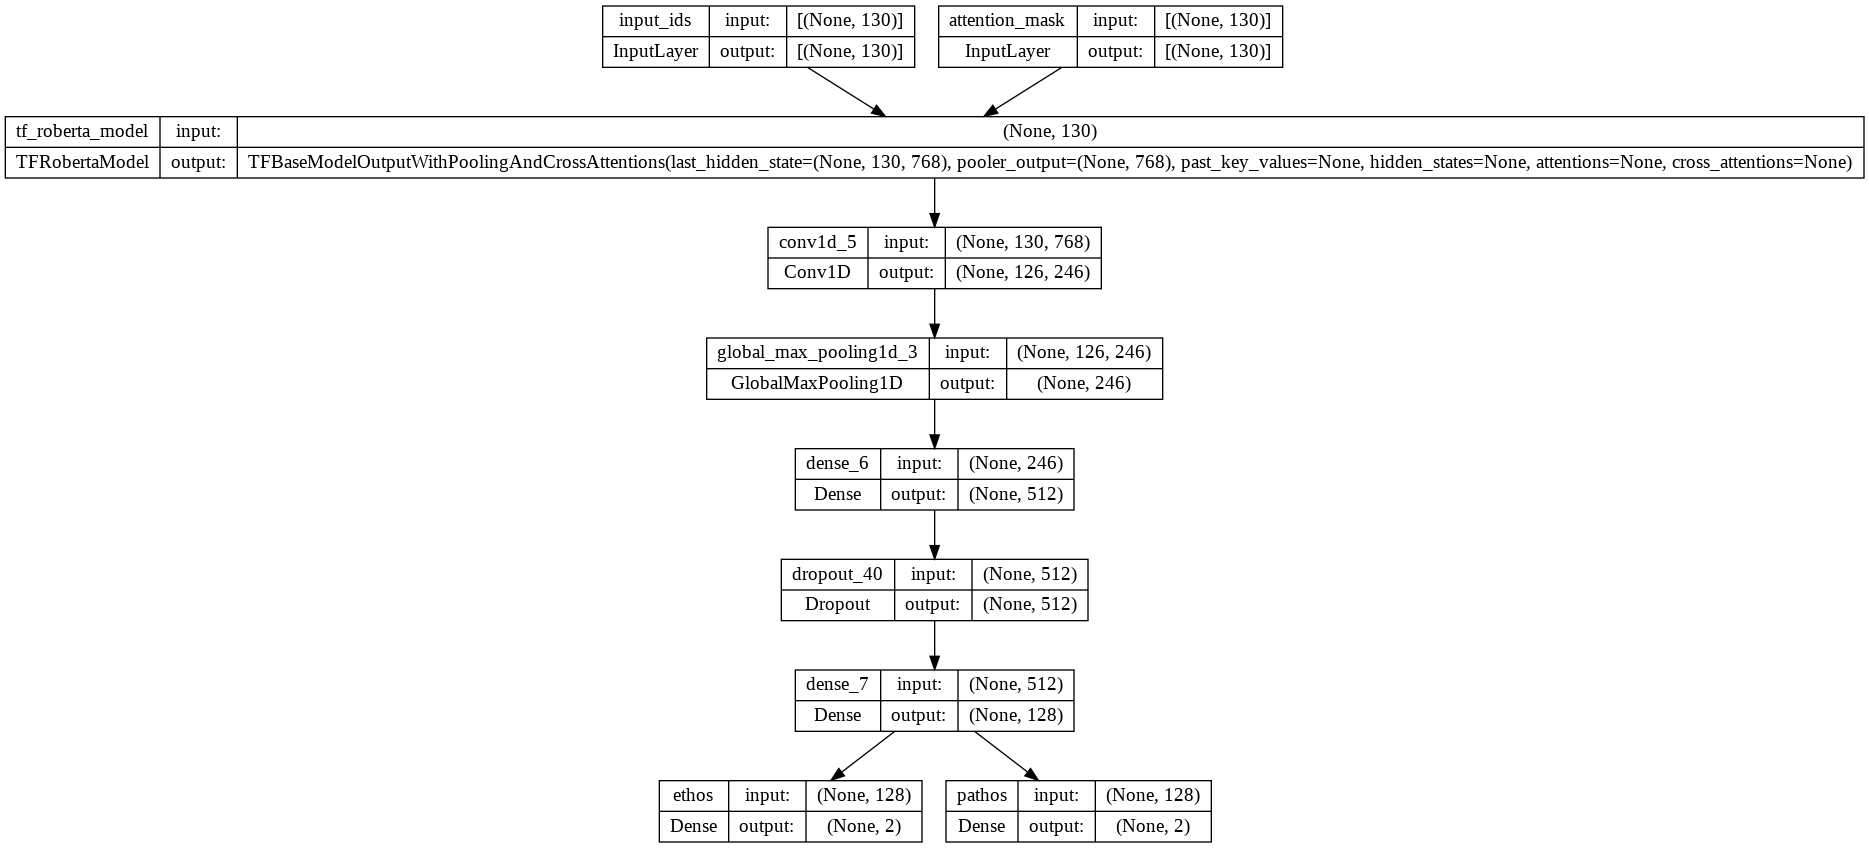

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.summary()

In [ ]:
# chech parameters -> loss !!  from_logits


optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)


In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.map(eth_map).tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.map(eth_map).tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


337/337 [==============================] - 116s 297ms/step - loss: 0.6792 - ethos_loss: 0.3227 - pathos_loss: 0.3565 - ethos_balanced_accuracy: 0.8714 - pathos_balanced_accuracy: 0.8599 - val_loss: 0.9105 - val_ethos_loss: 0.4169 - val_pathos_loss: 0.4936 - val_ethos_balanced_accuracy: 0.8351 - val_pathos_balanced_accuracy: 0.7875
Epoch 2/2
337/337 [==============================] - 96s 283ms/step - loss: 0.3980 - ethos_loss: 0.1814 - pathos_loss: 0.2165 - ethos_balanced_accuracy: 0.9401 - pathos_balanced_accuracy: 0.9301 - val_loss: 0.9881 - val_ethos_loss: 0.4531 - val_pathos_loss: 0.5350 - val_ethos_balanced_accuracy: 0.8217 - val_pathos_balanced_accuracy: 0.7741


In [ ]:
#  +/- ese separate

history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr.Ethos_Label.map({1:1, 2:0}).tolist()), 
                         'pathos': to_categorical(df_ethos_tr.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts.Ethos_Label.map({1:1, 2:0}).tolist()), 
                                        'pathos':to_categorical(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


186/186 [==============================] - 99s 352ms/step - loss: 0.6036 - ethos_loss: 0.1570 - pathos_loss: 0.4466 - ethos_balanced_accuracy: 0.9575 - pathos_balanced_accuracy: 0.7835 - val_loss: 1.3001 - val_ethos_loss: 0.5309 - val_pathos_loss: 0.7693 - val_ethos_balanced_accuracy: 0.8105 - val_pathos_balanced_accuracy: 0.6553
Epoch 2/2
186/186 [==============================] - 53s 287ms/step - loss: 0.3119 - ethos_loss: 0.1040 - pathos_loss: 0.2079 - ethos_balanced_accuracy: 0.9724 - pathos_balanced_accuracy: 0.9252 - val_loss: 1.4088 - val_ethos_loss: 0.5514 - val_pathos_loss: 0.8574 - val_ethos_balanced_accuracy: 0.8132 - val_pathos_balanced_accuracy: 0.6684


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})


233/233 [==============================] - 65s 278ms/step


In [ ]:
y_pred_hil = np.argmax(predicted[0], axis = -1) # ethos


In [ ]:
# multi-task

y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos

y_pred[:5], y_pred2[:5]

(array([1, 0, 1, 1, 1]), array([1, 1, 1, 1, 0]))

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map(eth_map).tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 1, 'negative':0}).tolist(), 
                                               y_pred2, digits=3)) # train 2

Ethos
               precision    recall  f1-score   support

           0      0.877     0.687     0.771       291
           1      0.796     0.927     0.856       382

    accuracy                          0.823       673
   macro avg      0.836     0.807     0.813       673
weighted avg      0.831     0.823     0.819       673

Pathos
               precision    recall  f1-score   support

           0      0.684     0.717     0.700       244
           1      0.835     0.811     0.823       429

    accuracy                          0.777       673
   macro avg      0.759     0.764     0.761       673
weighted avg      0.780     0.777     0.778       673



In [ ]:
'''
Ethos
               precision    recall  f1-score   support

           0      0.854     0.769     0.809       433
           1      0.764     0.850     0.804       380

    accuracy                          0.807       813
   macro avg      0.809     0.810     0.807       813
weighted avg      0.812     0.807     0.807       813


Pathos {'positive': 1, 'neutral': 0, 'negative':1}

               precision    recall  f1-score   support

           0      0.764     0.804     0.784       516
           1      0.626     0.569     0.596       297

    accuracy                          0.718       813
   macro avg      0.695     0.687     0.690       813
weighted avg      0.714     0.718     0.715       813




Ethos
               precision    recall  f1-score   support

           0      0.874     0.737     0.799       433
           1      0.746     0.879     0.807       380

    accuracy                          0.803       813
   macro avg      0.810     0.808     0.803       813
weighted avg      0.814     0.803     0.803       813



Pathos  [  {'positive': 1, 'neutral': 1, 'negative':0}  ]   !!!!!!!!

               precision    recall  f1-score   support

           0      0.577     0.655     0.613       258
           1      0.829     0.777     0.802       555

    accuracy                          0.738       813
   macro avg      0.703     0.716     0.708       813
weighted avg      0.749     0.738     0.742       813'''

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts.Ethos_Label.map({1:1, 2:0}).tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist(), 
                                               y_pred2, digits=3)) 
#  +/- ese separate

Ethos
               precision    recall  f1-score   support

           0      0.857     0.867     0.862       256
           1      0.719     0.702     0.710       124

    accuracy                          0.813       380
   macro avg      0.788     0.784     0.786       380
weighted avg      0.812     0.813     0.813       380

Pathos
               precision    recall  f1-score   support

           0      0.639     0.780     0.703       191
           1      0.714     0.556     0.625       189

    accuracy                          0.668       380
   macro avg      0.677     0.668     0.664       380
weighted avg      0.677     0.668     0.664       380



In [ ]:
corr = pd.DataFrame({'test': y_pred, 'org': df_ethos_ts.Ethos_Label.map(eth_map).tolist()})
corr.head()

,test,org
0,1,1
1,0,0
2,1,0
3,1,1
4,1,1


In [ ]:
corr.shape

(673, 2)

In [ ]:
corr['correct'] = np.where(corr['test'] == corr['org'], corr['org'], np.nan)
corr['correct'].iloc[:5]

0    1.0
1    0.0
2    NaN
3    1.0
4    1.0
Name: correct, dtype: float64

In [ ]:
corr.shape

(673, 3)

In [ ]:
corr2 = corr.dropna(subset = ['correct'], axis=0)
corr2.shape

(553, 3)

In [ ]:
corr2.correct.value_counts()

1.0    344
0.0    209
Name: correct, dtype: int64

In [ ]:
ids_corr = corr2[corr2.correct == 1].index
len(ids_corr)

344

In [ ]:
input_ids = Input(shape = (max_len, ), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (max_len, ), dtype = tf.int32, name = 'attention_mask')

embeddings = bert(input_ids, attention_mask = input_mask)[0] # last
x = layers.Conv1D(246, 5, activation = 'relu')(embeddings)
x = layers.GlobalMaxPool1D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = 'relu')(x)
y1 = Dense(2, activation = 'softmax', name = 'ethos')(x)
y2 = Dense(2, activation = 'softmax', name = 'pathos')(x)

model = tf.keras.Model(inputs = [input_ids, input_mask], outputs = [y1, y2])

In [ ]:
df_ethos_tr[df_ethos_tr.Ethos_Label != 0].Ethos_Label.value_counts()

2    1024
1     457
Name: Ethos_Label, dtype: int64

In [ ]:
df_ethos_ts = df_ethos_ts.reset_index(drop=True)
df_ethos_ts2 = df_ethos_ts.loc[ids_corr]

df_ethos_tr2 = df_ethos_tr[df_ethos_tr.Ethos_Label != 0]

In [ ]:
x_train = tokenizer(text = df_ethos_tr2.Text.tolist(),
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

x_test = tokenizer(text = df_ethos_ts2.Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
hil2 = hil2.reset_index(drop=True)

In [ ]:
x_test = tokenizer(text = hil2.loc[ids_hil112].Text.tolist(), 
                    add_special_tokens=True, 
                    max_length = max_len, 
                    truncation = True, 
                    padding = 'max_length', 
                    return_tensors = 'tf', 
                    return_token_type_ids = False, 
                    return_attention_mask = True, 
                    )

In [ ]:
# chech parameters -> loss !!  from_logits

optimizer = Adam(learning_rate = 3e-5, epsilon = 1e-8, decay = 1e-2)
loss = CategoricalCrossentropy() #  from_logits = True
metric = CategoricalAccuracy('balanced_accuracy')

model.compile(loss = {'ethos': loss, 'pathos': loss}, optimizer = optimizer, metrics = metric)

In [ ]:
batch_size = 8
epoch = 2

In [ ]:
history = model.fit(x = {'input_ids': x_train['input_ids'], 'attention_mask': x_train['attention_mask']}, 
                    y = {'ethos': to_categorical(df_ethos_tr2.Ethos_Label.map({1:1, 2:0}).tolist()), 
                         'pathos': to_categorical(df_ethos_tr2.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist()) } , 
                    validation_data = ( {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}, 
                                       {'ethos': to_categorical(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).tolist()), 
                                        'pathos':to_categorical(df_ethos_ts2.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist())} ), 
                    epochs = epoch, 
                    batch_size = batch_size, verbose = 1)

Epoch 1/2


186/186 [==============================] - 102s 343ms/step - loss: 0.6887 - ethos_loss: 0.3628 - pathos_loss: 0.3259 - ethos_balanced_accuracy: 0.8575 - pathos_balanced_accuracy: 0.8791 - val_loss: 1.1591 - val_ethos_loss: 0.4223 - val_pathos_loss: 0.7367 - val_ethos_balanced_accuracy: 0.8285 - val_pathos_balanced_accuracy: 0.6512
Epoch 2/2
186/186 [==============================] - 55s 294ms/step - loss: 0.4379 - ethos_loss: 0.2170 - pathos_loss: 0.2209 - ethos_balanced_accuracy: 0.9271 - pathos_balanced_accuracy: 0.9176 - val_loss: 1.2702 - val_ethos_loss: 0.4565 - val_pathos_loss: 0.8137 - val_ethos_balanced_accuracy: 0.8256 - val_pathos_balanced_accuracy: 0.6773


In [ ]:
predicted = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

79/79 [==============================] - 22s 274ms/step


In [ ]:
# multi-task

y_pred = np.argmax(predicted[0], axis = -1) # ethos
y_pred2 = np.argmax(predicted[1], axis = -1) # pathos

print('Ethos\n', metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts2.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.846     0.911     0.878       236
           1      0.767     0.639     0.697       108

    accuracy                          0.826       344
   macro avg      0.807     0.775     0.787       344
weighted avg      0.821     0.826     0.821       344

Pathos
               precision    recall  f1-score   support

           0      0.648     0.715     0.680       165
           1      0.710     0.642     0.674       179

    accuracy                          0.677       344
   macro avg      0.679     0.679     0.677       344
weighted avg      0.680     0.677     0.677       344



In [ ]:
df_hil = pd.DataFrame({'pred_label_01': y_pred_hil})
df_hil.head()

,pred_label_01
0,0
1,0
2,0
3,0
4,1


In [ ]:
df_hil['pred_label_012'] = np.where(df_hil.pred_label_01 == 0, -1, np.nan)
ids_hil112 = df_hil[df_hil['pred_label_012'].isna()].index

In [ ]:
y_pred_hil2 = np.argmax(predicted[0], axis = -1) # ethos
y_pred_hil2.shape

(2504,)

In [ ]:
df_hil.loc[ids_hil112, 'pred_label_012'] = y_pred_hil2
df_hil.iloc[:, -1].value_counts()

-1.0    4924
 0.0    1341
 1.0    1163
Name: pred_label_012, dtype: int64

In [ ]:
df_hil.iloc[:, -1].map({-1:0, 0:2, 1:1}).to_csv('/content/labels012.csv', index=False)
df_hil.shape

(7428, 2)

In [ ]:
print('Ethos\n', metrics.classification_report(df_ethos_ts2.Ethos_Label.map({1:1, 2:0}).tolist(), 
                                               y_pred, digits=3)) 

print('Pathos\n', metrics.classification_report(df_ethos_ts2.pathos_name.map({'positive': 1, 'neutral': 0, 'negative':1}).tolist(), 
                                               y_pred2, digits=3)) 

Ethos
               precision    recall  f1-score   support

           0      0.898     0.885     0.891       218
           1      0.769     0.790     0.779       105

    accuracy                          0.854       323
   macro avg      0.833     0.838     0.835       323
weighted avg      0.856     0.854     0.855       323

Pathos
               precision    recall  f1-score   support

           0      0.686     0.677     0.682       155
           1      0.706     0.714     0.710       168

    accuracy                          0.697       323
   macro avg      0.696     0.696     0.696       323
weighted avg      0.696     0.697     0.697       323



In [ ]:
'''Ethos
               precision    recall  f1-score   support

           0      0.883     0.836     0.859       226
           1      0.692     0.769     0.728       108

    accuracy                          0.814       334
   macro avg      0.787     0.802     0.794       334
weighted avg      0.821     0.814     0.817       334


Pathos  [  {'positive': 1, 'neutral': 1, 'negative':0}  ]  !!!!!!!!


               precision    recall  f1-score   support

           0      0.740     0.647     0.690       150
           1      0.739     0.815     0.775       184

    accuracy                          0.740       334
   macro avg      0.740     0.731     0.733       334
weighted avg      0.740     0.740     0.737       334
'''